In [1]:
import pandas as pd
import numpy as np
import glob as glob
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Embedding, Dot
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
# from data_parser import DataParser
# from skip_gram import SkipGramModel

In [2]:
courses = pd.read_csv('/Users/rsciagli/documents/Fall2020/BAR/STU_CRS_TBL_full.csv', encoding='latin', dtype={'CRS_ID':str})
#courses.head()

/Users/rsciagli/opt/anaconda3/envs/dataweekends/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# courses['CRS_ID'].isnull().sum()
# courses['CRS_ID'].astype(float).isnull().sum()
# courses[['CRS_ID','EARNED_BFORE_COHORT']]
# for dummy, df in courses.groupby('EARNED_BFORE_COHORT')['CRS_ID']:
#     print(dummy)
#     print(len(df))
#     display(df.isnull().sum())

In [4]:
#courses_sample = courses

In [5]:
courses['crs_ofcl_grd_nbr'.upper()].unique()
mask_type = courses['CRS_TYPE']=='ENRL'
discarded_grades = ['ZZ']
discarded_transfer_crs = ['Y']                          
mask_grade = ~courses['CRS_OFCL_GRD_CD'].isin(discarded_grades)                          
mask = mask_grade&mask_type
crs_embed_subset = courses[mask]

In [6]:
crs_df = pd.DataFrame(crs_embed_subset)
crs_df['agg_id'] = crs_df['CRS_ID'].astype(str)
print(crs_df['agg_id'].isnull().values.any())
print(crs_df['CRS_ID'].astype(str).isnull().values.any())

False
False


In [7]:
subj_by_id = crs_df['agg_id'].value_counts()
big_subj_by_id = subj_by_id[subj_by_id>10].index
crs_df['agg_id'] = np.where(crs_df['agg_id'].isin(big_subj_by_id), crs_df['agg_id'],'not_in_final_results')
#pd.Series(pruned_id).value_counts()

In [8]:
#plt.hist(courses['CRS_SUBJ_DEPT_CD'].value_counts(), log=True, bins=[0,10,20,30,40,50,60,70,80,90,100])
orphan_classes = crs_df[crs_df['agg_id']=='not_in_final_results']
crs_dept_cd = orphan_classes['CRS_SUBJ_DEPT_CD'].value_counts()
big_dept = crs_dept_cd[crs_dept_cd>10].index
crs_df['agg_id'] = np.where(crs_df['agg_id'] != 'not_in_final_results', crs_df['agg_id'],
                                        np.where(crs_df['CRS_SUBJ_DEPT_CD'].isin(big_dept),
                                        crs_df['CRS_SUBJ_DEPT_CD'], 'other_dept'))    
pd.Series(crs_df['agg_id']).value_counts()
pd.Series(crs_df['agg_id']).value_counts()['other_dept']

346

In [9]:
print(crs_df['agg_id'].isnull().values.any())
#pd.Series(pruned_dept).value_counts()

False


(array([  0., 997., 662., 490., 326., 298., 243., 222., 201., 183.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <a list of 10 Patch objects>)

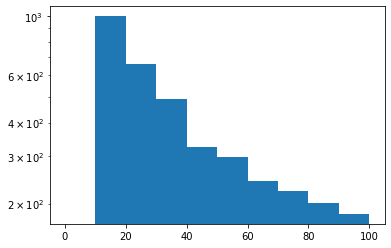

In [10]:
plt.hist(crs_df['agg_id'].value_counts(), log=True, bins=[0,10,20,30,40,50,60,70,80,90,100])
# print(crs_df['agg_id'].nunique())
# print(crs_df['agg_id'].count())
# print(crs_df['agg_id'].value_counts())

In [11]:
def helper(x):
    output = x
    try:
        int(x)
        output = None
    except:
        pass
    return output

[x for x in list(map(helper, crs_df['agg_id'].value_counts().index)) if x]

['MUS',
 'HER',
 'ENG',
 'HIST',
 'other_dept',
 'CSCI',
 'BUS',
 'RADI',
 'SOC',
 'REL',
 'BIOL',
 'CEUS',
 'PSY',
 'THTR',
 'ANTH',
 'FINA',
 'NEWM',
 'MATH',
 'HPER',
 'EDUC',
 'VCD',
 'SPEA',
 'SPAN',
 'PHIL',
 'OVST',
 'RADS',
 'COMM',
 'SLAV',
 'AHLT',
 'PBHL',
 'HIA',
 'PPOL',
 'GEOG',
 'PHYS',
 'POLS',
 'HIM',
 'GER',
 'MET',
 'FREN',
 'INFO',
 'SPCH',
 'ECE',
 'BME',
 'JOUR',
 'CIT',
 'INST',
 'INTR',
 'HISP',
 'GEOL',
 'CLAS',
 'PATH',
 'CGT',
 'NURS',
 'HSC',
 'NELC',
 'EALC',
 'CJUS',
 'SPH',
 'ME',
 'ECON',
 'CEMT',
 'CHEM',
 'AAAD',
 'LING',
 'ECET',
 'CJHS',
 'SHRS',
 'PAHM',
 'OLS',
 'AFRO',
 'KINE',
 'CMLT',
 'PHST',
 'ASL',
 'TEL',
 'ENGR',
 'EMER',
 'RADX',
 'FOLK',
 'JSTU',
 'WGS',
 'MA',
 'COM',
 'MSCH',
 'HON',
 'LTAM',
 'NMAT',
 'SOAD',
 'DHYG',
 'ITAL',
 'SPHS',
 'MIL',
 'FILM',
 'HSRV',
 'HPSC',
 'INTL',
 'COAS',
 'DAST',
 'TCM',
 'AFRI',
 'SEAS',
 'WOST',
 'HSS',
 'NMCM',
 'STAT',
 'MSTE',
 'CMCL',
 'COLL',
 'AHSC',
 'ART',
 'CHRI',
 'AMST',
 'RAON',
 'WEUR',


In [12]:
embedding_id = list(crs_df['agg_id'].unique())
course_to_id = dict([(name, i) for i, name in enumerate(embedding_id)])

def make_set(df):
    return set(df['agg_id'].map(course_to_id))

#dummy = crs_df.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD'])

In [13]:
#pd.Series(embedding_id).value_counts()

In [14]:
# dummy = crs_df.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD'])
# len(dummy)
agg_course_to_dept = dict(zip(crs_df['agg_id'],crs_df['CRS_SUBJ_DEPT_CD']))

In [15]:
departments = [agg_course_to_dept[identifier] for identifier in embedding_id]
#agg_course_to_dept

In [16]:
unique_students = list(crs_df['PRSN_UNIV_ID'].unique())
#pd.Series(unique_students).unique()
#pd.Series(unique_students).values()

In [17]:
#unique_students = crs_df['PRSN_UNIV_ID'].unique()
np.random.seed(9)
np.random.shuffle(unique_students)
n_train = int(0.1*len(unique_students))
n_valid = int(0.02*len(unique_students))
train_students = unique_students[:n_train]
valid_students = unique_students[n_train:n_train+n_valid]
crs_df_train = crs_df[crs_df['PRSN_UNIV_ID'].isin(train_students)]
crs_df_valid = crs_df[crs_df['PRSN_UNIV_ID'].isin(valid_students)]

In [18]:
print(len(crs_df_train.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD'])))
print(len(train_students))
len(unique_students)

89584
12889


128899

In [19]:
print(len(crs_df_valid.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD'])))
len(valid_students)

18025


2577

In [20]:
def train_generator(): 
    negative_courses = crs_df['agg_id'].map(course_to_id)
    n_neg = len(negative_courses)
    while True:
        for (student, term), df in crs_df_train.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD']):
            courses_set = make_set(df)
            if len(courses_set) > 1:
                for crs_1 in courses_set:
                    contexts = []
                    courses_x = []
                    matches = []
                    for crs_2 in courses_set: 
                        x = crs_1
                        y = crs_2
                        if x!=y:
                            context = list(negative_courses.iloc[np.random.choice(n_neg,4)]) + [y]
                            course = 5*[x]
                            match = [0,0,0,0,1]
                            contexts.append(np.array(context).reshape(5,1))
                            courses_x.append(np.array(course).reshape(5,1))
                            matches.append(np.array(match).reshape(5,1))
                    contexts = np.concatenate(contexts, axis=0)
                    courses_x = np.concatenate(courses_x, axis=0)
                    matches = np.concatenate(matches, axis=0)
                    yield [contexts, courses_x], matches
                
def valid_generator(): 
    negative_courses = crs_df['agg_id'].map(course_to_id)
    n_neg = len(negative_courses)
    while True:
        for (student, term), df in crs_df_valid.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD']):
            courses_set = make_set(df)
            if len(courses_set) > 1:
                for crs_1 in courses_set:
                    contexts = []
                    courses_x = []
                    matches = []
                    for crs_2 in courses_set: 
                        x = crs_1
                        y = crs_2
                        if x!=y:
                            context = list(negative_courses.iloc[np.random.choice(n_neg,4)]) + [y]
                            course = 5*[x]
                            match = [0,0,0,0,1]
                            contexts.append(np.array(context).reshape(5,1))
                            courses_x.append(np.array(course).reshape(5,1))
                            matches.append(np.array(match).reshape(5,1))
                    contexts = np.concatenate(contexts, axis=0)
                    courses_x = np.concatenate(courses_x, axis=0)
                    matches = np.concatenate(matches, axis=0)
                    yield [contexts, courses_x], matches

In [21]:
embed_dim = 20
optimizer = Adagrad(lr=0.002)

# def _build_model(course_input):
#     input_ = Input(shape=x.shape[1:], name='Course ids')
#     embed = Embedding(len(embedding_id), embed_dim, name='Course embedding')(input_)
#     output = Dense(len(embedding_id), activation='softmax', name='Course probabilities')(embed) 
    
#     model = Model(inputs=input_,outputs=output, name='Model')
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
#     return model

input_course_ = Input(shape=(1,), name='Course_ids')
input_context_ = Input(shape=(1,), name='contxt')
embed = Embedding(len(embedding_id), embed_dim, name='Course_embedding')(input_course_)
embed2 = Embedding(len(embedding_id), embed_dim, name='Context_embedding')(input_context_)
output = Dot(-1)([embed, embed2])
sigmoid = keras.activations.sigmoid(output)
model = Model(inputs=[input_course_, input_context_],outputs=sigmoid, name='Model')
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Course_ids (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
contxt (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Course_embedding (Embedding)    (None, 1, 20)        145300      Course_ids[0][0]                 
__________________________________________________________________________________________________
Context_embedding (Embedding)   (None, 1, 20)        145300      contxt[0][0]                     
______________________________________________________________________________________________

In [24]:
filepath="skip_gram_weights/skip_gram_model2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit(train_generator(), validation_data=valid_generator(), callbacks=callbacks_list,
          steps_per_epoch = 101681, validation_steps = 25421, epochs = 150)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 101681 steps, validate for 25421 steps
Epoch 1/150
101678/101681 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5118
Epoch 00001: val_loss improved from inf to 0.69307, saving model to skip_gram_weights/skip_gram_model2.hdf5
101681/101681 [==============================] - 1119s 11ms/step - loss: 0.6931 - acc: 0.5118 - val_loss: 0.6931 - val_acc: 0.5130
Epoch 2/150
101674/101681 [============================>.] - ETA: 0s - loss: 0.6930 - acc: 0.5182
Epoch 00002: val_loss improved from 0.69307 to 0.69301, saving model to skip_gram_weights/skip_gram_model2.hdf5
101681/101681 [==============================] - 717s 7ms/step - loss: 0.6930 - acc: 0.5182 - val_loss: 0.6930 - val_acc: 0.5217
Epoch 3/150
101672/101681 [============================>.] - ETA: 0s - loss: 0.6930 - acc: 0.5257
Epoch 00003: val_loss improved from 0.69301 to 0.69292, saving model to skip_gram_weights/skip_gram_model2.hdf5
101681/101681 [

Epoch 25/150
101671/101681 [============================>.] - ETA: 0s - loss: 0.6277 - acc: 0.7841
Epoch 00025: val_loss improved from 0.62944 to 0.62707, saving model to skip_gram_weights/skip_gram_model2.hdf5
101681/101681 [==============================] - 1107s 11ms/step - loss: 0.6277 - acc: 0.7841 - val_loss: 0.6271 - val_acc: 0.7824
Epoch 26/150
101675/101681 [============================>.] - ETA: 0s - loss: 0.6209 - acc: 0.7857
Epoch 00026: val_loss improved from 0.62707 to 0.62373, saving model to skip_gram_weights/skip_gram_model2.hdf5
101681/101681 [==============================] - 1087s 11ms/step - loss: 0.6209 - acc: 0.7857 - val_loss: 0.6237 - val_acc: 0.7843
Epoch 27/150
101680/101681 [============================>.] - ETA: 0s - loss: 0.6221 - acc: 0.7856
Epoch 00027: val_loss improved from 0.62373 to 0.61811, saving model to skip_gram_weights/skip_gram_model2.hdf5
101681/101681 [==============================] - 1027s 10ms/step - loss: 0.6221 - acc: 0.7856 - val_loss:

101677/101681 [============================>.] - ETA: 0s - loss: 0.5674 - acc: 0.8001
Epoch 00050: val_loss did not improve from 0.56569
101681/101681 [==============================] - 920s 9ms/step - loss: 0.5674 - acc: 0.8001 - val_loss: 0.5670 - val_acc: 0.7986
Epoch 51/150
101679/101681 [============================>.] - ETA: 0s - loss: 0.5637 - acc: 0.8011
Epoch 00051: val_loss improved from 0.56569 to 0.56279, saving model to skip_gram_weights/skip_gram_model2.hdf5
101681/101681 [==============================] - 923s 9ms/step - loss: 0.5637 - acc: 0.8011 - val_loss: 0.5628 - val_acc: 0.8006
Epoch 52/150
101671/101681 [============================>.] - ETA: 0s - loss: 0.5579 - acc: 0.8007
Epoch 00052: val_loss improved from 0.56279 to 0.55809, saving model to skip_gram_weights/skip_gram_model2.hdf5
101681/101681 [==============================] - 897s 9ms/step - loss: 0.5579 - acc: 0.8007 - val_loss: 0.5581 - val_acc: 0.8005
Epoch 53/150
101674/101681 [==========================

Epoch 77/150
101678/101681 [============================>.] - ETA: 0s - loss: 0.5309 - acc: 0.8039
Epoch 00077: val_loss did not improve from 0.52920
101681/101681 [==============================] - 2188s 22ms/step - loss: 0.5309 - acc: 0.8039 - val_loss: 0.5377 - val_acc: 0.7998
Epoch 78/150
101674/101681 [============================>.] - ETA: 0s - loss: 0.5263 - acc: 0.8033
Epoch 00078: val_loss did not improve from 0.52920
101681/101681 [==============================] - 1417s 14ms/step - loss: 0.5263 - acc: 0.8033 - val_loss: 0.5362 - val_acc: 0.8011
Epoch 79/150
101678/101681 [============================>.] - ETA: 0s - loss: 0.5344 - acc: 0.8016
Epoch 00079: val_loss improved from 0.52920 to 0.52706, saving model to skip_gram_weights/skip_gram_model2.hdf5
101681/101681 [==============================] - 961s 9ms/step - loss: 0.5344 - acc: 0.8016 - val_loss: 0.5271 - val_acc: 0.8040
Epoch 80/150
101679/101681 [============================>.] - ETA: 0s - loss: 0.5337 - acc: 0.8021

KeyboardInterrupt: 

In [23]:
for (x,y) in train_generator():
    print(x)
    print(model.predict(x))


[array([[1569],
       [ 345],
       [   5],
       [1106],
       [ 932],
       [ 520],
       [4152],
       [4659],
       [  98],
       [ 391],
       [5489],
       [  87],
       [2331],
       [2611],
       [ 335],
       [ 841],
       [ 980],
       [2230],
       [1667],
       [  21]]), array([[64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64],
       [64]])]
[[[0.49901265]]

 [[0.49984598]]

 [[0.49816456]]

 [[0.5006928 ]]

 [[0.50021297]]

 [[0.49938843]]

 [[0.50039506]]

 [[0.4996343 ]]

 [[0.4990807 ]]

 [[0.4987952 ]]

 [[0.5002775 ]]

 [[0.4997446 ]]

 [[0.49973693]]

 [[0.5002499 ]]

 [[0.49956694]]

 [[0.5009953 ]]

 [[0.50124204]]

 [[0.49918926]]

 [[0.5007627 ]]

 [[0.49814504]]]
[array([[ 841],
       [ 727],
       [2604],
       [ 625],
       [  64],
       [ 196],
    

[[[0.50110507]]

 [[0.49943197]]

 [[0.50091857]]

 [[0.50088084]]

 [[0.49831685]]

 [[0.49855554]]

 [[0.50067526]]

 [[0.5011265 ]]

 [[0.5011201 ]]

 [[0.4997212 ]]

 [[0.50091857]]

 [[0.50123477]]

 [[0.49945748]]

 [[0.5004342 ]]

 [[0.5003832 ]]

 [[0.49998736]]

 [[0.50041485]]

 [[0.49945176]]

 [[0.5013032 ]]

 [[0.5009862 ]]]
[array([[6114],
       [ 590],
       [  41],
       [1020],
       [1678],
       [ 511],
       [1433],
       [1301],
       [ 134],
       [ 496],
       [ 468],
       [ 775],
       [2159],
       [6632],
       [1239],
       [  37],
       [1087],
       [1558],
       [2529],
       [ 255]]), array([[955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955],
       [955]])]
[[[0.49861997]]

 [[0.50045097]]

 [[0.49996543]]

 [[0.50097066]]

 [[0.50

[[[0.5003959 ]]

 [[0.5007532 ]]

 [[0.50164205]]

 [[0.50016856]]

 [[0.4997935 ]]

 [[0.50069624]]

 [[0.4992809 ]]

 [[0.49971348]]

 [[0.4991244 ]]

 [[0.4993182 ]]

 [[0.49839467]]

 [[0.49846554]]

 [[0.50012285]]

 [[0.498841  ]]

 [[0.5009639 ]]

 [[0.5006516 ]]

 [[0.4996389 ]]

 [[0.500768  ]]

 [[0.5002773 ]]

 [[0.49970305]]]
[array([[ 202],
       [1894],
       [1214],
       [ 389],
       [ 644],
       [2890],
       [1384],
       [ 920],
       [1496],
       [1477],
       [  79],
       [2182],
       [  35],
       [ 767],
       [  70],
       [5920],
       [ 158],
       [4665],
       [1067],
       [ 811]]), array([[1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496],
       [1496]])]
[[[0.49928933]]

 [[0.50140923]]

 [[0.49849486]]

 [[0

[array([[5207],
       [ 335],
       [ 837],
       [  37],
       [  66],
       [ 614],
       [ 277],
       [ 737],
       [ 841],
       [  26],
       [1467],
       [1355],
       [4244],
       [  81],
       [ 535]]), array([[309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309]])]
[[[0.49966773]]

 [[0.5004228 ]]

 [[0.50132114]]

 [[0.49888492]]

 [[0.50039434]]

 [[0.499964  ]]

 [[0.49943772]]

 [[0.49900967]]

 [[0.50015   ]]

 [[0.5006782 ]]

 [[0.50054663]]

 [[0.5017216 ]]

 [[0.4995624 ]]

 [[0.50018626]]

 [[0.5002306 ]]]
[array([[ 688],
       [  82],
       [  86],
       [ 196],
       [  66],
       [2603],
       [ 652],
       [ 702],
       [ 916],
       [  26],
       [ 189],
       [2672],
       [2188],
       [4026],
       [ 309]]), array([[535],
       [535],
       [535],
       [535],
       [535],
       

[[[0.49921143]]

 [[0.49883246]]

 [[0.49970388]]

 [[0.4987773 ]]

 [[0.4999938 ]]

 [[0.5001018 ]]

 [[0.50018895]]

 [[0.50082064]]

 [[0.49952164]]

 [[0.49945378]]

 [[0.4994824 ]]

 [[0.50057024]]

 [[0.49924392]]

 [[0.5003884 ]]

 [[0.4992378 ]]

 [[0.50076836]]

 [[0.49943933]]

 [[0.4995405 ]]

 [[0.50130516]]

 [[0.4996042 ]]

 [[0.50050145]]

 [[0.5001018 ]]

 [[0.49894994]]

 [[0.4980711 ]]

 [[0.49843055]]]
[array([[ 816],
       [  86],
       [  37],
       [  99],
       [ 727],
       [  65],
       [3219],
       [  36],
       [6174],
       [3147],
       [ 135],
       [1157],
       [6203],
       [ 452],
       [ 114],
       [2645],
       [1840],
       [ 393],
       [ 135],
       [ 573],
       [1188],
       [ 764],
       [ 447],
       [ 393],
       [6270]]), array([[254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
 

       [123]])]
[[[0.49893257]]

 [[0.49980113]]

 [[0.49875444]]

 [[0.50165665]]

 [[0.5010033 ]]

 [[0.5002846 ]]

 [[0.5010378 ]]

 [[0.501012  ]]

 [[0.5013542 ]]

 [[0.5007682 ]]

 [[0.50039166]]

 [[0.5004248 ]]

 [[0.50121707]]

 [[0.5002758 ]]

 [[0.5007012 ]]

 [[0.49785578]]

 [[0.500634  ]]

 [[0.50166494]]

 [[0.5003476 ]]

 [[0.50037974]]]
[array([[1008],
       [ 684],
       [  21],
       [2669],
       [4467],
       [  86],
       [ 902],
       [ 944],
       [1775],
       [ 182],
       [5881],
       [4218],
       [ 196],
       [ 557],
       [6522],
       [ 548],
       [ 547],
       [   5],
       [ 447],
       [ 123],
       [3071],
       [6241],
       [ 402],
       [1750],
       [ 858]]), array([[2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [2564],
       [256

[[[0.49821615]]

 [[0.4995329 ]]

 [[0.4987972 ]]

 [[0.5011707 ]]

 [[0.49953422]]

 [[0.49924156]]

 [[0.50094247]]

 [[0.49996448]]

 [[0.49941143]]

 [[0.4990573 ]]

 [[0.501511  ]]

 [[0.50034416]]

 [[0.49978176]]

 [[0.50243783]]

 [[0.49916026]]

 [[0.5007963 ]]

 [[0.4988448 ]]

 [[0.49917808]]

 [[0.49922597]]

 [[0.49973062]]]
[array([[ 930],
       [ 108],
       [  71],
       [1587],
       [ 807],
       [ 196],
       [4455],
       [1840],
       [1422],
       [ 843],
       [ 545],
       [   9],
       [4035],
       [1572],
       [1199],
       [ 329],
       [1485],
       [ 171],
       [4233],
       [ 664]]), array([[692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692],
       [692]])]
[[[0.5007713 ]]

 [[0.49962312]]

 [[0.5010701 ]]

 [[0.49960762]]

 [[0.49

[[[0.49847397]]

 [[0.4992842 ]]

 [[0.49896905]]

 [[0.5001873 ]]

 [[0.49996555]]

 [[0.4994162 ]]

 [[0.50103   ]]

 [[0.49975765]]

 [[0.49957973]]

 [[0.5000025 ]]

 [[0.49936584]]

 [[0.49889863]]

 [[0.5010342 ]]

 [[0.5003951 ]]

 [[0.49968395]]]
[array([[ 580],
       [ 108],
       [1885],
       [1215],
       [4424],
       [ 920],
       [5603],
       [6027],
       [1030],
       [ 809],
       [ 232],
       [1222],
       [3303],
       [ 103],
       [2470]]), array([[6042],
       [6042],
       [6042],
       [6042],
       [6042],
       [6042],
       [6042],
       [6042],
       [6042],
       [6042],
       [6042],
       [6042],
       [6042],
       [6042],
       [6042]])]
[[[0.5025489 ]]

 [[0.5015268 ]]

 [[0.4996262 ]]

 [[0.50111103]]

 [[0.5010374 ]]

 [[0.5000649 ]]

 [[0.5001315 ]]

 [[0.49817368]]

 [[0.5005704 ]]

 [[0.50215435]]

 [[0.49763474]]

 [[0.5000701 ]]

 [[0.50133675]]

 [[0.4993154 ]]

 [[0.50127923]]]
[array([[  31],
       [  87],
    

[[[0.49965823]]

 [[0.50044805]]

 [[0.50059634]]

 [[0.5010041 ]]

 [[0.5023053 ]]

 [[0.500346  ]]

 [[0.49826926]]

 [[0.4994739 ]]

 [[0.50093025]]

 [[0.5008338 ]]

 [[0.5013342 ]]

 [[0.49826926]]

 [[0.49930942]]

 [[0.5004405 ]]

 [[0.500482  ]]]
[array([[ 223],
       [  42],
       [1313],
       [ 596],
       [4037],
       [ 304],
       [5207],
       [1939],
       [ 227],
       [ 166],
       [ 393],
       [ 841],
       [ 189],
       [ 702],
       [ 167]]), array([[5435],
       [5435],
       [5435],
       [5435],
       [5435],
       [5435],
       [5435],
       [5435],
       [5435],
       [5435],
       [5435],
       [5435],
       [5435],
       [5435],
       [5435]])]
[[[0.49859348]]

 [[0.49949685]]

 [[0.5017731 ]]

 [[0.49880227]]

 [[0.50076216]]

 [[0.5001167 ]]

 [[0.5001088 ]]

 [[0.49906483]]

 [[0.5008408 ]]

 [[0.49806145]]

 [[0.5005062 ]]

 [[0.49982494]]

 [[0.5010428 ]]

 [[0.5000551 ]]

 [[0.50266695]]]
[array([[3496],
       [1290],
    

[[[0.50060314]]

 [[0.49999785]]

 [[0.4975754 ]]

 [[0.5007679 ]]

 [[0.499907  ]]

 [[0.50053805]]

 [[0.50020766]]

 [[0.4999293 ]]

 [[0.49918106]]

 [[0.50011605]]

 [[0.5006767 ]]

 [[0.499058  ]]

 [[0.49878216]]

 [[0.49855834]]

 [[0.50137204]]

 [[0.49878564]]

 [[0.4997854 ]]

 [[0.50108457]]

 [[0.5003117 ]]

 [[0.5013944 ]]]
[array([[ 640],
       [ 189],
       [  43],
       [5569],
       [ 160],
       [2485],
       [ 133],
       [2216],
       [ 859],
       [2734],
       [3461],
       [ 310],
       [1680],
       [1248],
       [1141],
       [4392],
       [ 277],
       [4712],
       [ 552],
       [ 697]]), array([[393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393]])]
[[[0.5000546 ]]

 [[0.49765953]]

 [[0.4991011 ]]

 [[0.501254  ]]

 [[0.49

[array([[1309],
       [1844],
       [1435],
       [1551],
       [ 163],
       [ 957],
       [2642],
       [ 232],
       [ 153],
       [2070],
       [5175],
       [ 350],
       [  83],
       [ 391],
       [ 731],
       [2274],
       [ 582],
       [2971],
       [1877],
       [ 700]]), array([[162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162],
       [162]])]
[[[0.4983843 ]]

 [[0.5013662 ]]

 [[0.49836746]]

 [[0.4999159 ]]

 [[0.5008078 ]]

 [[0.5005118 ]]

 [[0.5009794 ]]

 [[0.49992895]]

 [[0.49981493]]

 [[0.49989858]]

 [[0.49928352]]

 [[0.5001262 ]]

 [[0.49911073]]

 [[0.49959865]]

 [[0.5009192 ]]

 [[0.5004091 ]]

 [[0.49883446]]

 [[0.49845964]]

 [[0.5026278 ]]

 [[0.49979475]]]
[array([[ 350],
       [ 245],
       [ 339],
       [1124],
       [ 162],

[[[0.50069493]]

 [[0.49997437]]

 [[0.49860683]]

 [[0.49969357]]

 [[0.49917263]]

 [[0.50075   ]]

 [[0.497868  ]]

 [[0.49901074]]

 [[0.5004682 ]]

 [[0.49981195]]

 [[0.5010306 ]]

 [[0.50075877]]

 [[0.4973662 ]]

 [[0.4990969 ]]

 [[0.4986546 ]]

 [[0.49991387]]

 [[0.5003595 ]]

 [[0.50075   ]]

 [[0.49844238]]

 [[0.4996059 ]]

 [[0.49941656]]

 [[0.49862325]]

 [[0.50118035]]

 [[0.5003256 ]]

 [[0.50028664]]]
[array([[2867],
       [  86],
       [2551],
       [5489],
       [ 835],
       [2405],
       [ 380],
       [4226],
       [1008],
       [ 388],
       [  86],
       [ 619],
       [1613],
       [1083],
       [ 267],
       [  81],
       [ 214],
       [ 350],
       [ 987],
       [3248],
       [2692],
       [1260],
       [1306],
       [2857],
       [ 381]]), array([[1782],
       [1782],
       [1782],
       [1782],
       [1782],
       [1782],
       [1782],
       [1782],
       [1782],
       [1782],
       [1782],
       [1782],
       [1782],
  

[[[0.4989218 ]]

 [[0.49807507]]

 [[0.49796826]]

 [[0.49910158]]

 [[0.4976866 ]]

 [[0.5000391 ]]

 [[0.4982496 ]]

 [[0.49870172]]

 [[0.50003624]]

 [[0.50070465]]]
[array([[ 625],
       [5548],
       [1496],
       [ 566],
       [ 133],
       [2185],
       [  70],
       [ 918],
       [  65],
       [ 136],
       [1025],
       [  78],
       [6136],
       [1833],
       [2857],
       [  75],
       [ 492],
       [1741],
       [1357],
       [5138],
       [1655],
       [ 232],
       [ 108],
       [1373],
       [ 437],
       [1707],
       [ 444],
       [ 235],
       [  83],
       [  86]]), array([[4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
       [4035],
  

[[[0.5004791 ]]

 [[0.50123596]]

 [[0.49929407]]

 [[0.5002768 ]]

 [[0.49886912]]

 [[0.50136566]]

 [[0.49995977]]

 [[0.50027364]]

 [[0.5000508 ]]

 [[0.50123596]]

 [[0.49825373]]

 [[0.50004476]]

 [[0.49963441]]

 [[0.5014073 ]]

 [[0.50032026]]]
[array([[ 158],
       [7103],
       [ 997],
       [  43],
       [ 282],
       [6690],
       [1600],
       [4005],
       [ 573],
       [ 117],
       [5202],
       [1460],
       [ 626],
       [  68],
       [1487]]), array([[1389],
       [1389],
       [1389],
       [1389],
       [1389],
       [1389],
       [1389],
       [1389],
       [1389],
       [1389],
       [1389],
       [1389],
       [1389],
       [1389],
       [1389]])]
[[[0.50090927]]

 [[0.5001291 ]]

 [[0.49896806]]

 [[0.5003139 ]]

 [[0.4996932 ]]

 [[0.49841136]]

 [[0.49945158]]

 [[0.49969035]]

 [[0.4989839 ]]

 [[0.49870136]]

 [[0.49973777]]

 [[0.50130343]]

 [[0.49804926]]

 [[0.5007102 ]]

 [[0.498085  ]]]
[array([[  65],
       [1700],
    

[[[0.4989293 ]]

 [[0.4981564 ]]

 [[0.4993741 ]]

 [[0.4984629 ]]

 [[0.50000525]]

 [[0.500175  ]]

 [[0.50143194]]

 [[0.4994752 ]]

 [[0.5010082 ]]

 [[0.49982733]]

 [[0.5004476 ]]

 [[0.5001678 ]]

 [[0.49957907]]

 [[0.49884996]]

 [[0.50049895]]]
[array([[ 640],
       [  87],
       [ 644],
       [2772],
       [5383],
       [3534],
       [5018],
       [  30],
       [ 705],
       [  20],
       [ 158],
       [3215],
       [ 585],
       [ 931],
       [3252],
       [1890],
       [2462],
       [  38],
       [1332],
       [4344],
       [ 426],
       [  86],
       [1358],
       [  79],
       [3386]]), array([[546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546],
       [546]])]
[[[0.49880907]]

[[[0.50065106]]

 [[0.5011976 ]]

 [[0.49993682]]

 [[0.499316  ]]

 [[0.49963102]]

 [[0.49966618]]

 [[0.5004015 ]]

 [[0.5003799 ]]

 [[0.50043565]]

 [[0.5008141 ]]

 [[0.49928102]]

 [[0.49997294]]

 [[0.4995392 ]]

 [[0.50044394]]

 [[0.499829  ]]

 [[0.49998617]]

 [[0.4994563 ]]

 [[0.49970335]]

 [[0.50045997]]

 [[0.49879816]]]
[array([[ 231],
       [ 751],
       [2230],
       [4809],
       [ 416],
       [6657],
       [ 644],
       [ 924],
       [ 246],
       [ 321],
       [5255],
       [ 688],
       [ 545],
       [  81],
       [1267],
       [3382],
       [ 545],
       [2498],
       [1649],
       [ 405]]), array([[432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432],
       [432]])]
[[[0.4994257 ]]

 [[0.5002849 ]]

 [[0.5010751 ]]

 [[0.49854785]]

 [[0.49

[[[0.49902523]]

 [[0.4992267 ]]

 [[0.5002721 ]]

 [[0.50039876]]

 [[0.49949422]]

 [[0.50021595]]

 [[0.5003302 ]]

 [[0.500235  ]]

 [[0.5003665 ]]

 [[0.5002329 ]]]
[array([[1885],
       [ 640],
       [  82],
       [ 100],
       [2305],
       [  50],
       [  24],
       [   6],
       [ 135],
       [1418],
       [ 791],
       [5220],
       [ 136],
       [  21],
       [1198],
       [1111],
       [1083],
       [ 158],
       [ 338],
       [ 214]]), array([[384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384],
       [384]])]
[[[0.49885535]]

 [[0.500911  ]]

 [[0.49838316]]

 [[0.50142354]]

 [[0.49988022]]

 [[0.49954194]]

 [[0.49949196]]

 [[0.4997567 ]]

 [[0.5011117 ]]

 [[0.5014723 ]]

 [[0.49892515]]

 [[0.49939123]]

 [[0.5016634 ]]

 [[0.49941614]]

 [[0.50

[[[0.50107163]]

 [[0.50306135]]

 [[0.4996859 ]]

 [[0.5000151 ]]

 [[0.50094557]]

 [[0.5019825 ]]

 [[0.49997425]]

 [[0.50150263]]

 [[0.5000694 ]]

 [[0.50181603]]

 [[0.50306135]]

 [[0.5023757 ]]

 [[0.50123566]]

 [[0.49973217]]

 [[0.5012923 ]]

 [[0.4986735 ]]

 [[0.5013327 ]]

 [[0.5008829 ]]

 [[0.501869  ]]

 [[0.50030553]]]
[array([[ 384],
       [ 906],
       [ 321],
       [ 459],
       [ 436],
       [  44],
       [ 380],
       [4035],
       [2259],
       [ 533],
       [1750],
       [1503],
       [ 841],
       [  91],
       [ 214],
       [  35],
       [6558],
       [1067],
       [1106],
       [1719],
       [ 689],
       [1478],
       [1072],
       [1116],
       [3349]]), array([[2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148],
       [2148

[[[0.500023  ]]

 [[0.49957305]]

 [[0.49927863]]

 [[0.5003256 ]]

 [[0.5013316 ]]

 [[0.50037813]]

 [[0.49971738]]

 [[0.49922496]]

 [[0.50020766]]

 [[0.50062674]]

 [[0.5001256 ]]

 [[0.49977544]]

 [[0.5006049 ]]

 [[0.49953538]]

 [[0.49827874]]]
[array([[3200],
       [1542],
       [2098],
       [  85],
       [ 216],
       [ 619],
       [1384],
       [  35],
       [ 196],
       [ 850],
       [6202],
       [ 841],
       [  73],
       [2259],
       [3191]]), array([[918],
       [918],
       [918],
       [918],
       [918],
       [918],
       [918],
       [918],
       [918],
       [918],
       [918],
       [918],
       [918],
       [918],
       [918]])]
[[[0.50210226]]

 [[0.49813646]]

 [[0.5004889 ]]

 [[0.50189376]]

 [[0.49935699]]

 [[0.49953368]]

 [[0.50102186]]

 [[0.500632  ]]

 [[0.49831074]]

 [[0.50152105]]

 [[0.49887103]]

 [[0.5007691 ]]

 [[0.5000785 ]]

 [[0.4981109 ]]

 [[0.5014532 ]]]
[array([[  21],
       [ 845],
       [ 234],
    

[[[0.5001902 ]]

 [[0.5013974 ]]

 [[0.50053406]]

 [[0.49831933]]

 [[0.5004457 ]]

 [[0.49947828]]

 [[0.50056505]]

 [[0.5003778 ]]

 [[0.49955717]]

 [[0.49974087]]

 [[0.4996867 ]]

 [[0.5003278 ]]

 [[0.5007708 ]]

 [[0.5001536 ]]

 [[0.49976277]]

 [[0.4989845 ]]

 [[0.5001536 ]]

 [[0.5011731 ]]

 [[0.50053024]]

 [[0.49967214]]

 [[0.5003778 ]]

 [[0.49816415]]

 [[0.49909315]]

 [[0.49962252]]

 [[0.49978158]]

 [[0.49996674]]

 [[0.5000075 ]]

 [[0.5006832 ]]

 [[0.49992096]]

 [[0.50027525]]

 [[0.4996469 ]]

 [[0.5001943 ]]

 [[0.49935913]]

 [[0.5022034 ]]

 [[0.49963912]]]
[array([[3112],
       [2906],
       [ 809],
       [  87],
       [ 937],
       [1655],
       [2188],
       [2831],
       [2259],
       [3884],
       [  37],
       [ 405],
       [2150],
       [ 877],
       [ 472],
       [ 171],
       [2100],
       [ 437],
       [4712],
       [ 506],
       [ 350],
       [1744],
       [ 522],
       [4413],
       [1019],
       [1572],
       [4535],

[[[0.49833053]]

 [[0.50036526]]

 [[0.49759665]]

 [[0.50071645]]

 [[0.49912405]]

 [[0.49953398]]

 [[0.49848232]]

 [[0.50107443]]

 [[0.49893367]]

 [[0.49967602]]

 [[0.50017655]]

 [[0.49996126]]

 [[0.5001409 ]]

 [[0.5017437 ]]

 [[0.4987951 ]]]
[array([[1700],
       [2996],
       [2654],
       [4642],
       [ 167],
       [  79],
       [ 850],
       [ 108],
       [  86],
       [  21],
       [3254],
       [ 784],
       [2346],
       [1384],
       [  79]]), array([[190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190]])]
[[[0.49932262]]

 [[0.50042814]]

 [[0.50101185]]

 [[0.50055766]]

 [[0.50004745]]

 [[0.5000481 ]]

 [[0.50093645]]

 [[0.50222576]]

 [[0.49998218]]

 [[0.49924535]]

 [[0.5000973 ]]

 [[0.4998025 ]]

 [[0.49937546]]

 [[0.50019974]]

 [[0.5000481 ]]]
[array([[2220],
       [  79],
       [  40],
    

[array([[  21],
       [1069],
       [ 596],
       [ 189],
       [ 283],
       [1053],
       [ 767],
       [  35],
       [2775],
       [5433]]), array([[5289],
       [5289],
       [5289],
       [5289],
       [5289],
       [5289],
       [5289],
       [5289],
       [5289],
       [5289]])]
[[[0.500302  ]]

 [[0.50005335]]

 [[0.50049436]]

 [[0.4985616 ]]

 [[0.5010787 ]]

 [[0.5004386 ]]

 [[0.4985798 ]]

 [[0.49863604]]

 [[0.5004809 ]]

 [[0.5000194 ]]]
[array([[  41],
       [ 492],
       [ 416],
       [ 545],
       [5289],
       [  44],
       [ 103],
       [1159],
       [  21],
       [5433]]), array([[283],
       [283],
       [283],
       [283],
       [283],
       [283],
       [283],
       [283],
       [283],
       [283]])]
[[[0.50044125]]

 [[0.49970764]]

 [[0.50120175]]

 [[0.50091094]]

 [[0.49915206]]

 [[0.49898094]]

 [[0.50052696]]

 [[0.4996493 ]]

 [[0.4982482 ]]

 [[0.5000614 ]]]
[array([[2815],
       [2825],
       [6242],
       [1496],

 [[0.4992428 ]]]
[array([[1072],
       [ 430],
       [ 482],
       [ 640],
       [ 426],
       [  87],
       [   3],
       [1216],
       [ 681],
       [ 501],
       [5682],
       [  86],
       [ 350],
       [  71],
       [  21],
       [ 199],
       [ 214],
       [ 108],
       [ 333],
       [ 123],
       [ 415],
       [ 196],
       [5405],
       [1180],
       [ 158]]), array([[560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560]])]
[[[0.5001961 ]]

 [[0.49987164]]

 [[0.5008858 ]]

 [[0.49950588]]

 [[0.49871218]]

 [[0.5003574 ]]

 [[0.49889815]]

 [[0.49967238]]

 [[0.49904957]]

 [[0.49942714]]

 [[0.50054663]]

 [[0.50084   ]]

 [[0.4987398 ]]

 [[0.5003835 ]]

 [[0.49893898]]

[array([[3489],
       [1894],
       [ 547],
       [3219],
       [ 807],
       [ 126],
       [ 752],
       [ 321],
       [3746],
       [1328],
       [  82],
       [1857],
       [  66],
       [ 511],
       [ 560],
       [ 431],
       [1126],
       [1083],
       [ 619],
       [1175]]), array([[389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389]])]
[[[0.5004971 ]]

 [[0.5015449 ]]

 [[0.5007154 ]]

 [[0.49921244]]

 [[0.50026846]]

 [[0.49936715]]

 [[0.49926674]]

 [[0.49803478]]

 [[0.49963763]]

 [[0.4983937 ]]

 [[0.50007516]]

 [[0.5003251 ]]

 [[0.49991977]]

 [[0.49950412]]

 [[0.500553  ]]

 [[0.5002877 ]]

 [[0.50097495]]

 [[0.49897736]]

 [[0.49918428]]

 [[0.49997103]]]
[array([[4466],
       [1366],
       [  98],
       [  66],
       [ 389],

[[[0.5005306 ]]

 [[0.49893096]]

 [[0.5015019 ]]

 [[0.49816278]]

 [[0.5002679 ]]]
[array([[ 646],
       [ 190],
       [ 105],
       [ 999],
       [1497]]), array([[1647],
       [1647],
       [1647],
       [1647],
       [1647]])]
[[[0.49960476]]

 [[0.49883696]]

 [[0.49908224]]

 [[0.49854892]]

 [[0.5014329 ]]]
[array([[  35],
       [1901],
       [ 609],
       [ 441],
       [ 783]]), array([[56],
       [56],
       [56],
       [56],
       [56]])]
[[[0.5007059 ]]

 [[0.5013277 ]]

 [[0.50036407]]

 [[0.49963012]]

 [[0.50221235]]]
[array([[   3],
       [ 245],
       [3044],
       [ 681],
       [  56]]), array([[783],
       [783],
       [783],
       [783],
       [783]])]
[[[0.49986926]]

 [[0.5000273 ]]

 [[0.502972  ]]

 [[0.5006585 ]]

 [[0.5005769 ]]]
[array([[153],
       [403],
       [244],
       [ 81],
       [321]]), array([[320],
       [320],
       [320],
       [320],
       [320]])]
[[[0.4989722 ]]

 [[0.49902007]]

 [[0.5008282 ]]

 [[0.5006645 ]

[[[0.5000527 ]]

 [[0.49948734]]

 [[0.50003445]]

 [[0.49934074]]

 [[0.5008458 ]]

 [[0.5007698 ]]

 [[0.50059915]]

 [[0.4992412 ]]

 [[0.49955004]]

 [[0.5003528 ]]

 [[0.49946132]]

 [[0.4996541 ]]

 [[0.49980927]]

 [[0.50101775]]

 [[0.4989094 ]]]
[array([[ 545],
       [1971],
       [ 380],
       [  37],
       [ 338],
       [ 550],
       [1201],
       [ 545],
       [ 727],
       [   6],
       [ 761],
       [1628],
       [ 791],
       [ 266],
       [3375]]), array([[523],
       [523],
       [523],
       [523],
       [523],
       [523],
       [523],
       [523],
       [523],
       [523],
       [523],
       [523],
       [523],
       [523],
       [523]])]
[[[0.5002785 ]]

 [[0.49981028]]

 [[0.5002591 ]]

 [[0.4987972 ]]

 [[0.4997743 ]]

 [[0.49962988]]

 [[0.5012242 ]]

 [[0.5002785 ]]

 [[0.5004532 ]]

 [[0.49980125]]

 [[0.50009245]]

 [[0.49951923]]

 [[0.4999538 ]]

 [[0.49999058]]

 [[0.50059897]]]
[array([[ 413],
       [ 308],
       [ 807],
    

[array([[ 223],
       [1106],
       [  21],
       [ 192],
       [ 196],
       [ 596],
       [ 617],
       [2164],
       [ 326],
       [ 136],
       [ 277],
       [2595],
       [ 391],
       [ 443],
       [ 429],
       [1106],
       [  95],
       [5255],
       [1942],
       [ 430],
       [2259],
       [  87],
       [ 655],
       [ 655],
       [ 944]]), array([[35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35]])]
[[[0.49924108]]

 [[0.49877277]]

 [[0.5008385 ]]

 [[0.50037414]]

 [[0.5004776 ]]

 [[0.49876958]]

 [[0.4993294 ]]

 [[0.49945247]]

 [[0.49781236]]

 [[0.49906668]]

 [[0.5005628 ]]

 [[0.4988309 ]]

 [[0.5005743 ]]

 [[0.4988244 ]]

 [[0.4998272 ]]

 [[0.49877277]]

 [[0.50158286]]

 [[0.5

[[[0.50046545]]

 [[0.49720907]]

 [[0.50050545]]

 [[0.5017999 ]]

 [[0.49999005]]

 [[0.4993423 ]]

 [[0.5009695 ]]

 [[0.4989677 ]]

 [[0.4989677 ]]

 [[0.49839726]]

 [[0.4988524 ]]

 [[0.50016004]]

 [[0.5000669 ]]

 [[0.49967322]]

 [[0.49859288]]

 [[0.49964988]]

 [[0.49965298]]

 [[0.4999786 ]]

 [[0.5005791 ]]

 [[0.50128466]]]
[array([[1446],
       [ 413],
       [5327],
       [ 691],
       [ 196],
       [ 511],
       [6420],
       [4179],
       [2331],
       [ 614],
       [ 837],
       [4825],
       [ 546],
       [6596],
       [  79],
       [1600],
       [ 546],
       [ 115],
       [4625],
       [ 560]]), array([[1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612],
       [1612]])]
[[[0.50052106]]

 [[0.50252944]]

 [[0.5010623 ]]

 [[0

[[[0.49851015]]

 [[0.49821073]]

 [[0.49931785]]

 [[0.5006529 ]]

 [[0.4993589 ]]

 [[0.49893048]]

 [[0.49935663]]

 [[0.5010451 ]]

 [[0.49883366]]

 [[0.4999684 ]]

 [[0.5007015 ]]

 [[0.49934176]]

 [[0.49839467]]

 [[0.49937665]]

 [[0.4996211 ]]

 [[0.50132257]]

 [[0.4993528 ]]

 [[0.49900505]]

 [[0.49964613]]

 [[0.5000054 ]]

 [[0.5016603 ]]

 [[0.500575  ]]

 [[0.49968496]]

 [[0.49876803]]

 [[0.50088537]]]
[array([[4297],
       [ 617],
       [  21],
       [  86],
       [2016],
       [  32],
       [ 415],
       [ 108],
       [ 680],
       [1161],
       [1795],
       [ 361],
       [4217],
       [1153],
       [ 150],
       [ 108],
       [6354],
       [2464],
       [ 189],
       [ 511]]), array([[416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
       [416],
      

[[[0.49927554]]

 [[0.49965054]]

 [[0.4997025 ]]

 [[0.49986717]]

 [[0.5003449 ]]

 [[0.49933118]]

 [[0.50107926]]

 [[0.4992482 ]]

 [[0.49997002]]

 [[0.49982613]]

 [[0.49871716]]

 [[0.49867702]]

 [[0.49896312]]

 [[0.5002973 ]]

 [[0.49977657]]

 [[0.5008561 ]]

 [[0.5000965 ]]

 [[0.49946836]]

 [[0.50109   ]]

 [[0.49890697]]

 [[0.49941286]]

 [[0.5005068 ]]

 [[0.5005105 ]]

 [[0.5004143 ]]

 [[0.49935162]]]
[array([[ 108],
       [2058],
       [ 153],
       [ 674],
       [ 227],
       [ 997],
       [ 103],
       [  35],
       [ 702],
       [ 433],
       [1390],
       [4413],
       [ 545],
       [  86],
       [ 179],
       [ 257],
       [1008],
       [ 702],
       [5045],
       [ 181],
       [2857],
       [1106],
       [ 922],
       [1083],
       [3386]]), array([[844],
       [844],
       [844],
       [844],
       [844],
       [844],
       [844],
       [844],
       [844],
       [844],
       [844],
       [844],
       [844],
       [844],
 

[[[0.5010476 ]]

 [[0.49996376]]

 [[0.4998782 ]]

 [[0.5003702 ]]

 [[0.5010569 ]]

 [[0.49878335]]

 [[0.4998915 ]]

 [[0.5021432 ]]

 [[0.5001775 ]]

 [[0.49891528]]

 [[0.49983466]]

 [[0.49906662]]

 [[0.49940652]]

 [[0.5009688 ]]

 [[0.5001452 ]]

 [[0.4988562 ]]

 [[0.50103486]]

 [[0.50070083]]

 [[0.5016821 ]]

 [[0.5007894 ]]]
[array([[1607],
       [ 932],
       [ 586],
       [  83],
       [5764],
       [ 655],
       [5321],
       [  66],
       [ 501],
       [ 389],
       [  81],
       [ 688],
       [4661],
       [ 809],
       [ 115],
       [  93],
       [ 283],
       [4817],
       [ 277],
       [  91]]), array([[311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311]])]
[[[0.49989775]]

 [[0.5007692 ]]

 [[0.49855548]]

 [[0.49967608]]

 [[0.49

[[[0.5004449 ]]

 [[0.4983197 ]]

 [[0.5019598 ]]

 [[0.5013108 ]]

 [[0.49919546]]

 [[0.5009434 ]]

 [[0.4988435 ]]

 [[0.4990573 ]]

 [[0.49784046]]

 [[0.49869865]]

 [[0.5005075 ]]

 [[0.5028823 ]]

 [[0.50153553]]

 [[0.49930242]]

 [[0.49730557]]

 [[0.4977287 ]]

 [[0.49989894]]

 [[0.5007409 ]]

 [[0.5029183 ]]

 [[0.5024875 ]]]
[array([[ 847],
       [1181],
       [2232],
       [ 108],
       [1120],
       [1371],
       [ 625],
       [  83],
       [  72],
       [   6],
       [3366],
       [ 158],
       [2320],
       [  27],
       [ 271],
       [ 811],
       [ 722],
       [ 231],
       [ 420],
       [ 211]]), array([[585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585],
       [585]])]
[[[0.49693295]]

 [[0.499862  ]]

 [[0.50152344]]

 [[0.49790436]]

 [[0.50

[array([[ 955],
       [ 546],
       [  73],
       [  75],
       [4260],
       [ 196],
       [ 157],
       [  21],
       [1326],
       [ 871],
       [2488],
       [ 196],
       [6709],
       [ 699],
       [3690],
       [1467],
       [ 759],
       [2677],
       [2450],
       [3890],
       [ 189],
       [2826],
       [5643],
       [ 929],
       [ 122],
       [ 302],
       [3022],
       [5597],
       [ 196],
       [7068]]), array([[3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971],
       [3971]])]
[[[0.5023673 ]]

 [[0.5006847 ]]

 [[0.49860415]]

 [[0.5009744 ]]

 [[0.49977508]]

 [[0.49967

[array([[5405],
       [ 108],
       [  21],
       [ 725],
       [ 232],
       [ 129],
       [1172],
       [ 626],
       [ 702],
       [  79],
       [2008],
       [ 861],
       [  70],
       [  29],
       [  21],
       [ 470],
       [1042],
       [1641],
       [5207],
       [  86],
       [ 139],
       [ 688],
       [ 938],
       [ 136],
       [  31]]), array([[133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133],
       [133]])]
[[[0.5004106 ]]

 [[0.49908236]]

 [[0.49887338]]

 [[0.5002229 ]]

 [[0.50142515]]

 [[0.49997687]]

 [[0.49992204]]

 [[0.4973466 ]]

 [[0.5002494 ]]

 [[0.50068927]]

 [[0.5018623 ]]

 [[0.50042063]]

 [[0.49995136]]

 [[0.50058097]]

 [[0.49887338]]

 [[0.5009561 ]]

[[[0.4994868 ]]

 [[0.4976371 ]]

 [[0.5002476 ]]

 [[0.5011428 ]]

 [[0.50107646]]

 [[0.4996765 ]]

 [[0.49897245]]

 [[0.50001264]]

 [[0.49913365]]

 [[0.49933225]]

 [[0.49919033]]

 [[0.50073683]]

 [[0.49762136]]

 [[0.50048035]]

 [[0.5006993 ]]

 [[0.5007442 ]]

 [[0.5004374 ]]

 [[0.49892062]]

 [[0.49913365]]

 [[0.49888003]]

 [[0.500581  ]]

 [[0.4997718 ]]

 [[0.49945533]]

 [[0.50040007]]

 [[0.5004385 ]]]
[array([[2130],
       [  79],
       [4665],
       [1001],
       [ 546],
       [  86],
       [ 482],
       [ 199],
       [ 191],
       [  37],
       [2837],
       [2301],
       [1833],
       [5047],
       [ 721],
       [3282],
       [4659],
       [ 111],
       [  35],
       [  86],
       [1109],
       [ 963],
       [ 135],
       [6475],
       [ 442]]), array([[511],
       [511],
       [511],
       [511],
       [511],
       [511],
       [511],
       [511],
       [511],
       [511],
       [511],
       [511],
       [511],
       [511],
 

[[[0.5007449 ]]

 [[0.5014685 ]]

 [[0.49975085]]

 [[0.49922016]]

 [[0.49821517]]

 [[0.50112957]]

 [[0.5008515 ]]

 [[0.5009414 ]]

 [[0.49870196]]

 [[0.5004582 ]]

 [[0.49847585]]

 [[0.50047857]]

 [[0.50078905]]

 [[0.50094175]]

 [[0.5021711 ]]

 [[0.50028056]]

 [[0.50014925]]

 [[0.4991516 ]]

 [[0.50115776]]

 [[0.5030396 ]]

 [[0.4998145 ]]

 [[0.5016018 ]]

 [[0.5035289 ]]

 [[0.50002015]]

 [[0.4997595 ]]

 [[0.49962577]]

 [[0.50035626]]

 [[0.49957943]]

 [[0.50252324]]

 [[0.5025762 ]]]
[array([[ 157],
       [ 783],
       [ 640],
       [ 235],
       [3233],
       [ 100],
       [5646],
       [1641],
       [1706],
       [1254],
       [6174],
       [ 625],
       [1643],
       [ 410],
       [ 134],
       [ 999],
       [1517],
       [  83],
       [ 374],
       [ 750],
       [  79],
       [ 591],
       [ 196],
       [ 767],
       [1467],
       [ 143],
       [5081],
       [5499],
       [ 505],
       [ 443]]), array([[976],
       [976],
       [9

[[[0.50032234]]

 [[0.49979708]]

 [[0.49858928]]

 [[0.50012034]]

 [[0.5002451 ]]

 [[0.49992907]]

 [[0.50274324]]

 [[0.49962524]]

 [[0.500277  ]]

 [[0.5008013 ]]

 [[0.50128406]]

 [[0.5008383 ]]

 [[0.4986268 ]]

 [[0.499402  ]]

 [[0.49981707]]

 [[0.49862584]]

 [[0.49955449]]

 [[0.49998212]]

 [[0.5005459 ]]

 [[0.500204  ]]

 [[0.49957776]]

 [[0.50059205]]

 [[0.5006984 ]]

 [[0.49992698]]

 [[0.5013117 ]]]
[array([[ 232],
       [ 199],
       [ 777],
       [ 123],
       [1670],
       [ 964],
       [ 354],
       [6039],
       [1588],
       [ 106],
       [1476],
       [4296],
       [3606],
       [5626],
       [ 111],
       [  43],
       [1890],
       [5653],
       [ 281],
       [ 977],
       [4101],
       [ 752],
       [2268],
       [1128],
       [ 444]]), array([[2331],
       [2331],
       [2331],
       [2331],
       [2331],
       [2331],
       [2331],
       [2331],
       [2331],
       [2331],
       [2331],
       [2331],
       [2331],
  

[[[0.5010289 ]]

 [[0.49991685]]

 [[0.4999839 ]]

 [[0.5000519 ]]

 [[0.5000859 ]]

 [[0.499228  ]]

 [[0.4992116 ]]

 [[0.4991176 ]]

 [[0.49937868]]

 [[0.500185  ]]

 [[0.50072527]]

 [[0.5005141 ]]

 [[0.49952766]]

 [[0.5010635 ]]

 [[0.5009124 ]]

 [[0.5002406 ]]

 [[0.5004613 ]]

 [[0.49952015]]

 [[0.50088876]]

 [[0.499096  ]]]
[array([[2230],
       [2220],
       [2529],
       [1662],
       [ 837],
       [ 224],
       [2144],
       [5147],
       [1328],
       [ 809],
       [ 196],
       [2226],
       [ 189],
       [ 196],
       [ 347],
       [  81],
       [ 791],
       [ 725],
       [ 501],
       [1087]]), array([[1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755],
       [1755]])]
[[[0.50055444]]

 [[0.49986294]]

 [[0.50098234]]

 [[0

[[[0.49931636]]

 [[0.49900705]]

 [[0.49848658]]

 [[0.5006048 ]]

 [[0.5022949 ]]

 [[0.5003322 ]]

 [[0.49914238]]

 [[0.49905562]]

 [[0.4990728 ]]

 [[0.5010546 ]]

 [[0.49926764]]

 [[0.49891114]]

 [[0.49990287]]

 [[0.49903128]]

 [[0.50091183]]

 [[0.49940133]]

 [[0.49967614]]

 [[0.5013921 ]]

 [[0.49952218]]

 [[0.4990728 ]]

 [[0.50033134]]

 [[0.4995054 ]]

 [[0.50064313]]

 [[0.4995599 ]]

 [[0.49926764]]

 [[0.49937624]]

 [[0.49963453]]

 [[0.499594  ]]

 [[0.4997036 ]]

 [[0.5000029 ]]]
[array([[ 129],
       [ 196],
       [3933],
       [1662],
       [ 171],
       [  43],
       [1578],
       [  27],
       [4563],
       [ 108],
       [1792],
       [1378],
       [ 630],
       [ 626],
       [  21],
       [ 136],
       [  64],
       [ 841],
       [ 957],
       [  86],
       [5018],
       [ 740],
       [4745],
       [  24],
       [ 442],
       [2610],
       [3248],
       [ 234],
       [1027],
       [ 123]]), array([[396],
       [396],
       [3

[[[0.49925712]]

 [[0.49918023]]

 [[0.49972156]]

 [[0.49962294]]

 [[0.5008544 ]]

 [[0.49739698]]

 [[0.49973986]]

 [[0.5002946 ]]

 [[0.5001843 ]]

 [[0.4979995 ]]

 [[0.5006207 ]]

 [[0.49962294]]

 [[0.4987482 ]]

 [[0.49927306]]

 [[0.49958336]]

 [[0.49934912]]

 [[0.49870867]]

 [[0.5010846 ]]

 [[0.5001602 ]]

 [[0.5023026 ]]

 [[0.5005804 ]]

 [[0.5007042 ]]

 [[0.500036  ]]

 [[0.49899945]]

 [[0.50124013]]]
[array([[ 175],
       [3025],
       [ 135],
       [5437],
       [ 130],
       [1151],
       [ 696],
       [ 858],
       [3174],
       [ 396],
       [ 245],
       [3347],
       [  86],
       [2220],
       [ 560],
       [3118],
       [ 485],
       [2671],
       [ 913],
       [ 344],
       [ 492],
       [ 471],
       [ 637],
       [5153],
       [  56]]), array([[123],
       [123],
       [123],
       [123],
       [123],
       [123],
       [123],
       [123],
       [123],
       [123],
       [123],
       [123],
       [123],
       [123],
 

[[[0.50153893]]

 [[0.49896222]]

 [[0.5005416 ]]

 [[0.49937138]]

 [[0.5003501 ]]

 [[0.4997829 ]]

 [[0.4989637 ]]

 [[0.501393  ]]

 [[0.49857208]]

 [[0.49856693]]

 [[0.500601  ]]

 [[0.5001276 ]]

 [[0.50016385]]

 [[0.49983418]]

 [[0.49841172]]]
[array([[1107],
       [  21],
       [  99],
       [ 644],
       [ 168],
       [ 646],
       [  31],
       [ 560],
       [  86],
       [ 545],
       [ 870],
       [1172],
       [ 134],
       [3156],
       [1244]]), array([[108],
       [108],
       [108],
       [108],
       [108],
       [108],
       [108],
       [108],
       [108],
       [108],
       [108],
       [108],
       [108],
       [108],
       [108]])]
[[[0.49926752]]

 [[0.50091183]]

 [[0.50036454]]

 [[0.5013433 ]]

 [[0.5006278 ]]

 [[0.50068337]]

 [[0.49838293]]

 [[0.4994742 ]]

 [[0.4990728 ]]

 [[0.5000856 ]]

 [[0.50053805]]

 [[0.49882343]]

 [[0.5019595 ]]

 [[0.50047517]]

 [[0.50083596]]]
[array([[1216],
       [ 254],
       [1098],
    

[[[0.5001931 ]]

 [[0.5007656 ]]

 [[0.5016026 ]]

 [[0.50099033]]

 [[0.5003765 ]]

 [[0.5005298 ]]

 [[0.49852213]]

 [[0.50036216]]

 [[0.49912214]]

 [[0.5000506 ]]

 [[0.5001733 ]]

 [[0.5014148 ]]

 [[0.49901417]]

 [[0.4985066 ]]

 [[0.501495  ]]

 [[0.49949118]]

 [[0.5001034 ]]

 [[0.50035405]]

 [[0.5011098 ]]

 [[0.4993483 ]]

 [[0.49980673]]

 [[0.49935246]]

 [[0.49943084]]

 [[0.49915385]]

 [[0.5013669 ]]]
[array([[1302],
       [4783],
       [5255],
       [ 589],
       [ 260],
       [3665],
       [ 654],
       [3489],
       [4404],
       [ 652],
       [1576],
       [ 480],
       [ 431],
       [ 426],
       [1005],
       [5208],
       [1971],
       [ 452],
       [  36],
       [  15],
       [ 476],
       [2866],
       [  35],
       [1484],
       [2193]]), array([[43],
       [43],
       [43],
       [43],
       [43],
       [43],
       [43],
       [43],
       [43],
       [43],
       [43],
       [43],
       [43],
       [43],
       [43],
  

[[[0.49961346]]

 [[0.50036263]]

 [[0.4997293 ]]

 [[0.49988666]]

 [[0.49981016]]

 [[0.49852404]]

 [[0.49997413]]

 [[0.5003675 ]]

 [[0.49919924]]

 [[0.4978185 ]]

 [[0.5000245 ]]

 [[0.500396  ]]

 [[0.5015395 ]]

 [[0.5003619 ]]

 [[0.49937683]]

 [[0.49903497]]

 [[0.50101113]]

 [[0.5000106 ]]

 [[0.50102377]]

 [[0.49941668]]

 [[0.49888894]]

 [[0.49921557]]

 [[0.49922663]]

 [[0.49933094]]

 [[0.4994965 ]]]
[array([[  86],
       [ 158],
       [ 493],
       [1248],
       [ 171],
       [ 584],
       [  81],
       [1943],
       [1301],
       [  37],
       [ 923],
       [ 609],
       [ 297],
       [2872],
       [  86]]), array([[442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442]])]
[[[0.49888003]]

 [[0.49914092]]

 [[0.5009402 ]]

 [[0.4978719 ]]

 [[0.49893957]]

 [[0.5001423 ]]

 [[0.5008675 ]]

 [[0.50057346]]


[[[0.49883223]]

 [[0.5007477 ]]

 [[0.5010039 ]]

 [[0.49895534]]

 [[0.49905136]]

 [[0.4998552 ]]

 [[0.50026566]]

 [[0.50048697]]

 [[0.5004327 ]]

 [[0.50056666]]

 [[0.4996469 ]]

 [[0.5001157 ]]

 [[0.500903  ]]

 [[0.49864364]]

 [[0.4987183 ]]

 [[0.49951947]]

 [[0.499515  ]]

 [[0.50137895]]

 [[0.50071687]]

 [[0.5005366 ]]

 [[0.5001895 ]]

 [[0.50032425]]

 [[0.49982506]]

 [[0.5011562 ]]

 [[0.49902695]]]
[array([[ 127],
       [2230],
       [ 855],
       [ 619],
       [ 751],
       [ 509],
       [2773],
       [ 135],
       [5603],
       [ 528],
       [  26],
       [1036],
       [  65],
       [  86],
       [ 785],
       [1834],
       [ 809],
       [2532],
       [  79],
       [ 472],
       [1106],
       [1433],
       [ 488],
       [ 396],
       [  24]]), array([[99],
       [99],
       [99],
       [99],
       [99],
       [99],
       [99],
       [99],
       [99],
       [99],
       [99],
       [99],
       [99],
       [99],
       [99],
  

[[[0.49894747]]

 [[0.49937463]]

 [[0.4983692 ]]

 [[0.49749905]]

 [[0.50113356]]

 [[0.49917203]]

 [[0.49885085]]

 [[0.4978897 ]]

 [[0.5013722 ]]

 [[0.49985027]]

 [[0.49804878]]

 [[0.49965298]]

 [[0.5008632 ]]

 [[0.49983758]]

 [[0.499364  ]]

 [[0.50061125]]

 [[0.5006115 ]]

 [[0.5010793 ]]

 [[0.49954003]]

 [[0.5000019 ]]]
[array([[3248],
       [  83],
       [1374],
       [  65],
       [ 267],
       [1655],
       [1944],
       [  67],
       [ 857],
       [ 174],
       [ 602],
       [ 609],
       [ 245],
       [  35],
       [ 431],
       [ 625],
       [  21],
       [4455],
       [ 837],
       [ 912]]), array([[475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475],
       [475]])]
[[[0.4988801 ]]

 [[0.49796873]]

 [[0.50052553]]

 [[0.5001558 ]]

 [[0.49

[[[0.4998303 ]]

 [[0.4991977 ]]

 [[0.5011575 ]]

 [[0.5004722 ]]

 [[0.50030434]]

 [[0.49995804]]

 [[0.49918506]]

 [[0.5006978 ]]

 [[0.49994767]]

 [[0.49898225]]

 [[0.5000345 ]]

 [[0.5000207 ]]

 [[0.49981427]]

 [[0.49967203]]

 [[0.5001075 ]]]
[array([[ 501],
       [ 161],
       [1531],
       [ 471],
       [1188],
       [ 115],
       [ 103],
       [5711],
       [ 696],
       [  81],
       [1953],
       [4932],
       [ 492],
       [ 171],
       [ 309],
       [ 822],
       [3502],
       [  37],
       [ 418],
       [1399]]), array([[257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257],
       [257]])]
[[[0.4987464 ]]

 [[0.4992078 ]]

 [[0.5001168 ]]

 [[0.50031126]]

 [[0.50027657]]

 [[0.499882  ]]

 [[0.49913117]]

 [[0.49963441]]

 [[0.49990252]]

 [[0.50

[[[0.49994814]]

 [[0.49966738]]

 [[0.501027  ]]

 [[0.49784917]]

 [[0.49962768]]

 [[0.4996694 ]]

 [[0.5003775 ]]

 [[0.49904922]]

 [[0.49995738]]

 [[0.4998683 ]]

 [[0.4994115 ]]

 [[0.4988178 ]]

 [[0.5012588 ]]

 [[0.5012557 ]]

 [[0.49954683]]

 [[0.499303  ]]

 [[0.5000461 ]]

 [[0.50038004]]

 [[0.49901253]]

 [[0.5004626 ]]]
[array([[ 123],
       [ 663],
       [  87],
       [  27],
       [2977],
       [ 108],
       [ 568],
       [ 488],
       [1722],
       [ 520],
       [ 462],
       [2246],
       [ 727],
       [2791],
       [  44],
       [3248],
       [ 290],
       [ 931],
       [ 144],
       [ 441]]), array([[2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599],
       [2599]])]
[[[0.50012785]]

 [[0.49936208]]

 [[0.49886236]]

 [[0

[[[0.5012039 ]]

 [[0.5006727 ]]

 [[0.5004946 ]]

 [[0.4995648 ]]

 [[0.4999005 ]]

 [[0.5013164 ]]

 [[0.5001958 ]]

 [[0.5006056 ]]

 [[0.49993545]]

 [[0.5001977 ]]

 [[0.49863794]]

 [[0.49876508]]

 [[0.49955443]]

 [[0.49999666]]

 [[0.5012468 ]]]
[array([[  49],
       [ 234],
       [1881],
       [4803],
       [1873],
       [1115],
       [ 594],
       [ 952],
       [4134],
       [ 153],
       [5720],
       [1107],
       [ 617],
       [1446],
       [ 107]]), array([[196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196]])]
[[[0.50221324]]

 [[0.49859324]]

 [[0.5001696 ]]

 [[0.49844256]]

 [[0.50066537]]

 [[0.5002341 ]]

 [[0.49949935]]

 [[0.4989636 ]]

 [[0.49947923]]

 [[0.5010639 ]]

 [[0.49993157]]

 [[0.4981161 ]]

 [[0.49722221]]

 [[0.4984174 ]]

 [[0.4986364 ]]]
[array([[1106],
       [  73],
       [ 214],
    

[[[0.49835557]]

 [[0.5014483 ]]

 [[0.50153434]]

 [[0.49893185]]

 [[0.49953794]]

 [[0.5023216 ]]

 [[0.4985984 ]]

 [[0.50144035]]

 [[0.49862728]]

 [[0.4998907 ]]

 [[0.49969202]]

 [[0.49875203]]

 [[0.4998907 ]]

 [[0.49939895]]

 [[0.499381  ]]]
[array([[ 625],
       [ 413],
       [ 223],
       [ 235],
       [ 568],
       [1467],
       [2666],
       [ 929],
       [ 999],
       [ 235],
       [ 718],
       [ 101],
       [ 196],
       [5534],
       [ 141]]), array([[339],
       [339],
       [339],
       [339],
       [339],
       [339],
       [339],
       [339],
       [339],
       [339],
       [339],
       [339],
       [339],
       [339],
       [339]])]
[[[0.49940953]]

 [[0.50066787]]

 [[0.5001018 ]]

 [[0.49828967]]

 [[0.49958378]]

 [[0.5002488 ]]

 [[0.500224  ]]

 [[0.50062597]]

 [[0.49958846]]

 [[0.49828967]]

 [[0.4992298 ]]

 [[0.50073034]]

 [[0.4990266 ]]

 [[0.50082   ]]

 [[0.50020707]]]
[array([[3026],
       [ 195],
       [  42],
    

[array([[1773],
       [2358],
       [1503],
       [ 257],
       [ 197],
       [  56],
       [1073],
       [ 992],
       [  21],
       [1134],
       [ 546],
       [ 809],
       [ 103],
       [1810],
       [ 727]]), array([[569],
       [569],
       [569],
       [569],
       [569],
       [569],
       [569],
       [569],
       [569],
       [569],
       [569],
       [569],
       [569],
       [569],
       [569]])]
[[[0.50240475]]

 [[0.50150657]]

 [[0.49896216]]

 [[0.5014845 ]]

 [[0.49978247]]

 [[0.5003927 ]]

 [[0.49932286]]

 [[0.49920946]]

 [[0.49945873]]

 [[0.49935585]]

 [[0.49853623]]

 [[0.49922693]]

 [[0.4993968 ]]

 [[0.4998817 ]]

 [[0.49962977]]]
[array([[ 173],
       [4661],
       [ 380],
       [ 321],
       [ 569],
       [ 108],
       [ 626],
       [ 196],
       [3631],
       [1134],
       [  82],
       [1655],
       [ 395],
       [1497],
       [ 727]]), array([[197],
       [197],
       [197],
       [197],
       [197],
       

[[[0.5000703 ]]

 [[0.4984374 ]]

 [[0.4991724 ]]

 [[0.49968204]]

 [[0.50049293]]

 [[0.50038296]]

 [[0.501323  ]]

 [[0.4988105 ]]

 [[0.50026965]]

 [[0.5010789 ]]

 [[0.49888834]]

 [[0.5009708 ]]

 [[0.50092643]]

 [[0.4999798 ]]

 [[0.49915612]]

 [[0.5000282 ]]

 [[0.5005025 ]]

 [[0.5006011 ]]

 [[0.5009148 ]]

 [[0.4992295 ]]

 [[0.50099987]]

 [[0.50146616]]

 [[0.49957848]]

 [[0.50087756]]

 [[0.50056845]]]
[array([[1926],
       [ 493],
       [ 123],
       [2346],
       [ 481],
       [ 309],
       [ 129],
       [5208],
       [  44],
       [ 784],
       [ 196],
       [ 162],
       [ 752],
       [  21],
       [1141],
       [  35],
       [6477],
       [4005],
       [ 108],
       [ 282],
       [  31],
       [  27],
       [4413],
       [3175],
       [  27]]), array([[160],
       [160],
       [160],
       [160],
       [160],
       [160],
       [160],
       [160],
       [160],
       [160],
       [160],
       [160],
       [160],
       [160],
 

[[[0.5000395 ]]

 [[0.4997866 ]]

 [[0.49907842]]

 [[0.50068796]]

 [[0.5012153 ]]

 [[0.5002352 ]]

 [[0.49993283]]

 [[0.4999776 ]]

 [[0.49913532]]

 [[0.4992003 ]]

 [[0.50013644]]

 [[0.5000601 ]]

 [[0.50026834]]

 [[0.50059634]]

 [[0.49943238]]

 [[0.50118554]]

 [[0.49955896]]

 [[0.49919236]]

 [[0.49977955]]

 [[0.5007443 ]]]
[array([[1333],
       [ 752],
       [ 460],
       [ 617],
       [ 608],
       [ 280],
       [ 413],
       [ 235],
       [3219],
       [ 589],
       [ 196],
       [4413],
       [ 791],
       [ 952],
       [  49],
       [  26],
       [  64],
       [  15],
       [5427],
       [ 915]]), array([[728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728],
       [728]])]
[[[0.50126094]]

 [[0.4989595 ]]

 [[0.4990814 ]]

 [[0.49843997]]

 [[0.50

[[[0.49893305]]

 [[0.49923894]]

 [[0.49968204]]

 [[0.49786294]]

 [[0.49965715]]

 [[0.4983461 ]]

 [[0.50023854]]

 [[0.50064313]]

 [[0.49784112]]

 [[0.4991081 ]]

 [[0.4989794 ]]

 [[0.5013565 ]]

 [[0.49995136]]

 [[0.4987436 ]]

 [[0.49942404]]

 [[0.5008077 ]]

 [[0.499483  ]]

 [[0.49851668]]

 [[0.49933475]]

 [[0.4994796 ]]

 [[0.49855888]]

 [[0.49807057]]

 [[0.49859467]]

 [[0.49912855]]

 [[0.50066316]]

 [[0.5014177 ]]

 [[0.5002736 ]]

 [[0.49900597]]

 [[0.4994282 ]]

 [[0.49942368]]]
[array([[ 929],
       [  37],
       [1588],
       [1426],
       [3045],
       [5635],
       [ 193],
       [6935],
       [ 230],
       [ 625],
       [ 714],
       [  21],
       [ 452],
       [  27],
       [2198],
       [ 897],
       [1355],
       [2312],
       [1157],
       [ 441],
       [1454],
       [ 162],
       [5711],
       [5208],
       [ 284],
       [ 244],
       [  21],
       [  35],
       [ 725],
       [1311]]), array([[1448],
       [1448],
       

[[[0.49853286]]

 [[0.5016192 ]]

 [[0.5013584 ]]

 [[0.4985872 ]]

 [[0.5014205 ]]

 [[0.4995201 ]]

 [[0.5017853 ]]

 [[0.5017271 ]]

 [[0.49884307]]

 [[0.502469  ]]

 [[0.501572  ]]

 [[0.4997191 ]]

 [[0.50022167]]

 [[0.5010099 ]]

 [[0.4998247 ]]

 [[0.49975824]]

 [[0.49818653]]

 [[0.49989477]]

 [[0.500284  ]]

 [[0.4996171 ]]]
[array([[1859],
       [2160],
       [ 606],
       [  30],
       [1601],
       [1422],
       [ 513],
       [ 784],
       [  43],
       [ 575],
       [  81],
       [  71],
       [ 115],
       [2225],
       [1693],
       [1460],
       [ 948],
       [ 196],
       [ 150],
       [ 415]]), array([[1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823],
       [1823]])]
[[[0.50156075]]

 [[0.50060517]]

 [[0.4989826 ]]

 [[0

[[[0.500337  ]]

 [[0.5008737 ]]

 [[0.49918914]]

 [[0.4996259 ]]

 [[0.4987331 ]]

 [[0.49999082]]

 [[0.5001929 ]]

 [[0.5003332 ]]

 [[0.49865538]]

 [[0.49980065]]

 [[0.5010362 ]]

 [[0.5006598 ]]

 [[0.50052756]]

 [[0.49922052]]

 [[0.49922052]]

 [[0.50019526]]

 [[0.49989536]]

 [[0.4993363 ]]

 [[0.49950287]]

 [[0.5000891 ]]]
[array([[  41],
       [ 188],
       [4353],
       [ 108],
       [ 773],
       [ 568],
       [  87],
       [ 721],
       [ 431],
       [ 311],
       [ 640],
       [1125],
       [1149],
       [2301],
       [ 158],
       [ 471],
       [4665],
       [ 196],
       [4455],
       [ 159]]), array([[758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758],
       [758]])]
[[[0.49968305]]

 [[0.49921516]]

 [[0.5010047 ]]

 [[0.50057673]]

 [[0.49

[[[0.50039184]]

 [[0.49887452]]

 [[0.49992096]]

 [[0.5011164 ]]

 [[0.49982715]]

 [[0.50012547]]

 [[0.49891   ]]

 [[0.49948126]]

 [[0.49952695]]

 [[0.5003803 ]]

 [[0.49972406]]

 [[0.49788585]]

 [[0.4991289 ]]

 [[0.49951094]]

 [[0.4989002 ]]

 [[0.49974716]]

 [[0.49949184]]

 [[0.49924546]]

 [[0.5007217 ]]

 [[0.5010893 ]]]
[array([[ 857],
       [3559],
       [ 809],
       [ 752],
       [1950],
       [  27],
       [ 304],
       [ 130],
       [ 505],
       [1077],
       [ 724],
       [  56],
       [3502],
       [ 415],
       [1755],
       [3156],
       [2490],
       [1302],
       [3889],
       [  30]]), array([[495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495],
       [495]])]
[[[0.4975773 ]]

 [[0.49980423]]

 [[0.50130695]]

 [[0.5001754 ]]

 [[0.50

[array([[ 451],
       [1363],
       [1574],
       [5024],
       [ 563],
       [ 865],
       [1622],
       [ 640],
       [ 791],
       [ 438],
       [  21],
       [  65],
       [ 765],
       [ 381],
       [ 694],
       [1771],
       [ 721],
       [2912],
       [ 447],
       [ 636]]), array([[111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111],
       [111]])]
[[[0.49903294]]

 [[0.49865773]]

 [[0.50128555]]

 [[0.49968952]]

 [[0.4998209 ]]

 [[0.5011342 ]]

 [[0.5007219 ]]

 [[0.4993571 ]]

 [[0.49941584]]

 [[0.5015449 ]]

 [[0.4992557 ]]

 [[0.49867374]]

 [[0.50022   ]]

 [[0.49958074]]

 [[0.49946046]]

 [[0.50044394]]

 [[0.49994516]]

 [[0.50132084]]

 [[0.4994186 ]]

 [[0.49868336]]]
[array([[ 613],
       [ 559],
       [1204],
       [ 560],
       [ 111],

[[[0.4996285 ]]

 [[0.5005415 ]]

 [[0.49999368]]

 [[0.50085074]]

 [[0.5003554 ]]

 [[0.5001735 ]]

 [[0.49941978]]

 [[0.4987615 ]]

 [[0.49962115]]

 [[0.49880493]]

 [[0.49831614]]

 [[0.5009308 ]]

 [[0.501219  ]]

 [[0.5001959 ]]

 [[0.49943987]]

 [[0.4991965 ]]

 [[0.5003224 ]]

 [[0.49898538]]

 [[0.4996809 ]]

 [[0.49903995]]]
[array([[4661],
       [ 431],
       [  24],
       [  26],
       [2155],
       [  35],
       [ 360],
       [2199],
       [  26],
       [ 598],
       [ 420],
       [ 609],
       [3444],
       [1479],
       [ 599]]), array([[730],
       [730],
       [730],
       [730],
       [730],
       [730],
       [730],
       [730],
       [730],
       [730],
       [730],
       [730],
       [730],
       [730],
       [730]])]
[[[0.49951768]]

 [[0.4987031 ]]

 [[0.5004348 ]]

 [[0.4992204 ]]

 [[0.49916977]]

 [[0.50187033]]

 [[0.49979696]]

 [[0.50038314]]

 [[0.4992204 ]]

 [[0.49842474]]

 [[0.5005347 ]]

 [[0.50102526]]

 [[0.500687  ]]


[[[0.50224924]]

 [[0.49929592]]

 [[0.49994618]]

 [[0.5000681 ]]

 [[0.4998129 ]]

 [[0.4996046 ]]

 [[0.49975127]]

 [[0.5002025 ]]

 [[0.50016415]]

 [[0.5006935 ]]]
[array([[3852],
       [ 413],
       [1002],
       [1069],
       [1475],
       [ 645],
       [ 187],
       [  37],
       [ 752],
       [4036],
       [2220],
       [ 130],
       [ 994],
       [1042],
       [ 236],
       [3307],
       [  35],
       [2033],
       [5281],
       [ 822],
       [ 442],
       [ 115],
       [5405],
       [3533],
       [ 252]]), array([[801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801],
       [801]])]
[[[0.50084674]]

 [[0.5007336 ]]

 [[0.4984919 ]]

 [[0.4977965 ]]

 [[0.5002047 ]]

 [[0.49935102]]

[[[0.5004885 ]]

 [[0.5001992 ]]

 [[0.4991857 ]]

 [[0.5008415 ]]

 [[0.49845594]]

 [[0.49983424]]

 [[0.5000265 ]]

 [[0.5006627 ]]

 [[0.4987894 ]]

 [[0.49846584]]

 [[0.5005131 ]]

 [[0.49910152]]

 [[0.49846467]]

 [[0.5005635 ]]

 [[0.5001563 ]]

 [[0.49969882]]

 [[0.50192124]]

 [[0.49982232]]

 [[0.49812734]]

 [[0.50046545]]

 [[0.5015739 ]]

 [[0.50087225]]

 [[0.50011826]]

 [[0.5006469 ]]

 [[0.5007596 ]]]
[array([[ 822],
       [ 158],
       [ 869],
       [2878],
       [ 196],
       [ 254],
       [ 281],
       [ 869],
       [1755],
       [1926],
       [  85],
       [  36],
       [ 906],
       [  51],
       [4655],
       [ 784],
       [ 309],
       [ 944],
       [1042],
       [ 566],
       [  27],
       [ 546],
       [5499],
       [ 302],
       [ 601]]), array([[105],
       [105],
       [105],
       [105],
       [105],
       [105],
       [105],
       [105],
       [105],
       [105],
       [105],
       [105],
       [105],
       [105],
 

[[[0.50213456]]

 [[0.49824405]]

 [[0.5008113 ]]

 [[0.49981248]]

 [[0.500961  ]]

 [[0.50102377]]

 [[0.49870044]]

 [[0.5000129 ]]

 [[0.49967405]]

 [[0.5001282 ]]

 [[0.49784946]]

 [[0.5016123 ]]

 [[0.5009562 ]]

 [[0.4998764 ]]

 [[0.50006926]]

 [[0.50022644]]

 [[0.5005956 ]]

 [[0.49946123]]

 [[0.49800017]]

 [[0.50089425]]

 [[0.49945056]]

 [[0.4999786 ]]

 [[0.49911293]]

 [[0.49854523]]

 [[0.49988142]]]
[array([[1648],
       [4980],
       [ 136],
       [ 845],
       [ 391],
       [2183],
       [5881],
       [5471],
       [ 322],
       [ 335],
       [3219],
       [ 196],
       [  86],
       [ 232],
       [1169],
       [ 242],
       [ 997],
       [  98],
       [1202],
       [ 285],
       [ 127],
       [1840],
       [  35],
       [ 196],
       [2079]]), array([[2494],
       [2494],
       [2494],
       [2494],
       [2494],
       [2494],
       [2494],
       [2494],
       [2494],
       [2494],
       [2494],
       [2494],
       [2494],
  

[array([[4175],
       [  56],
       [6402],
       [ 574],
       [ 683],
       [ 170],
       [ 647],
       [ 302],
       [5643],
       [2617],
       [5352],
       [1142],
       [  66],
       [  57],
       [ 602],
       [ 302],
       [1744],
       [2511],
       [ 364],
       [ 509]]), array([[870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870],
       [870]])]
[[[0.5010536 ]]

 [[0.4989776 ]]

 [[0.50219655]]

 [[0.5007248 ]]

 [[0.50165826]]

 [[0.5007248 ]]

 [[0.49933612]]

 [[0.49961758]]

 [[0.49913266]]

 [[0.5006943 ]]

 [[0.49969524]]

 [[0.5004679 ]]

 [[0.49990717]]

 [[0.4994483 ]]

 [[0.5010529 ]]

 [[0.49961758]]

 [[0.49872106]]

 [[0.5003533 ]]

 [[0.5009303 ]]

 [[0.50115186]]]
[array([[ 574],
       [1268],
       [ 640],
       [1394],
       [ 870],

[[[0.5007932 ]]

 [[0.49941394]]

 [[0.49859276]]

 [[0.49911514]]

 [[0.4999231 ]]

 [[0.49867767]]

 [[0.5001088 ]]

 [[0.5002397 ]]

 [[0.49964875]]

 [[0.49954993]]

 [[0.50143176]]

 [[0.50098205]]

 [[0.501254  ]]

 [[0.49996382]]

 [[0.5001379 ]]

 [[0.49912807]]

 [[0.50063485]]

 [[0.49934807]]

 [[0.49989954]]

 [[0.49819428]]]
[array([[1890],
       [3398],
       [  88],
       [2188],
       [  12],
       [ 506],
       [ 123],
       [2521],
       [1711],
       [ 237],
       [ 309],
       [ 869],
       [ 158],
       [ 545],
       [ 799]]), array([[809],
       [809],
       [809],
       [809],
       [809],
       [809],
       [809],
       [809],
       [809],
       [809],
       [809],
       [809],
       [809],
       [809],
       [809]])]
[[[0.49825528]]

 [[0.49928552]]

 [[0.49955705]]

 [[0.49950328]]

 [[0.50052756]]

 [[0.49961495]]

 [[0.50080454]]

 [[0.5011093 ]]

 [[0.50075835]]

 [[0.5002813 ]]

 [[0.5000254 ]]

 [[0.5007593 ]]

 [[0.49914163]]


       [1743]])]
[[[0.5010544 ]]

 [[0.50030553]]

 [[0.49880198]]

 [[0.4992952 ]]

 [[0.49886498]]

 [[0.50027573]]

 [[0.5005351 ]]

 [[0.5008114 ]]

 [[0.5016595 ]]

 [[0.4985358 ]]

 [[0.50002545]]

 [[0.50088847]]

 [[0.50016797]]

 [[0.50017   ]]

 [[0.5010578 ]]

 [[0.50003076]]

 [[0.4997755 ]]

 [[0.49971512]]

 [[0.49897477]]

 [[0.4998944 ]]

 [[0.49918547]]

 [[0.5012335 ]]

 [[0.4997774 ]]

 [[0.50003153]]

 [[0.50145525]]]
[array([[1460],
       [4625],
       [ 123],
       [  75],
       [  35],
       [ 625],
       [2803],
       [ 144],
       [  81],
       [ 614],
       [3292],
       [2625],
       [ 759],
       [ 664],
       [ 396],
       [  21],
       [ 234],
       [ 725],
       [ 196],
       [  13],
       [ 255],
       [4659],
       [ 284],
       [3314],
       [1743]]), array([[2487],
       [2487],
       [2487],
       [2487],
       [2487],
       [2487],
       [2487],
       [2487],
       [2487],
       [2487],
       [2487],
       [2487],


[[[0.49922878]]

 [[0.50006723]]

 [[0.500679  ]]

 [[0.4991867 ]]

 [[0.50105405]]

 [[0.50141394]]

 [[0.49925902]]

 [[0.5022363 ]]

 [[0.50030714]]

 [[0.49998283]]

 [[0.50174654]]

 [[0.5002216 ]]

 [[0.49948013]]

 [[0.5020137 ]]

 [[0.49901703]]

 [[0.49825954]]

 [[0.50076616]]

 [[0.49998856]]

 [[0.49948013]]

 [[0.50059724]]]
[array([[2301],
       [ 124],
       [ 432],
       [1586],
       [ 260],
       [2017],
       [5200],
       [  86],
       [ 196],
       [1005],
       [  92],
       [  99],
       [ 750],
       [5455],
       [1006],
       [ 157],
       [  35],
       [1008],
       [ 235],
       [ 240]]), array([[238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238],
       [238]])]
[[[0.5005611 ]]

 [[0.5007313 ]]

 [[0.49972096]]

 [[0.49860665]]

 [[0.50

       [1303]])]
[[[0.5016498 ]]

 [[0.5003708 ]]

 [[0.50039774]]

 [[0.5003462 ]]

 [[0.49977538]]

 [[0.501116  ]]

 [[0.49960822]]

 [[0.49940813]]

 [[0.5000998 ]]

 [[0.49858317]]

 [[0.50075734]]

 [[0.50053334]]

 [[0.49894258]]

 [[0.49904054]]

 [[0.50084186]]

 [[0.49908978]]

 [[0.49963132]]

 [[0.50010633]]

 [[0.5007203 ]]

 [[0.5004968 ]]

 [[0.5001551 ]]

 [[0.4984642 ]]

 [[0.49927828]]

 [[0.49858317]]

 [[0.5002763 ]]]
[array([[1188],
       [ 235],
       [ 136],
       [ 214],
       [ 709],
       [7210],
       [ 476],
       [  35],
       [ 906],
       [1066],
       [  21],
       [ 158],
       [1395],
       [2220],
       [ 589],
       [ 175],
       [ 135],
       [1008],
       [ 350],
       [ 915]]), array([[1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],
       [1888],


[[[0.5001435 ]]

 [[0.5003672 ]]

 [[0.4994971 ]]

 [[0.49973097]]

 [[0.5013891 ]]

 [[0.500859  ]]

 [[0.50023675]]

 [[0.49994648]]

 [[0.5012164 ]]

 [[0.5009839 ]]

 [[0.5000097 ]]

 [[0.50053465]]

 [[0.5019116 ]]

 [[0.5003652 ]]

 [[0.4998315 ]]

 [[0.50013196]]

 [[0.5010816 ]]

 [[0.4982799 ]]

 [[0.50023216]]

 [[0.498527  ]]]
[array([[3481],
       [ 696],
       [2404],
       [  35],
       [ 833],
       [1324],
       [ 214],
       [ 350],
       [ 311],
       [ 609],
       [ 189],
       [   3],
       [ 728],
       [ 302],
       [3143],
       [ 171],
       [1611],
       [ 999],
       [5690],
       [ 618]]), array([[130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130],
       [130]])]
[[[0.50042427]]

 [[0.5002572 ]]

 [[0.5003277 ]]

 [[0.50011504]]

 [[0.50

[[[0.501789  ]]

 [[0.50002784]]

 [[0.50101703]]

 [[0.5000556 ]]

 [[0.50056726]]

 [[0.4987927 ]]

 [[0.49831495]]

 [[0.49937156]]

 [[0.50067   ]]

 [[0.5011617 ]]

 [[0.49864125]]

 [[0.49862248]]

 [[0.4986117 ]]

 [[0.49835575]]

 [[0.49873737]]]
[array([[1788],
       [ 995],
       [2138],
       [2188],
       [ 713],
       [1087],
       [ 326],
       [4837],
       [5802],
       [ 190],
       [3676],
       [ 437],
       [2568],
       [ 568],
       [  23]]), array([[29],
       [29],
       [29],
       [29],
       [29],
       [29],
       [29],
       [29],
       [29],
       [29],
       [29],
       [29],
       [29],
       [29],
       [29]])]
[[[0.5011177 ]]

 [[0.50218886]]

 [[0.50084114]]

 [[0.49871135]]

 [[0.49947444]]

 [[0.50089973]]

 [[0.4986229 ]]

 [[0.49970502]]

 [[0.49855062]]

 [[0.50081867]]

 [[0.5009995 ]]

 [[0.49937838]]

 [[0.4980243 ]]

 [[0.50082767]]

 [[0.49907783]]]
[array([[2858],
       [1356],
       [ 358],
       [2089],
    

[[[0.5017114 ]]

 [[0.50103396]]

 [[0.49892646]]

 [[0.49962714]]

 [[0.4988029 ]]

 [[0.5001908 ]]

 [[0.49923947]]

 [[0.500148  ]]

 [[0.5007545 ]]

 [[0.5008948 ]]

 [[0.49844927]]

 [[0.49991453]]

 [[0.4995574 ]]

 [[0.5001245 ]]

 [[0.49903545]]

 [[0.50094855]]

 [[0.50282913]]

 [[0.4998639 ]]

 [[0.49940026]]

 [[0.5023331 ]]]
[array([[7036],
       [ 196],
       [2038],
       [1278],
       [ 557],
       [4005],
       [4296],
       [2242],
       [ 628],
       [ 271],
       [ 141],
       [1255],
       [6180],
       [ 271],
       [ 560],
       [ 987],
       [5645],
       [1285],
       [ 589],
       [ 211]]), array([[44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44],
       [44]])]
[[[0.50035715]]

 [[0.50087035]]

 [[0.4989673 ]]

 [[0.4982692 ]]

 [[0.49966803]]

 [[0.49984

[[[0.50103587]]

 [[0.5007296 ]]

 [[0.49809375]]

 [[0.49974656]]

 [[0.50051576]]

 [[0.49901477]]

 [[0.4989721 ]]

 [[0.50032485]]

 [[0.50037736]]

 [[0.5015172 ]]

 [[0.50001734]]

 [[0.49730358]]

 [[0.50016284]]

 [[0.50086623]]

 [[0.49966916]]

 [[0.49976158]]

 [[0.49801782]]

 [[0.500917  ]]

 [[0.50003904]]

 [[0.5015336 ]]

 [[0.5012219 ]]

 [[0.4998119 ]]

 [[0.50081605]]

 [[0.5005725 ]]

 [[0.49855876]]

 [[0.49988273]]

 [[0.49931875]]

 [[0.49882877]]

 [[0.5010221 ]]

 [[0.50078666]]]
[array([[ 591],
       [1602],
       [  37],
       [  17],
       [ 580],
       [2331],
       [ 396],
       [ 396],
       [1386],
       [ 681],
       [1328],
       [  73],
       [4296],
       [ 759],
       [ 173],
       [4960],
       [1128],
       [5812],
       [2274],
       [ 308],
       [1647],
       [  75],
       [6403],
       [1324],
       [ 757],
       [ 108],
       [2707],
       [ 555],
       [ 432],
       [ 501]]), array([[431],
       [431],
       [4

[[[0.4987767 ]]

 [[0.49951184]]

 [[0.5021831 ]]

 [[0.4994595 ]]

 [[0.50002223]]

 [[0.49967584]]

 [[0.4987312 ]]

 [[0.50170916]]

 [[0.49943298]]

 [[0.49884734]]

 [[0.501308  ]]

 [[0.49895197]]

 [[0.49806547]]

 [[0.5012124 ]]

 [[0.4985693 ]]

 [[0.50020456]]

 [[0.50095034]]

 [[0.49862963]]

 [[0.49992132]]

 [[0.5001284 ]]]
[array([[3280],
       [1823],
       [5207],
       [ 640],
       [6209],
       [ 277],
       [1977],
       [  35],
       [2192],
       [  66],
       [1073],
       [  79],
       [3966],
       [3913],
       [ 568],
       [2330],
       [2041],
       [2626],
       [ 447],
       [ 350]]), array([[1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107],
       [1107]])]
[[[0.49937832]]

 [[0.49831507]]

 [[0.49952754]]

 [[0

[[[0.50020087]]

 [[0.50001967]]

 [[0.4989248 ]]

 [[0.50209177]]

 [[0.5005695 ]]

 [[0.49931037]]

 [[0.5008305 ]]

 [[0.49945545]]

 [[0.5010537 ]]

 [[0.49813315]]

 [[0.5005331 ]]

 [[0.4993225 ]]

 [[0.499791  ]]

 [[0.4984844 ]]

 [[0.49907178]]]
[array([[4118],
       [2346],
       [2446],
       [ 957],
       [4071],
       [ 486],
       [ 837],
       [ 136],
       [1540],
       [1042],
       [1601],
       [1365],
       [1214],
       [5645],
       [1498],
       [ 809],
       [ 727],
       [2744],
       [ 134],
       [4219],
       [ 101],
       [ 175],
       [1551],
       [ 447],
       [ 126]]), array([[1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       [1697],
       

[[[0.4997926 ]]

 [[0.49965942]]

 [[0.49971643]]

 [[0.4998553 ]]

 [[0.49967203]]

 [[0.49959144]]

 [[0.5020678 ]]

 [[0.500426  ]]

 [[0.5007675 ]]

 [[0.50221884]]

 [[0.50091755]]

 [[0.49985215]]

 [[0.4986878 ]]

 [[0.49879342]]

 [[0.5001666 ]]

 [[0.49927738]]

 [[0.49953705]]

 [[0.50039077]]

 [[0.49969298]]

 [[0.49859017]]]
[array([[ 134],
       [  40],
       [4535],
       [  83],
       [3649],
       [5018],
       [ 358],
       [1673],
       [ 443],
       [  44],
       [ 357],
       [ 189],
       [ 196],
       [ 108],
       [ 981],
       [ 477],
       [1104],
       [  35],
       [ 196],
       [1373]]), array([[1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901],
       [1901]])]
[[[0.5003241 ]]

 [[0.5019136 ]]

 [[0.49914697]]

 [[0

[[[0.5010016 ]]

 [[0.49991727]]

 [[0.49862975]]

 [[0.4991474 ]]

 [[0.49988744]]

 [[0.49903756]]

 [[0.49874797]]

 [[0.49962234]]

 [[0.50037766]]

 [[0.50011873]]

 [[0.49955305]]

 [[0.49973735]]

 [[0.50044525]]

 [[0.5005756 ]]

 [[0.50051713]]

 [[0.50153697]]

 [[0.49749374]]

 [[0.4994061 ]]

 [[0.5004596 ]]

 [[0.5001961 ]]]
[array([[1932],
       [ 759],
       [ 482],
       [ 962],
       [1411],
       [1706],
       [ 150],
       [ 437],
       [ 189],
       [1488],
       [2925],
       [2091],
       [ 329],
       [  21],
       [1044],
       [  21],
       [ 545],
       [6284],
       [ 505],
       [ 244]]), array([[527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527],
       [527]])]
[[[0.49948448]]

 [[0.49820462]]

 [[0.50058556]]

 [[0.49963143]]

 [[0.50

[[[0.5004727 ]]

 [[0.5006918 ]]

 [[0.5005295 ]]

 [[0.5004727 ]]

 [[0.50052005]]

 [[0.5006918 ]]

 [[0.49934593]]

 [[0.50072753]]

 [[0.49794745]]

 [[0.5016067 ]]

 [[0.50106955]]

 [[0.49856943]]

 [[0.49857682]]

 [[0.50048524]]

 [[0.49893096]]

 [[0.49944314]]

 [[0.5002339 ]]

 [[0.4986211 ]]

 [[0.4995163 ]]

 [[0.5006918 ]]]
[array([[  79],
       [ 535],
       [   6],
       [5405],
       [7172],
       [ 141],
       [5526],
       [  81],
       [ 103],
       [ 284],
       [6354],
       [1106],
       [ 108],
       [  66],
       [ 188],
       [2552],
       [ 829],
       [1506],
       [4137],
       [ 415]]), array([[1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119],
       [1119]])]
[[[0.5009203 ]]

 [[0.5002548 ]]

 [[0.5004792 ]]

 [[0

[[[0.4995869 ]]

 [[0.5018099 ]]

 [[0.50064725]]

 [[0.50053513]]

 [[0.4992229 ]]

 [[0.5005199 ]]

 [[0.49979135]]

 [[0.50076526]]

 [[0.49895963]]

 [[0.50082827]]

 [[0.500406  ]]

 [[0.4997746 ]]

 [[0.4986135 ]]

 [[0.5007443 ]]

 [[0.50021136]]

 [[0.4994935 ]]

 [[0.5019095 ]]

 [[0.5000803 ]]

 [[0.49863046]]

 [[0.5009507 ]]

 [[0.5002639 ]]

 [[0.5012947 ]]

 [[0.49968186]]

 [[0.499867  ]]

 [[0.5006845 ]]]
[array([[ 775],
       [ 430],
       [2532],
       [ 546],
       [ 580],
       [ 157],
       [  79],
       [  21],
       [  43],
       [  79],
       [2587],
       [6696],
       [3467],
       [2794],
       [  80],
       [6602],
       [ 123],
       [1492],
       [1302],
       [ 915],
       [ 172],
       [ 133],
       [ 802],
       [ 625],
       [ 957]]), array([[56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
  

[[[0.49984497]]

 [[0.49937528]]

 [[0.50028914]]

 [[0.50002956]]

 [[0.49841285]]

 [[0.50062597]]

 [[0.50038916]]

 [[0.50125045]]

 [[0.5008047 ]]

 [[0.50054824]]

 [[0.49901786]]

 [[0.49971977]]

 [[0.50034827]]

 [[0.50065565]]

 [[0.49901786]]

 [[0.4986702 ]]

 [[0.49932596]]

 [[0.5001459 ]]

 [[0.5003844 ]]

 [[0.49937588]]

 [[0.4995438 ]]

 [[0.49948925]]

 [[0.5006669 ]]

 [[0.49901786]]

 [[0.4997792 ]]

 [[0.49998462]]

 [[0.49996328]]

 [[0.49942172]]

 [[0.49844664]]

 [[0.5000033 ]]]
[array([[ 449],
       [1036],
       [3525],
       [4832],
       [ 160],
       [1885],
       [1942],
       [1885],
       [1276],
       [1318],
       [1274],
       [1529],
       [ 231],
       [ 865],
       [  21],
       [2603],
       [3044],
       [3007],
       [ 297],
       [1143],
       [4212],
       [4152],
       [5208],
       [ 314],
       [ 983],
       [ 380],
       [1540],
       [  86],
       [ 656],
       [ 253]]), array([[696],
       [696],
       [6

[[[0.50021905]]

 [[0.49836302]]

 [[0.49933678]]

 [[0.49866912]]

 [[0.4989716 ]]

 [[0.49943078]]

 [[0.5010872 ]]

 [[0.5006033 ]]

 [[0.49962845]]

 [[0.5028057 ]]

 [[0.4991599 ]]

 [[0.50106364]]

 [[0.49893606]]

 [[0.5006693 ]]

 [[0.50080174]]

 [[0.50014067]]

 [[0.49984664]]

 [[0.5001696 ]]

 [[0.49916288]]

 [[0.5006114 ]]]
[array([[4296],
       [1528],
       [ 173],
       [ 190],
       [ 709],
       [ 134],
       [ 125],
       [ 158],
       [4234],
       [3549],
       [ 132],
       [ 235],
       [4526],
       [1453],
       [ 190],
       [ 442],
       [2970],
       [2659],
       [  35],
       [  95]]), array([[710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710],
       [710]])]
[[[0.49896964]]

 [[0.49948597]]

 [[0.5011022 ]]

 [[0.49988154]]

 [[0.49

[[[0.5008307 ]]

 [[0.5003901 ]]

 [[0.49996215]]

 [[0.49943814]]

 [[0.5007889 ]]

 [[0.4992021 ]]

 [[0.50090337]]

 [[0.49846265]]

 [[0.4994363 ]]

 [[0.50008553]]

 [[0.4997102 ]]

 [[0.5006938 ]]

 [[0.50034106]]

 [[0.5007427 ]]

 [[0.50016505]]]
[array([[ 583],
       [ 992],
       [   3],
       [2522],
       [ 441],
       [ 692],
       [ 931],
       [1195],
       [2951],
       [ 291],
       [1716],
       [ 753],
       [ 277],
       [3349],
       [2614]]), array([[1071],
       [1071],
       [1071],
       [1071],
       [1071],
       [1071],
       [1071],
       [1071],
       [1071],
       [1071],
       [1071],
       [1071],
       [1071],
       [1071],
       [1071]])]
[[[0.497795  ]]

 [[0.50066245]]

 [[0.49896872]]

 [[0.501288  ]]

 [[0.49949208]]

 [[0.50111896]]

 [[0.5009594 ]]

 [[0.50017554]]

 [[0.49868536]]

 [[0.50166994]]

 [[0.4996362 ]]

 [[0.50053805]]

 [[0.49960276]]

 [[0.49959633]]

 [[0.49941936]]]
[array([[1829],
       [3946],
    

[[[0.500669  ]]

 [[0.4984617 ]]

 [[0.5002656 ]]

 [[0.50041497]]

 [[0.49970752]]

 [[0.5003047 ]]

 [[0.49953404]]

 [[0.49926034]]

 [[0.5018263 ]]

 [[0.49797583]]

 [[0.49945915]]

 [[0.5016792 ]]

 [[0.5001872 ]]

 [[0.50074095]]

 [[0.49965358]]

 [[0.4994312 ]]

 [[0.49953404]]

 [[0.4984059 ]]

 [[0.4991513 ]]

 [[0.4997737 ]]

 [[0.5009968 ]]

 [[0.5004083 ]]

 [[0.49833235]]

 [[0.50138116]]

 [[0.49920517]]]
[array([[1161],
       [ 725],
       [1899],
       [1354],
       [ 329],
       [ 822],
       [ 745],
       [1083],
       [4861],
       [2644],
       [ 822],
       [ 584],
       [1437],
       [6573],
       [1589],
       [ 122],
       [ 545],
       [1468],
       [ 199],
       [2645],
       [  35],
       [ 235],
       [ 447],
       [3049],
       [1151]]), array([[2359],
       [2359],
       [2359],
       [2359],
       [2359],
       [2359],
       [2359],
       [2359],
       [2359],
       [2359],
       [2359],
       [2359],
       [2359],
  

[[[0.50060236]]

 [[0.5008019 ]]

 [[0.49846017]]

 [[0.49901086]]

 [[0.5007676 ]]]
[array([[2259],
       [2086],
       [1171],
       [ 759],
       [ 597]]), array([[1133],
       [1133],
       [1133],
       [1133],
       [1133]])]
[[[0.49861068]]

 [[0.49996126]]

 [[0.4997592 ]]

 [[0.49878   ]]

 [[0.5008519 ]]]
[array([[1551],
       [  87],
       [ 284],
       [1358],
       [ 628]]), array([[384],
       [384],
       [384],
       [384],
       [384]])]
[[[0.50072587]]

 [[0.4999751 ]]

 [[0.5007546 ]]

 [[0.49894103]]

 [[0.49881953]]]
[array([[ 332],
       [  29],
       [  81],
       [2612],
       [ 384]]), array([[628],
       [628],
       [628],
       [628],
       [628]])]
[[[0.49930513]]

 [[0.5012737 ]]

 [[0.49990478]]

 [[0.49981046]]

 [[0.50026315]]]
[array([[6138],
       [5731],
       [2026],
       [ 415],
       [ 196],
       [ 870],
       [  81],
       [ 788],
       [  21],
       [  21]]), array([[65],
       [65],
       [65],
       [65],


[[[0.5004798 ]]

 [[0.5007902 ]]

 [[0.4968683 ]]

 [[0.50170827]]

 [[0.49926937]]

 [[0.4983812 ]]

 [[0.50084525]]

 [[0.49946967]]

 [[0.49962404]]

 [[0.4996906 ]]

 [[0.50010794]]

 [[0.49969608]]

 [[0.5000594 ]]

 [[0.49951917]]

 [[0.49940634]]

 [[0.50017047]]

 [[0.50037116]]

 [[0.4991971 ]]

 [[0.49905795]]

 [[0.5023212 ]]

 [[0.50019836]]

 [[0.5003963 ]]

 [[0.49840543]]

 [[0.4999827 ]]

 [[0.5022965 ]]]
[array([[  21],
       [ 415],
       [3583],
       [ 575],
       [ 426],
       [ 130],
       [5502],
       [ 810],
       [1085],
       [2058],
       [ 141],
       [ 447],
       [3502],
       [ 391],
       [1044],
       [1042],
       [1680],
       [1901],
       [2090],
       [2231],
       [1638],
       [1107],
       [ 753],
       [ 319],
       [ 158]]), array([[659],
       [659],
       [659],
       [659],
       [659],
       [659],
       [659],
       [659],
       [659],
       [659],
       [659],
       [659],
       [659],
       [659],
 

[[[0.4998738 ]]

 [[0.4998738 ]]

 [[0.4986452 ]]

 [[0.49981678]]

 [[0.50061023]]

 [[0.49941698]]

 [[0.5009204 ]]

 [[0.49890164]]

 [[0.49880907]]

 [[0.50062907]]

 [[0.5011156 ]]

 [[0.5000892 ]]

 [[0.49886912]]

 [[0.49973616]]

 [[0.4997411 ]]

 [[0.49973616]]

 [[0.49956098]]

 [[0.5001224 ]]

 [[0.5007513 ]]

 [[0.50034726]]

 [[0.50052   ]]

 [[0.5003441 ]]

 [[0.4998296 ]]

 [[0.4994155 ]]

 [[0.49893498]]]
[array([[ 130],
       [ 447],
       [5950],
       [ 516],
       [1003],
       [1617],
       [ 214],
       [1196],
       [ 322],
       [ 367],
       [ 994],
       [3375],
       [5208],
       [ 636],
       [1778],
       [ 389],
       [3115],
       [5138],
       [2199],
       [1331],
       [4026],
       [  71],
       [2208],
       [1847],
       [  21]]), array([[468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
 

[[[0.49938196]]

 [[0.500802  ]]

 [[0.49986377]]

 [[0.5004985 ]]

 [[0.4988347 ]]

 [[0.49992484]]

 [[0.49974298]]

 [[0.5014907 ]]

 [[0.50003445]]

 [[0.5019788 ]]

 [[0.50037986]]

 [[0.4984787 ]]

 [[0.500707  ]]

 [[0.5000723 ]]

 [[0.50000924]]]
[array([[ 277],
       [ 364],
       [2996],
       [5344],
       [1418],
       [ 822],
       [1996],
       [ 280],
       [  27],
       [  83],
       [1898],
       [3219],
       [1281],
       [1477],
       [ 772]]), array([[158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158]])]
[[[0.4991243 ]]

 [[0.49930146]]

 [[0.4993604 ]]

 [[0.49976897]]

 [[0.50015754]]

 [[0.49959633]]

 [[0.50045156]]

 [[0.5005894 ]]

 [[0.5008995 ]]

 [[0.4994345 ]]

 [[0.4991257 ]]

 [[0.5000787 ]]

 [[0.50092906]]

 [[0.49772114]]

 [[0.50110024]]]
[array([[2952],
       [ 105],
       [ 640],
    

[[[0.4993697 ]]

 [[0.49940228]]

 [[0.50039715]]

 [[0.50024825]]

 [[0.49999928]]

 [[0.5001354 ]]

 [[0.4997548 ]]

 [[0.50015384]]

 [[0.5000112 ]]

 [[0.49918583]]

 [[0.49784645]]

 [[0.50147593]]

 [[0.50057584]]

 [[0.49950683]]

 [[0.49850187]]]
[array([[   6],
       [2084],
       [ 617],
       [1008],
       [2008],
       [2310],
       [  79],
       [2688],
       [1422],
       [ 773],
       [  71],
       [3525],
       [ 727],
       [1814],
       [1198]]), array([[231],
       [231],
       [231],
       [231],
       [231],
       [231],
       [231],
       [231],
       [231],
       [231],
       [231],
       [231],
       [231],
       [231],
       [231]])]
[[[0.50038636]]

 [[0.4994168 ]]

 [[0.5011224 ]]

 [[0.50048774]]

 [[0.5000559 ]]

 [[0.49882373]]

 [[0.5011742 ]]

 [[0.49822858]]

 [[0.49843648]]

 [[0.49978277]]

 [[0.50037813]]

 [[0.5006775 ]]

 [[0.50032777]]

 [[0.50033647]]

 [[0.49869603]]]
[array([[  44],
       [ 640],
       [3130],
    

[[[0.50009495]]

 [[0.49956056]]

 [[0.49887338]]

 [[0.49902984]]

 [[0.49991348]]

 [[0.5006817 ]]

 [[0.5007077 ]]

 [[0.49980885]]

 [[0.49972853]]

 [[0.49943665]]]
[array([[1666],
       [1128],
       [  81],
       [2859],
       [ 134],
       [ 357],
       [ 553],
       [ 384],
       [  85],
       [ 199],
       [  27],
       [ 565],
       [1834],
       [ 568],
       [ 815],
       [1106],
       [5836],
       [2881],
       [ 511],
       [ 762]]), array([[100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100]])]
[[[0.5003056 ]]

 [[0.49978563]]

 [[0.49863094]]

 [[0.499741  ]]

 [[0.5001141 ]]

 [[0.5012325 ]]

 [[0.5007871 ]]

 [[0.50079864]]

 [[0.49846596]]

 [[0.49895456]]

 [[0.5008115 ]]

 [[0.5002414 ]]

 [[0.4992191 ]]

 [[0.49897987]]

 [[0.49

[[[0.49882624]]

 [[0.4995213 ]]

 [[0.5001504 ]]

 [[0.49848938]]

 [[0.49966726]]

 [[0.49989167]]

 [[0.49972805]]

 [[0.49899045]]

 [[0.49949446]]

 [[0.49987152]]

 [[0.49840662]]

 [[0.49981815]]

 [[0.4991942 ]]

 [[0.49944606]]

 [[0.5020903 ]]

 [[0.5008276 ]]

 [[0.5001129 ]]

 [[0.50046366]]

 [[0.50059396]]

 [[0.4994079 ]]]
[array([[ 858],
       [1637],
       [ 257],
       [2515],
       [ 103],
       [ 441],
       [  35],
       [  81],
       [ 869],
       [ 111],
       [ 309],
       [5405],
       [  56],
       [ 759],
       [ 816],
       [  83],
       [1286],
       [ 640],
       [ 441],
       [ 573]]), array([[2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700],
       [2700]])]
[[[0.50021213]]

 [[0.50044274]]

 [[0.4991743 ]]

 [[0

[[[0.49907154]]

 [[0.50053895]]

 [[0.5007248 ]]

 [[0.49982864]]

 [[0.50058246]]

 [[0.4995727 ]]

 [[0.49971524]]

 [[0.50254905]]

 [[0.50042886]]

 [[0.49962476]]

 [[0.49939692]]

 [[0.49753362]]

 [[0.49918985]]

 [[0.49976426]]

 [[0.50168175]]

 [[0.50070477]]

 [[0.49910995]]

 [[0.49982864]]

 [[0.49817184]]

 [[0.49857244]]]
[array([[ 999],
       [5207],
       [ 965],
       [2125],
       [  66],
       [ 426],
       [5920],
       [ 341],
       [4311],
       [1364],
       [  27],
       [  81],
       [1310],
       [2289],
       [ 214],
       [ 987],
       [ 122],
       [ 196],
       [3847],
       [ 823]]), array([[625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625],
       [625]])]
[[[0.49941847]]

 [[0.49829245]]

 [[0.50118554]]

 [[0.499452  ]]

 [[0.50

[[[0.49922812]]

 [[0.4993319 ]]

 [[0.50191194]]

 [[0.49953717]]

 [[0.49822983]]

 [[0.5004994 ]]

 [[0.49901026]]

 [[0.5000772 ]]

 [[0.49869147]]

 [[0.49840885]]

 [[0.5001362 ]]

 [[0.50002587]]

 [[0.5001761 ]]

 [[0.50085056]]

 [[0.4995836 ]]]
[array([[3415],
       [  63],
       [5208],
       [1498],
       [ 824],
       [ 321],
       [ 193],
       [1588],
       [3219],
       [1666],
       [  21],
       [ 650],
       [  35],
       [ 488],
       [ 276]]), array([[2276],
       [2276],
       [2276],
       [2276],
       [2276],
       [2276],
       [2276],
       [2276],
       [2276],
       [2276],
       [2276],
       [2276],
       [2276],
       [2276],
       [2276]])]
[[[0.50143576]]

 [[0.49766114]]

 [[0.49929455]]

 [[0.4995777 ]]

 [[0.4994186 ]]

 [[0.50055075]]

 [[0.50123817]]

 [[0.50109273]]

 [[0.5016368 ]]

 [[0.5001566 ]]

 [[0.5011196 ]]

 [[0.49976158]]

 [[0.49930608]]

 [[0.5002559 ]]

 [[0.49816534]]]
[array([[6354],
       [ 108],
    

[array([[1111],
       [ 141],
       [1052],
       [ 422],
       [ 469],
       [1290],
       [1041],
       [ 511],
       [ 442],
       [ 222]]), array([[858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858]])]
[[[0.5006044 ]]

 [[0.49904415]]

 [[0.49994826]]

 [[0.50091875]]

 [[0.49908912]]

 [[0.5021225 ]]

 [[0.50097114]]

 [[0.49888793]]

 [[0.50077397]]

 [[0.49917102]]]
[array([[ 171],
       [1588],
       [ 119],
       [ 171],
       [ 858],
       [1705],
       [  21],
       [2756],
       [ 545],
       [ 222]]), array([[469],
       [469],
       [469],
       [469],
       [469],
       [469],
       [469],
       [469],
       [469],
       [469]])]
[[[0.50035274]]

 [[0.49962798]]

 [[0.50009537]]

 [[0.50035274]]

 [[0.49967697]]

 [[0.4997663 ]]

 [[0.5016591 ]]

 [[0.49959484]]

 [[0.49898377]]

 [[0.49993843]]]
[array([[3069],
       [ 443],
       [ 822],
       [2259],
       [ 

[[[0.5002419 ]]

 [[0.50020915]]

 [[0.49863574]]

 [[0.49965382]]

 [[0.49998957]]

 [[0.500665  ]]

 [[0.5000226 ]]

 [[0.50099945]]

 [[0.5002949 ]]

 [[0.49978194]]

 [[0.50026447]]

 [[0.49990323]]

 [[0.5005588 ]]

 [[0.5004866 ]]

 [[0.50014895]]]
[array([[1788],
       [2862],
       [1067],
       [ 619],
       [3758],
       [ 957],
       [1798],
       [  37],
       [ 460],
       [ 431],
       [ 193],
       [ 895],
       [7064],
       [ 280],
       [ 127],
       [ 476],
       [1307],
       [  21],
       [1194],
       [ 991]]), array([[366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366],
       [366]])]
[[[0.49939248]]

 [[0.5006232 ]]

 [[0.5003847 ]]

 [[0.49927482]]

 [[0.49946603]]

 [[0.50116754]]

 [[0.49971882]]

 [[0.4995504 ]]

 [[0.5008016 ]]

 [[0.50

[[[0.49930224]]

 [[0.50214565]]

 [[0.49905005]]

 [[0.49908805]]

 [[0.5004921 ]]

 [[0.50038505]]

 [[0.4990254 ]]

 [[0.499494  ]]

 [[0.50056297]]

 [[0.49972418]]

 [[0.50096124]]

 [[0.4977231 ]]

 [[0.49958715]]

 [[0.49871626]]

 [[0.5014904 ]]]
[array([[2744],
       [1458],
       [6322],
       [ 992],
       [ 492],
       [ 568],
       [4297],
       [ 197],
       [2446],
       [  21],
       [ 619],
       [1106],
       [1640],
       [6017],
       [ 415]]), array([[1324],
       [1324],
       [1324],
       [1324],
       [1324],
       [1324],
       [1324],
       [1324],
       [1324],
       [1324],
       [1324],
       [1324],
       [1324],
       [1324],
       [1324]])]
[[[0.49968347]]

 [[0.49926412]]

 [[0.5003364 ]]

 [[0.50038904]]

 [[0.50017464]]

 [[0.49983358]]

 [[0.50045097]]

 [[0.49937102]]

 [[0.4981883 ]]

 [[0.49964774]]

 [[0.50132227]]

 [[0.50154126]]

 [[0.5012859 ]]

 [[0.4980647 ]]

 [[0.4998621 ]]]
[array([[4659],
       [1354],
    

[[[0.4998881 ]]

 [[0.49914208]]

 [[0.50039476]]

 [[0.4990156 ]]

 [[0.49989   ]]

 [[0.50036585]]

 [[0.49950767]]

 [[0.49927264]]

 [[0.499308  ]]

 [[0.4998324 ]]

 [[0.5004644 ]]

 [[0.5010811 ]]

 [[0.5009564 ]]

 [[0.50000745]]

 [[0.49966323]]]
[array([[4462],
       [1890],
       [  66],
       [2143],
       [ 619],
       [  37],
       [1384],
       [5864],
       [3118],
       [ 100],
       [ 141],
       [  44],
       [ 357],
       [ 619],
       [ 471]]), array([[1019],
       [1019],
       [1019],
       [1019],
       [1019],
       [1019],
       [1019],
       [1019],
       [1019],
       [1019],
       [1019],
       [1019],
       [1019],
       [1019],
       [1019]])]
[[[0.49975133]]

 [[0.5002761 ]]

 [[0.49844867]]

 [[0.5013315 ]]

 [[0.50056666]]

 [[0.5000969 ]]

 [[0.49970132]]

 [[0.50031066]]

 [[0.50048983]]

 [[0.49905136]]

 [[0.50042903]]

 [[0.499308  ]]

 [[0.5000929 ]]

 [[0.50056666]]

 [[0.49902695]]]
[array([[ 655],
       [ 152],
    

[[[0.50016624]]

 [[0.49970204]]

 [[0.50012165]]

 [[0.5028315 ]]

 [[0.5005922 ]]

 [[0.49985173]]

 [[0.49864814]]

 [[0.49855283]]

 [[0.5002419 ]]

 [[0.5001061 ]]

 [[0.4988608 ]]

 [[0.5008406 ]]

 [[0.50034934]]

 [[0.5004439 ]]

 [[0.49859005]]]
[array([[1355],
       [ 807],
       [ 396],
       [ 662],
       [  83],
       [6165],
       [  64],
       [1662],
       [  43],
       [  51],
       [ 232],
       [ 442],
       [ 869],
       [ 341],
       [ 940]]), array([[1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219]])]
[[[0.4993778 ]]

 [[0.5000152 ]]

 [[0.5013764 ]]

 [[0.49985453]]

 [[0.49843326]]

 [[0.5020805 ]]

 [[0.50002885]]

 [[0.5008807 ]]

 [[0.501669  ]]

 [[0.50054324]]

 [[0.50026095]]

 [[0.5011353 ]]

 [[0.49952856]]

 [[0.49952754]]

 [[0.50083137]]]
[array([[3144],
       [ 350],
    

[[[0.49874425]]

 [[0.50006455]]

 [[0.4992191 ]]

 [[0.4999225 ]]

 [[0.50028193]]

 [[0.4993775 ]]

 [[0.4993804 ]]

 [[0.5006538 ]]

 [[0.5010001 ]]

 [[0.49845916]]

 [[0.500337  ]]

 [[0.50042933]]

 [[0.5009626 ]]

 [[0.5009891 ]]

 [[0.49931073]]]
[array([[4659],
       [ 284],
       [4353],
       [ 877],
       [4648],
       [3744],
       [ 506],
       [ 193],
       [1365],
       [3785],
       [ 641],
       [ 584],
       [  81],
       [ 847],
       [ 908]]), array([[2117],
       [2117],
       [2117],
       [2117],
       [2117],
       [2117],
       [2117],
       [2117],
       [2117],
       [2117],
       [2117],
       [2117],
       [2117],
       [2117],
       [2117]])]
[[[0.5010712 ]]

 [[0.4991602 ]]

 [[0.501499  ]]

 [[0.50138766]]

 [[0.5000862 ]]

 [[0.49937025]]

 [[0.4978152 ]]

 [[0.49976498]]

 [[0.5002273 ]]

 [[0.5004707 ]]

 [[0.50046515]]

 [[0.49962354]]

 [[0.49857143]]

 [[0.50029194]]

 [[0.50047237]]]
[array([[ 196],
       [2007],
    

[[[0.49863297]]

 [[0.50080675]]

 [[0.5003648 ]]

 [[0.50079334]]

 [[0.50017786]]

 [[0.49991325]]

 [[0.5002453 ]]

 [[0.49936923]]

 [[0.50124246]]

 [[0.50096244]]

 [[0.49956754]]

 [[0.49948746]]

 [[0.50230885]]

 [[0.49996352]]

 [[0.49994445]]

 [[0.49898165]]

 [[0.50058097]]

 [[0.49947864]]

 [[0.49992716]]

 [[0.5007907 ]]]
[array([[6735],
       [ 212],
       [  26],
       [ 492],
       [ 932],
       [ 391],
       [1106],
       [1354],
       [1877],
       [1508],
       [  26],
       [1952],
       [4665],
       [  37],
       [ 488],
       [ 838],
       [  86],
       [1195],
       [  66],
       [  94]]), array([[759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759],
       [759]])]
[[[0.4995006 ]]

 [[0.50010276]]

 [[0.5001784 ]]

 [[0.50061667]]

 [[0.50

[[[0.4990381 ]]

 [[0.50018996]]

 [[0.5017446 ]]

 [[0.49855068]]

 [[0.50068295]]

 [[0.49879685]]

 [[0.5005263 ]]

 [[0.50077933]]

 [[0.50039726]]

 [[0.49933285]]

 [[0.49792823]]

 [[0.5009323 ]]

 [[0.49800327]]

 [[0.50021464]]

 [[0.50098956]]

 [[0.4995304 ]]

 [[0.5010415 ]]

 [[0.50003237]]

 [[0.4996562 ]]

 [[0.49978647]]]
[array([[ 416],
       [3396],
       [6473],
       [ 699],
       [2560],
       [ 443],
       [ 103],
       [ 235],
       [1141],
       [1128],
       [  35],
       [ 626],
       [ 447],
       [4591],
       [  88],
       [4005],
       [ 584],
       [  66],
       [1302],
       [ 381]]), array([[857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857],
       [857]])]
[[[0.4992295 ]]

 [[0.49990848]]

 [[0.50231   ]]

 [[0.49935424]]

 [[0.50

[array([[  21],
       [ 589],
       [5208],
       [1552],
       [ 933],
       [  21],
       [4659],
       [3502],
       [ 139],
       [ 934],
       [1141],
       [  90],
       [ 321],
       [  86],
       [  40],
       [ 297],
       [1415],
       [1703],
       [3214],
       [ 212],
       [4665],
       [ 229],
       [1069],
       [ 277],
       [  89],
       [ 822],
       [4514],
       [1150],
       [1628],
       [ 507]]), array([[380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380],
       [380]])]
[[[0.4981529 ]]

 [[0.49946058]]

 [[0.50144553]]

 [[0.5012353 ]]

 [[0.5011635 ]]

 [[0.4981529 ]]

 [[0.49977234]]

 [[0.5

[[[0.50040686]]

 [[0.5004532 ]]

 [[0.49948615]]

 [[0.49931744]]

 [[0.50009334]]

 [[0.49910277]]

 [[0.49880204]]

 [[0.49855852]]

 [[0.50049114]]

 [[0.49787676]]

 [[0.4992261 ]]

 [[0.49989322]]

 [[0.50040686]]

 [[0.5008902 ]]

 [[0.4989795 ]]

 [[0.5017478 ]]

 [[0.49975312]]

 [[0.50092214]]

 [[0.4998938 ]]

 [[0.50116014]]]
[array([[ 229],
       [2438],
       [2220],
       [ 136],
       [1632],
       [ 277],
       [ 417],
       [1083],
       [ 545],
       [ 860],
       [5169],
       [5115],
       [ 766],
       [ 164],
       [  80],
       [ 800],
       [ 626],
       [6180],
       [ 628],
       [1500]]), array([[6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6]])]
[[[0.5008805 ]]

 [[0.50171703]]

 [[0.50120944]]

 [[0.49838957]]

 [[0.500968  ]]

 [[0.49902153]]

 [[0.5013553 

[[[0.5001981 ]]

 [[0.50017166]]

 [[0.49999034]]

 [[0.49958205]]

 [[0.500323  ]]

 [[0.50079155]]

 [[0.50167423]]

 [[0.5021832 ]]

 [[0.500411  ]]

 [[0.5028608 ]]

 [[0.4999891 ]]

 [[0.50003195]]

 [[0.5013277 ]]

 [[0.50074005]]

 [[0.500212  ]]]
[array([[ 136],
       [ 489],
       [ 189],
       [2857],
       [3328],
       [  82],
       [3749],
       [ 189],
       [1516],
       [7262],
       [  21],
       [1823],
       [4005],
       [  86],
       [2816]]), array([[305],
       [305],
       [305],
       [305],
       [305],
       [305],
       [305],
       [305],
       [305],
       [305],
       [305],
       [305],
       [305],
       [305],
       [305]])]
[[[0.49951434]]

 [[0.50035983]]

 [[0.49948412]]

 [[0.499247  ]]

 [[0.5000882 ]]

 [[0.5003109 ]]

 [[0.49941435]]

 [[0.49948412]]

 [[0.49934152]]

 [[0.500264  ]]

 [[0.50250715]]

 [[0.500335  ]]

 [[0.500028  ]]

 [[0.49977633]]

 [[0.4996396 ]]]
[array([[ 832],
       [  21],
       [ 850],
    

[[[0.50095993]]

 [[0.4997733 ]]

 [[0.4995454 ]]

 [[0.4998798 ]]

 [[0.5000998 ]]

 [[0.49964845]]

 [[0.5014888 ]]

 [[0.5003923 ]]

 [[0.49990037]]

 [[0.49938777]]

 [[0.49965322]]

 [[0.50056416]]

 [[0.4998509 ]]

 [[0.49997437]]

 [[0.50091887]]

 [[0.49944654]]

 [[0.5011276 ]]

 [[0.50000966]]

 [[0.5003923 ]]

 [[0.50069475]]]
[array([[2016],
       [   6],
       [1498],
       [1024],
       [1800],
       [ 620],
       [  27],
       [ 234],
       [2816],
       [4907],
       [ 413],
       [ 948],
       [ 505],
       [  79],
       [4939],
       [ 100],
       [ 123],
       [ 281],
       [5310],
       [3245]]), array([[302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302],
       [302]])]
[[[0.5000885 ]]

 [[0.4983621 ]]

 [[0.49800408]]

 [[0.49997103]]

 [[0.49

[[[0.50123924]]

 [[0.4991825 ]]

 [[0.50020736]]

 [[0.49908507]]

 [[0.5001475 ]]

 [[0.49871644]]

 [[0.49968812]]

 [[0.49903312]]

 [[0.49984998]]

 [[0.4991411 ]]

 [[0.49989876]]

 [[0.50058424]]

 [[0.49906448]]

 [[0.50029486]]

 [[0.5006887 ]]

 [[0.49973986]]

 [[0.49940252]]

 [[0.4987876 ]]

 [[0.5002268 ]]

 [[0.50123924]]

 [[0.50069726]]

 [[0.49938408]]

 [[0.5009956 ]]

 [[0.5002908 ]]

 [[0.4991972 ]]]
[array([[2004],
       [ 960],
       [  86],
       [5207],
       [4109],
       [1655],
       [  37],
       [3626],
       [  86],
       [6030],
       [ 141],
       [  27],
       [1983],
       [2532],
       [ 947],
       [ 426],
       [3270],
       [1255],
       [  75],
       [1141],
       [2120],
       [4242],
       [ 245],
       [3473],
       [ 373]]), array([[2975],
       [2975],
       [2975],
       [2975],
       [2975],
       [2975],
       [2975],
       [2975],
       [2975],
       [2975],
       [2975],
       [2975],
       [2975],
  

[[[0.49993193]]

 [[0.5003531 ]]

 [[0.50028336]]

 [[0.5013635 ]]

 [[0.49941   ]]

 [[0.500169  ]]

 [[0.49957073]]

 [[0.49999464]]

 [[0.49949554]]

 [[0.4991617 ]]

 [[0.50063616]]

 [[0.5008228 ]]

 [[0.4980802 ]]

 [[0.49993193]]

 [[0.49870583]]]
[array([[4449],
       [ 430],
       [ 190],
       [2195],
       [ 936],
       [ 844],
       [ 841],
       [ 702],
       [ 843],
       [2869],
       [ 431],
       [2259],
       [  43],
       [2372],
       [ 223]]), array([[2894],
       [2894],
       [2894],
       [2894],
       [2894],
       [2894],
       [2894],
       [2894],
       [2894],
       [2894],
       [2894],
       [2894],
       [2894],
       [2894],
       [2894]])]
[[[0.5016967 ]]

 [[0.49904066]]

 [[0.50091654]]

 [[0.4994833 ]]

 [[0.50041866]]

 [[0.5008457 ]]

 [[0.5001444 ]]

 [[0.5005308 ]]

 [[0.50058514]]

 [[0.500117  ]]

 [[0.50000566]]

 [[0.5009824 ]]

 [[0.49931857]]

 [[0.5005386 ]]

 [[0.49976134]]]
[array([[ 403],
       [2220],
    

[[[0.49974063]]

 [[0.4996211 ]]

 [[0.5005338 ]]

 [[0.49977288]]

 [[0.50057095]]

 [[0.4996254 ]]

 [[0.49986085]]

 [[0.4998673 ]]

 [[0.50068253]]

 [[0.49960122]]

 [[0.5009877 ]]

 [[0.49966702]]

 [[0.49982297]]

 [[0.4991453 ]]

 [[0.49960044]]]
[array([[3614],
       [4915],
       [2159],
       [ 460],
       [  56],
       [3210],
       [ 944],
       [1542],
       [ 189],
       [5058],
       [ 737],
       [1306],
       [1622],
       [  84],
       [ 205]]), array([[100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100]])]
[[[0.4996574 ]]

 [[0.5007345 ]]

 [[0.501173  ]]

 [[0.5017443 ]]

 [[0.49967393]]

 [[0.5001749 ]]

 [[0.49960217]]

 [[0.50092334]]

 [[0.5001196 ]]

 [[0.5002468 ]]

 [[0.49972954]]

 [[0.49973187]]

 [[0.5004246 ]]

 [[0.49910504]]

 [[0.5000221 ]]]
[array([[ 845],
       [ 170],
       [  21],
    

[[[0.5000834 ]]

 [[0.49965668]]

 [[0.4981794 ]]

 [[0.501346  ]]

 [[0.50052595]]

 [[0.499679  ]]

 [[0.49963787]]

 [[0.49855638]]

 [[0.50050807]]

 [[0.49957335]]

 [[0.4978169 ]]

 [[0.5001958 ]]

 [[0.499974  ]]

 [[0.50083154]]

 [[0.49952903]]

 [[0.49957335]]

 [[0.5016015 ]]

 [[0.5011037 ]]

 [[0.49912143]]

 [[0.50125206]]

 [[0.50011533]]

 [[0.50064766]]

 [[0.50136954]]

 [[0.4993356 ]]

 [[0.4995423 ]]]
[array([[ 171],
       [ 811],
       [2446],
       [  79],
       [2249],
       [4035],
       [1107],
       [ 196],
       [ 420],
       [  81],
       [ 644],
       [ 573],
       [3524],
       [ 638],
       [ 913],
       [4005],
       [2230],
       [  79],
       [3822],
       [ 822],
       [1540],
       [ 266],
       [5423],
       [ 721],
       [ 415]]), array([[572],
       [572],
       [572],
       [572],
       [572],
       [572],
       [572],
       [572],
       [572],
       [572],
       [572],
       [572],
       [572],
       [572],
 

[[[0.5002033 ]]

 [[0.50174373]]

 [[0.50038373]]

 [[0.500023  ]]

 [[0.5007967 ]]

 [[0.49983513]]

 [[0.49789968]]

 [[0.49897394]]

 [[0.49979076]]

 [[0.49931917]]

 [[0.49857712]]

 [[0.49912262]]

 [[0.5015721 ]]

 [[0.50048876]]

 [[0.5007175 ]]

 [[0.499425  ]]

 [[0.4997835 ]]

 [[0.5009466 ]]

 [[0.49906233]]

 [[0.49998057]]]
[array([[ 485],
       [4035],
       [ 609],
       [  79],
       [ 490],
       [ 530],
       [  79],
       [2230],
       [ 737],
       [1323],
       [ 495],
       [2392],
       [1358],
       [ 277],
       [1421],
       [4625],
       [1286],
       [ 277],
       [ 158],
       [1309]]), array([[2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573],
       [2573]])]
[[[0.50112593]]

 [[0.5003886 ]]

 [[0.5019893 ]]

 [[0

[[[0.49994266]]

 [[0.50070953]]

 [[0.5001446 ]]

 [[0.49979743]]

 [[0.49908045]]

 [[0.49944034]]

 [[0.49991027]]

 [[0.5005226 ]]

 [[0.49992406]]

 [[0.50062084]]

 [[0.49917868]]

 [[0.50135285]]

 [[0.49944034]]

 [[0.5006412 ]]

 [[0.50100315]]

 [[0.4995855 ]]

 [[0.49906036]]

 [[0.50152016]]

 [[0.4995836 ]]

 [[0.50011826]]

 [[0.5000416 ]]

 [[0.500052  ]]

 [[0.4987958 ]]

 [[0.4988559 ]]

 [[0.49991217]]

 [[0.49906322]]

 [[0.49901247]]

 [[0.50013256]]

 [[0.50016403]]

 [[0.50043285]]

 [[0.49954313]]

 [[0.49901247]]

 [[0.5002937 ]]

 [[0.4992329 ]]

 [[0.49896544]]]
[array([[ 657],
       [3502],
       [1832],
       [1858],
       [1280],
       [ 625],
       [1395],
       [ 837],
       [  35],
       [6752],
       [  72],
       [5504],
       [ 223],
       [1104],
       [ 514],
       [ 333],
       [  27],
       [  86],
       [4297],
       [ 513],
       [2240],
       [  70],
       [  35],
       [1627],
       [ 553],
       [  77],
       [  83],

[array([[  81],
       [5881],
       [5255],
       [ 972],
       [ 522],
       [ 638],
       [ 710],
       [1498],
       [ 136],
       [ 651],
       [2815],
       [3361],
       [1083],
       [1587],
       [ 222]]), array([[83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83]])]
[[[0.5010384 ]]

 [[0.5001893 ]]

 [[0.50246847]]

 [[0.49809682]]

 [[0.50028086]]

 [[0.50019646]]

 [[0.49991366]]

 [[0.50103337]]

 [[0.4998584 ]]

 [[0.5009327 ]]

 [[0.5002684 ]]

 [[0.49959716]]

 [[0.50135654]]

 [[0.4998937 ]]

 [[0.501283  ]]]
[array([[5208],
       [1308],
       [1411],
       [3938],
       [  83],
       [  79],
       [   3],
       [1239],
       [2817],
       [ 651],
       [ 616],
       [ 589],
       [3174],
       [5208],
       [ 222]]), array([[522],
       [522],
       [522],
       [522],
       [522],
       [522],
       [

[[[0.50007063]]

 [[0.49833   ]]

 [[0.5000204 ]]

 [[0.49881673]]

 [[0.4990478 ]]

 [[0.50101435]]

 [[0.50040203]]

 [[0.49891397]]

 [[0.4999286 ]]

 [[0.5004016 ]]

 [[0.50098985]]

 [[0.49996662]]

 [[0.50004655]]

 [[0.5015145 ]]

 [[0.4995731 ]]

 [[0.5003645 ]]

 [[0.5003711 ]]

 [[0.49868074]]

 [[0.49990645]]

 [[0.5003311 ]]]
[array([[ 189],
       [ 985],
       [ 327],
       [1355],
       [ 225],
       [ 125],
       [4218],
       [  27],
       [2230],
       [ 130],
       [1634],
       [ 626],
       [  37],
       [2543],
       [1540],
       [  56],
       [ 583],
       [ 850],
       [1415],
       [2417]]), array([[1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743],
       [1743]])]
[[[0.49880198]]

 [[0.49945414]]

 [[0.5001303 ]]

 [[0

[array([[ 591],
       [ 603],
       [ 563],
       [ 322],
       [ 651],
       [5405],
       [5168],
       [6056],
       [1885],
       [2225],
       [ 511],
       [2405],
       [ 158],
       [ 724],
       [2332],
       [ 211],
       [1324],
       [4808],
       [ 108],
       [ 223]]), array([[260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260],
       [260]])]
[[[0.5004437 ]]

 [[0.50013536]]

 [[0.5005545 ]]

 [[0.5000143 ]]

 [[0.4998928 ]]

 [[0.5000689 ]]

 [[0.4989115 ]]

 [[0.5006883 ]]

 [[0.5005971 ]]

 [[0.49853447]]

 [[0.49972954]]

 [[0.5006055 ]]

 [[0.49903294]]

 [[0.49912214]]

 [[0.5000624 ]]

 [[0.50005317]]

 [[0.5007417 ]]

 [[0.49972215]]

 [[0.49959382]]

 [[0.5003245 ]]]
[array([[ 174],
       [2180],
       [ 636],
       [ 789],
       [ 260],

[array([[ 130],
       [ 213],
       [5383],
       [  21],
       [  38],
       [3219],
       [ 134],
       [3166],
       [5405],
       [  40],
       [1394],
       [  21],
       [ 186],
       [4160],
       [1589],
       [4623],
       [1458],
       [  43],
       [ 549],
       [ 507],
       [5096],
       [5511],
       [  79],
       [ 126],
       [ 574],
       [  79],
       [ 681],
       [4784],
       [ 123],
       [1151]]), array([[960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960],
       [960]])]
[[[0.49953783]]

 [[0.500534  ]]

 [[0.49873072]]

 [[0.5006853 ]]

 [[0.5000871 ]]

 [[0.50084955]]

 [[0.49904114]]

 [[0.5

[[[0.49934164]]

 [[0.50179833]]

 [[0.49889386]]

 [[0.49988726]]

 [[0.5003289 ]]

 [[0.4991408 ]]

 [[0.50114137]]

 [[0.5010265 ]]

 [[0.49882272]]

 [[0.49993777]]

 [[0.5012104 ]]

 [[0.4991408 ]]

 [[0.5019979 ]]

 [[0.50107676]]

 [[0.50096333]]

 [[0.5023057 ]]

 [[0.500476  ]]

 [[0.5001195 ]]

 [[0.5012343 ]]

 [[0.49909422]]

 [[0.5000394 ]]

 [[0.50109947]]

 [[0.49900398]]

 [[0.4993604 ]]

 [[0.49928138]]

 [[0.49874964]]

 [[0.50065434]]

 [[0.5000741 ]]

 [[0.49967024]]

 [[0.50012213]]]
[array([[4533],
       [ 160],
       [1662],
       [ 108],
       [1415],
       [3796],
       [1891],
       [1020],
       [ 144],
       [ 329],
       [ 471],
       [1458],
       [1572],
       [ 915],
       [ 365],
       [1128],
       [5212],
       [ 394],
       [  84],
       [2639],
       [6027],
       [ 280],
       [ 752],
       [ 511],
       [ 508],
       [  20],
       [1496],
       [  21],
       [ 431],
       [1758]]), array([[328],
       [328],
       [3

[[[0.49980518]]

 [[0.49935234]]

 [[0.4999954 ]]

 [[0.4984655 ]]

 [[0.5011689 ]]

 [[0.50126874]]

 [[0.5003853 ]]

 [[0.5007816 ]]

 [[0.49708325]]

 [[0.49992734]]

 [[0.49945688]]

 [[0.49900872]]

 [[0.5002738 ]]

 [[0.4992589 ]]

 [[0.5015254 ]]

 [[0.49923253]]

 [[0.49990544]]

 [[0.4984655 ]]

 [[0.50119567]]

 [[0.500621  ]]

 [[0.49993587]]

 [[0.5009305 ]]

 [[0.5010521 ]]

 [[0.4988267 ]]

 [[0.49962845]]]
[array([[2857],
       [ 388],
       [3549],
       [  67],
       [ 962],
       [2468],
       [1730],
       [ 725],
       [4784],
       [ 742],
       [5688],
       [1107],
       [ 243],
       [4526],
       [  17],
       [5555],
       [2117],
       [ 501],
       [ 106],
       [1650],
       [1531],
       [  36],
       [  27],
       [5882],
       [ 223]]), array([[1415],
       [1415],
       [1415],
       [1415],
       [1415],
       [1415],
       [1415],
       [1415],
       [1415],
       [1415],
       [1415],
       [1415],
       [1415],
  

[[[0.4985648 ]]

 [[0.50076115]]

 [[0.49864107]]

 [[0.49720758]]

 [[0.49830335]]

 [[0.49885547]]

 [[0.49987623]]

 [[0.49990883]]

 [[0.49966323]]

 [[0.5002426 ]]

 [[0.5023651 ]]

 [[0.4982087 ]]

 [[0.50286716]]

 [[0.49934164]]

 [[0.5002041 ]]

 [[0.4998028 ]]

 [[0.499019  ]]

 [[0.5001527 ]]

 [[0.5012415 ]]

 [[0.49950173]]

 [[0.49820402]]

 [[0.49847788]]

 [[0.50190663]]

 [[0.50000685]]

 [[0.49894935]]

 [[0.4988594 ]]

 [[0.49842042]]

 [[0.50135726]]

 [[0.502035  ]]

 [[0.49986807]]

 [[0.49787033]]

 [[0.49988285]]

 [[0.49977443]]

 [[0.5006438 ]]

 [[0.5006627 ]]]
[array([[ 143],
       [2105],
       [  37],
       [3271],
       [ 644],
       [3686],
       [  21],
       [  35],
       [1881],
       [  37],
       [2798],
       [ 357],
       [ 775],
       [  63],
       [1354],
       [  37],
       [ 171],
       [ 442],
       [4005],
       [ 108],
       [ 492],
       [  44],
       [5885],
       [ 175],
       [ 396],
       [ 322],
       [1354],

[[[0.5002843 ]]

 [[0.4995792 ]]

 [[0.49892074]]

 [[0.4998188 ]]

 [[0.5000176 ]]

 [[0.49999964]]

 [[0.50012296]]

 [[0.499829  ]]

 [[0.49961936]]

 [[0.5004486 ]]

 [[0.5004017 ]]

 [[0.4996512 ]]

 [[0.50047797]]

 [[0.5017788 ]]

 [[0.5004694 ]]

 [[0.50077784]]

 [[0.49985424]]

 [[0.5005746 ]]

 [[0.50030786]]

 [[0.50046104]]

 [[0.5004153 ]]

 [[0.49826694]]

 [[0.49874347]]

 [[0.5004017 ]]

 [[0.49983758]]]
[array([[3580],
       [ 196],
       [5993],
       [  63],
       [ 619],
       [  75],
       [6357],
       [  66],
       [2230],
       [2194],
       [2444],
       [  81],
       [ 759],
       [1921],
       [  83],
       [ 631],
       [ 978],
       [5854],
       [  27],
       [ 309],
       [ 235],
       [4566],
       [  35],
       [2026],
       [ 471]]), array([[51],
       [51],
       [51],
       [51],
       [51],
       [51],
       [51],
       [51],
       [51],
       [51],
       [51],
       [51],
       [51],
       [51],
       [51],
  

[[[0.49865666]]

 [[0.49929243]]

 [[0.49917227]]

 [[0.49925533]]

 [[0.49872485]]

 [[0.4996861 ]]

 [[0.4993559 ]]

 [[0.5003629 ]]

 [[0.49895066]]

 [[0.50147825]]

 [[0.49999642]]

 [[0.4997799 ]]

 [[0.49988428]]

 [[0.4980487 ]]

 [[0.49992955]]

 [[0.50094414]]

 [[0.4987309 ]]

 [[0.49959162]]

 [[0.50183344]]

 [[0.49927673]]]
[array([[  81],
       [ 822],
       [ 644],
       [  32],
       [ 992],
       [2321],
       [4112],
       [  81],
       [1366],
       [ 694],
       [7104],
       [4404],
       [4329],
       [1496],
       [ 124],
       [ 189],
       [  65],
       [5812],
       [  78],
       [ 190]]), array([[56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56],
       [56]])]
[[[0.50066996]]

 [[0.5006142 ]]

 [[0.49942487]]

 [[0.4989261 ]]

 [[0.50113386]]

 [[0.50031

[[[0.5007442 ]]

 [[0.4992295 ]]

 [[0.5008156 ]]

 [[0.4992503 ]]

 [[0.4986127 ]]

 [[0.5012868 ]]

 [[0.49968222]]

 [[0.4979662 ]]

 [[0.4994896 ]]

 [[0.49835166]]

 [[0.4992734 ]]

 [[0.501161  ]]

 [[0.5011836 ]]

 [[0.5016059 ]]

 [[0.49923122]]

 [[0.49888834]]

 [[0.4999798 ]]

 [[0.50112283]]

 [[0.49896574]]

 [[0.5012642 ]]]
[array([[ 625],
       [ 196],
       [2230],
       [5208],
       [1415],
       [4759],
       [1503],
       [  21],
       [ 447],
       [ 328],
       [ 602],
       [1303],
       [1106],
       [1071],
       [ 329],
       [  21],
       [ 655],
       [ 626],
       [4625],
       [ 508]]), array([[418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418]])]
[[[0.50079674]]

 [[0.49925378]]

 [[0.49993706]]

 [[0.50058585]]

 [[0.49

[[[0.49975848]]

 [[0.4980424 ]]

 [[0.50074106]]

 [[0.50019735]]

 [[0.49786034]]

 [[0.500665  ]]

 [[0.49987462]]

 [[0.49946395]]

 [[0.4995712 ]]

 [[0.49881738]]

 [[0.5006353 ]]

 [[0.49955466]]

 [[0.50077146]]

 [[0.49946395]]

 [[0.49752206]]

 [[0.49999255]]

 [[0.49907735]]

 [[0.49978766]]

 [[0.50076103]]

 [[0.49946395]]

 [[0.4998556 ]]

 [[0.49983138]]

 [[0.500848  ]]

 [[0.49942428]]

 [[0.49871436]]]
[array([[ 822],
       [1496],
       [5854],
       [ 190],
       [ 962],
       [1083],
       [  89],
       [ 103],
       [1477],
       [1128],
       [  35],
       [5503],
       [4005],
       [   6],
       [ 365],
       [  43],
       [1151],
       [1733],
       [ 262],
       [1589],
       [ 290],
       [2230],
       [6283],
       [ 153],
       [1151]]), array([[574],
       [574],
       [574],
       [574],
       [574],
       [574],
       [574],
       [574],
       [574],
       [574],
       [574],
       [574],
       [574],
       [574],
 

[[[0.49951112]]

 [[0.49965835]]

 [[0.49981993]]

 [[0.49816224]]

 [[0.5002356 ]]]
[array([[5326],
       [ 929],
       [2666],
       [ 447],
       [ 231]]), array([[441],
       [441],
       [441],
       [441],
       [441]])]
[[[0.49888122]]

 [[0.49845093]]

 [[0.50172186]]

 [[0.5001302 ]]

 [[0.49985638]]]
[array([[5208],
       [1872],
       [1086],
       [5192],
       [ 441]]), array([[231],
       [231],
       [231],
       [231],
       [231]])]
[[[0.4993429 ]]

 [[0.5009359 ]]

 [[0.50009066]]

 [[0.49891803]]

 [[0.5006885 ]]]
[array([[ 322],
       [  27],
       [ 108],
       [ 626],
       [  81],
       [ 724],
       [  79],
       [  35],
       [4693],
       [ 758],
       [ 430],
       [ 880],
       [1666],
       [2744],
       [ 158],
       [1008],
       [  35],
       [  20],
       [3268],
       [ 255]]), array([[560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
  

[[[0.5003549 ]]

 [[0.4988951 ]]

 [[0.4998427 ]]

 [[0.4999236 ]]

 [[0.49851993]]

 [[0.5016692 ]]

 [[0.50119185]]

 [[0.49910972]]

 [[0.5002861 ]]

 [[0.5012492 ]]

 [[0.49988213]]

 [[0.50057524]]

 [[0.50065535]]

 [[0.4996042 ]]

 [[0.49997425]]

 [[0.49868068]]

 [[0.50111955]]

 [[0.5002861 ]]

 [[0.5016501 ]]

 [[0.50094914]]

 [[0.5000969 ]]

 [[0.4989816 ]]

 [[0.49836138]]

 [[0.5005247 ]]

 [[0.5006002 ]]]
[array([[3414],
       [1655],
       [  87],
       [4501],
       [ 651],
       [  31],
       [1287],
       [1467],
       [  87],
       [1005],
       [ 314],
       [ 358],
       [  27],
       [ 811],
       [1743],
       [1113],
       [ 277],
       [1821],
       [1496],
       [  15]]), array([[128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
       [128],
      

[[[0.5006939 ]]

 [[0.5009235 ]]

 [[0.4991567 ]]

 [[0.50284994]]

 [[0.49912664]]

 [[0.49867433]]

 [[0.50047255]]

 [[0.4993503 ]]

 [[0.50048345]]

 [[0.49957848]]

 [[0.49919847]]

 [[0.49856955]]

 [[0.49952653]]

 [[0.5001327 ]]

 [[0.4985451 ]]

 [[0.49969453]]

 [[0.49987593]]

 [[0.5010364 ]]

 [[0.50115186]]

 [[0.50041157]]

 [[0.5004739 ]]

 [[0.4989909 ]]

 [[0.50083417]]

 [[0.50067896]]

 [[0.50002384]]]
[array([[7143],
       [ 443],
       [ 545],
       [4423],
       [1540],
       [ 727],
       [ 942],
       [ 171],
       [1093],
       [ 652],
       [  73],
       [1041],
       [ 607],
       [  87],
       [1006],
       [ 308],
       [ 471],
       [1308],
       [  81],
       [2225],
       [2744],
       [ 511],
       [3219],
       [  51],
       [2289]]), array([[2193],
       [2193],
       [2193],
       [2193],
       [2193],
       [2193],
       [2193],
       [2193],
       [2193],
       [2193],
       [2193],
       [2193],
       [2193],
  

[[[0.49978885]]

 [[0.49919805]]

 [[0.5001578 ]]

 [[0.50021654]]

 [[0.5005735 ]]

 [[0.50004834]]

 [[0.50072837]]

 [[0.50001353]]

 [[0.50081587]]

 [[0.49932298]]

 [[0.5000292 ]]

 [[0.49974787]]

 [[0.50018454]]

 [[0.50025475]]

 [[0.49928185]]

 [[0.50072837]]

 [[0.4997879 ]]

 [[0.5002435 ]]

 [[0.5005411 ]]

 [[0.49805957]]

 [[0.50068617]]

 [[0.4992693 ]]

 [[0.49956807]]

 [[0.49902493]]

 [[0.49922717]]]
[array([[ 822],
       [ 189],
       [1606],
       [ 136],
       [ 992],
       [  76],
       [1460],
       [ 158],
       [ 277],
       [1283],
       [4659],
       [6294],
       [ 363],
       [1754],
       [ 136],
       [ 550],
       [5206],
       [ 696],
       [ 393],
       [1292],
       [1713],
       [ 321],
       [1081],
       [1659],
       [ 694]]), array([[196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
       [196],
 

[[[0.49986866]]

 [[0.50132835]]

 [[0.5003532 ]]

 [[0.5005972 ]]

 [[0.50071317]]

 [[0.5008791 ]]

 [[0.5001257 ]]

 [[0.49961656]]

 [[0.4990369 ]]

 [[0.50037813]]

 [[0.5015584 ]]

 [[0.49928316]]

 [[0.49943855]]

 [[0.4988471 ]]

 [[0.5003363 ]]

 [[0.50046766]]

 [[0.49908307]]

 [[0.5005317 ]]

 [[0.49846134]]

 [[0.5000974 ]]

 [[0.4988874 ]]

 [[0.49839726]]

 [[0.50152224]]

 [[0.500788  ]]

 [[0.49921897]]]
[array([[  84],
       [ 999],
       [ 488],
       [4576],
       [ 193],
       [ 492],
       [ 271],
       [ 822],
       [4164],
       [ 194],
       [ 759],
       [  81],
       [ 447],
       [1117],
       [ 418],
       [1467],
       [ 430],
       [  21],
       [  81],
       [1030],
       [ 267],
       [1637],
       [1631],
       [1381],
       [3824]]), array([[1542],
       [1542],
       [1542],
       [1542],
       [1542],
       [1542],
       [1542],
       [1542],
       [1542],
       [1542],
       [1542],
       [1542],
       [1542],
  

[[[0.49901128]]

 [[0.49994183]]

 [[0.49993134]]

 [[0.49961132]]

 [[0.5008939 ]]

 [[0.49912333]]

 [[0.5017601 ]]

 [[0.49961704]]

 [[0.49984938]]

 [[0.49924994]]

 [[0.50077134]]

 [[0.50047594]]

 [[0.49925622]]

 [[0.49944028]]

 [[0.5008062 ]]

 [[0.49985805]]

 [[0.50015384]]

 [[0.4996555 ]]

 [[0.49966276]]

 [[0.49959728]]]
[array([[4172],
       [  83],
       [ 277],
       [  52],
       [ 117],
       [ 193],
       [ 907],
       [  78],
       [3286],
       [ 150],
       [ 841],
       [ 465],
       [ 668],
       [  93],
       [1751]]), array([[460],
       [460],
       [460],
       [460],
       [460],
       [460],
       [460],
       [460],
       [460],
       [460],
       [460],
       [460],
       [460],
       [460],
       [460]])]
[[[0.4995125 ]]

 [[0.499987  ]]

 [[0.4994834 ]]

 [[0.5003089 ]]

 [[0.49997574]]

 [[0.5003563 ]]

 [[0.5005081 ]]

 [[0.5004877 ]]

 [[0.500911  ]]

 [[0.50033146]]

 [[0.49943474]]

 [[0.5007921 ]]

 [[0.50118375]]


[[[0.49953136]]

 [[0.5002103 ]]

 [[0.50048864]]

 [[0.5005572 ]]

 [[0.5016261 ]]

 [[0.50084436]]

 [[0.50025547]]

 [[0.4991573 ]]

 [[0.50063145]]

 [[0.49907723]]

 [[0.5005572 ]]

 [[0.5008163 ]]

 [[0.4987806 ]]

 [[0.49800593]]

 [[0.5009953 ]]

 [[0.50016767]]

 [[0.4999956 ]]

 [[0.500159  ]]

 [[0.49854073]]

 [[0.50154597]]]
[array([[4388],
       [  21],
       [  65],
       [ 999],
       [1217],
       [  31],
       [ 447],
       [1067],
       [ 932],
       [5068],
       [ 895],
       [4561],
       [ 393],
       [ 750],
       [ 588],
       [  79],
       [ 644],
       [1960],
       [5520],
       [1747]]), array([[268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268],
       [268]])]
[[[0.49843824]]

 [[0.501167  ]]

 [[0.50174916]]

 [[0.50106084]]

 [[0.49

[[[0.50006664]]

 [[0.5005049 ]]

 [[0.5006723 ]]

 [[0.49930763]]

 [[0.4991023 ]]

 [[0.5002493 ]]

 [[0.5009677 ]]

 [[0.500569  ]]

 [[0.49970573]]

 [[0.5011547 ]]

 [[0.49940515]]

 [[0.50022376]]

 [[0.4991023 ]]

 [[0.49961227]]

 [[0.5003566 ]]

 [[0.4994184 ]]

 [[0.49955526]]

 [[0.5015911 ]]

 [[0.49961227]]

 [[0.5008601 ]]

 [[0.5001951 ]]

 [[0.501525  ]]

 [[0.49845612]]

 [[0.49975222]]

 [[0.50122267]]]
[array([[2331],
       [3039],
       [ 668],
       [1073],
       [ 648],
       [1387],
       [1588],
       [3965],
       [ 447],
       [1521],
       [2880],
       [ 321],
       [1072],
       [ 661],
       [1394],
       [  81],
       [ 441],
       [4003],
       [ 405],
       [  87]]), array([[1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
       [1026],
  

[[[0.500438  ]]

 [[0.5001365 ]]

 [[0.49917364]]

 [[0.5000618 ]]

 [[0.4983831 ]]

 [[0.5000888 ]]

 [[0.49870136]]

 [[0.4998114 ]]

 [[0.49969727]]

 [[0.500256  ]]]
[array([[ 266],
       [2435],
       [ 801],
       [  21],
       [ 322],
       [1116],
       [ 284],
       [ 136],
       [3496],
       [1128],
       [  84],
       [ 441],
       [2220],
       [ 174],
       [1098],
       [5603],
       [ 350],
       [ 759],
       [3998],
       [1271],
       [1374],
       [ 108],
       [1436],
       [5018],
       [1150]]), array([[386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386],
       [386]])]
[[[0.49920043]]

 [[0.4998965 ]]

 [[0.49883506]]

 [[0.4989899 ]]

 [[0.49989125]]

 [[0.49953622]]

[[[0.4999398 ]]

 [[0.49985763]]

 [[0.50038135]]

 [[0.5012305 ]]

 [[0.50202703]]

 [[0.49970722]]

 [[0.50090855]]

 [[0.49960715]]

 [[0.4999236 ]]

 [[0.5010688 ]]

 [[0.5002917 ]]

 [[0.49971026]]

 [[0.49943998]]

 [[0.5000316 ]]

 [[0.5009414 ]]]
[array([[  95],
       [  81],
       [1224],
       [ 854],
       [ 994],
       [ 997],
       [ 141],
       [  31],
       [4087],
       [2118],
       [4910],
       [ 213],
       [ 625],
       [1641],
       [3182]]), array([[2916],
       [2916],
       [2916],
       [2916],
       [2916],
       [2916],
       [2916],
       [2916],
       [2916],
       [2916],
       [2916],
       [2916],
       [2916],
       [2916],
       [2916]])]
[[[0.49913925]]

 [[0.49970794]]

 [[0.5010863 ]]

 [[0.4995814 ]]

 [[0.4987168 ]]

 [[0.49899352]]

 [[0.49990293]]

 [[0.49897525]]

 [[0.5010751 ]]

 [[0.5002657 ]]

 [[0.5006909 ]]

 [[0.4997111 ]]

 [[0.5002562 ]]

 [[0.5011025 ]]

 [[0.49958307]]]
[array([[6139],
       [4910],
    

[array([[7040],
       [2857],
       [ 574],
       [3893],
       [ 596],
       [3676],
       [1840],
       [3165],
       [3426],
       [  21]]), array([[281],
       [281],
       [281],
       [281],
       [281],
       [281],
       [281],
       [281],
       [281],
       [281]])]
[[[0.5001458 ]]

 [[0.50008214]]

 [[0.49944553]]

 [[0.49893168]]

 [[0.49918488]]

 [[0.50004715]]

 [[0.4998621 ]]

 [[0.5007863 ]]

 [[0.49998367]]

 [[0.49920097]]]
[array([[1310],
       [ 108],
       [ 577],
       [ 862],
       [ 281],
       [5171],
       [  23],
       [ 276],
       [  99],
       [  21]]), array([[596],
       [596],
       [596],
       [596],
       [596],
       [596],
       [596],
       [596],
       [596],
       [596]])]
[[[0.49909398]]

 [[0.49832317]]

 [[0.5007029 ]]

 [[0.50013644]]

 [[0.5005012 ]]

 [[0.5003089 ]]

 [[0.49961096]]

 [[0.50033677]]

 [[0.50159234]]

 [[0.49949554]]]
[array([[1083],
       [ 347],
       [ 559],
       [ 350],
       [ 

[[[0.4994639 ]]

 [[0.49941513]]

 [[0.49953985]]

 [[0.49956307]]

 [[0.49748588]]

 [[0.49891648]]

 [[0.50009274]]

 [[0.49892727]]

 [[0.49928457]]

 [[0.500182  ]]

 [[0.5001938 ]]

 [[0.5019182 ]]

 [[0.49982864]]

 [[0.49932933]]

 [[0.5014413 ]]

 [[0.5003258 ]]

 [[0.4976475 ]]

 [[0.50153613]]

 [[0.5000424 ]]

 [[0.5011185 ]]]
[array([[2198],
       [ 223],
       [ 156],
       [ 141],
       [ 196],
       [ 843],
       [ 644],
       [ 822],
       [ 981],
       [ 229],
       [3221],
       [ 134],
       [1569],
       [ 350],
       [1844],
       [ 773],
       [4236],
       [4230],
       [  83],
       [1111]]), array([[1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083],
       [1083]])]
[[[0.5001987 ]]

 [[0.49909067]]

 [[0.4995629 ]]

 [[0

[[[0.500467  ]]

 [[0.5010983 ]]

 [[0.49914375]]

 [[0.50082594]]

 [[0.5003295 ]]

 [[0.49832478]]

 [[0.50132775]]

 [[0.4985021 ]]

 [[0.5000897 ]]

 [[0.50122094]]

 [[0.49993682]]

 [[0.5002641 ]]

 [[0.4996375 ]]

 [[0.50007254]]

 [[0.4995392 ]]

 [[0.5010983 ]]

 [[0.49917915]]

 [[0.50069565]]

 [[0.49937695]]

 [[0.4990783 ]]]
[array([[ 603],
       [5834],
       [  49],
       [6952],
       [ 321],
       [ 159],
       [ 655],
       [ 335],
       [2386],
       [1357],
       [4648],
       [1709],
       [ 130],
       [2791],
       [ 117],
       [  86],
       [2532],
       [ 472],
       [ 788],
       [ 127]]), array([[129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129],
       [129]])]
[[[0.49870577]]

 [[0.5005768 ]]

 [[0.5006988 ]]

 [[0.49996054]]

 [[0.50

[[[0.49898687]]

 [[0.5004389 ]]

 [[0.49890134]]

 [[0.49886248]]

 [[0.5003995 ]]

 [[0.49991062]]

 [[0.49954945]]

 [[0.5002123 ]]

 [[0.49924403]]

 [[0.5007588 ]]

 [[0.4999124 ]]

 [[0.49904233]]

 [[0.49904305]]

 [[0.50113505]]

 [[0.50012356]]

 [[0.50002885]]

 [[0.5001545 ]]

 [[0.50091785]]

 [[0.49914756]]

 [[0.50055575]]]
[array([[ 470],
       [5833],
       [5444],
       [4152],
       [1390],
       [1628],
       [1409],
       [ 492],
       [3843],
       [ 721],
       [ 350],
       [  37],
       [6656],
       [  64],
       [1086],
       [ 511],
       [ 244],
       [  98],
       [  66],
       [2143]]), array([[393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393],
       [393]])]
[[[0.49929908]]

 [[0.5013095 ]]

 [[0.49944296]]

 [[0.50104463]]

 [[0.50

[[[0.5009394 ]]

 [[0.49900505]]

 [[0.50020015]]

 [[0.49953836]]

 [[0.49988762]]

 [[0.50141627]]

 [[0.500474  ]]

 [[0.49979368]]

 [[0.4988054 ]]

 [[0.49973223]]

 [[0.49800882]]

 [[0.4990515 ]]

 [[0.5011018 ]]

 [[0.5019711 ]]

 [[0.49910617]]

 [[0.5006437 ]]

 [[0.5003717 ]]

 [[0.49997842]]

 [[0.49954063]]

 [[0.50093305]]

 [[0.49911875]]

 [[0.49960637]]

 [[0.5012592 ]]

 [[0.50109804]]

 [[0.4994269 ]]]
[array([[4661],
       [ 196],
       [1755],
       [1421],
       [1446],
       [ 247],
       [1052],
       [ 644],
       [1563],
       [1423],
       [ 844],
       [ 580],
       [ 314],
       [ 661],
       [ 279],
       [  27],
       [ 196],
       [2872],
       [1104],
       [2910]]), array([[2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
       [2144],
  

[[[0.5015228 ]]

 [[0.49960762]]

 [[0.50110936]]

 [[0.49910516]]

 [[0.49997497]]

 [[0.50029695]]

 [[0.5000982 ]]

 [[0.4998919 ]]

 [[0.49963877]]

 [[0.4993641 ]]

 [[0.499774  ]]

 [[0.49971536]]

 [[0.4993641 ]]

 [[0.49865875]]

 [[0.49887803]]

 [[0.49957418]]

 [[0.49961454]]

 [[0.49885228]]

 [[0.5000988 ]]

 [[0.5004248 ]]

 [[0.4999509 ]]

 [[0.5001408 ]]

 [[0.5005118 ]]

 [[0.50033784]]

 [[0.50061107]]

 [[0.49990264]]

 [[0.5010117 ]]

 [[0.5001095 ]]

 [[0.50162673]]

 [[0.50016266]]

 [[0.49971536]]

 [[0.49842793]]

 [[0.4991863 ]]

 [[0.4982108 ]]

 [[0.50107604]]]
[array([[ 488],
       [ 179],
       [3896],
       [ 664],
       [1027],
       [6180],
       [3346],
       [ 749],
       [ 999],
       [  35],
       [2744],
       [1674],
       [  81],
       [4236],
       [3429],
       [5622],
       [6002],
       [  22],
       [2861],
       [ 560],
       [1326],
       [ 837],
       [1104],
       [ 392],
       [  57],
       [6814],
       [ 214],

[[[0.4995679 ]]

 [[0.49964336]]

 [[0.5007573 ]]

 [[0.501047  ]]

 [[0.5015429 ]]

 [[0.49821013]]

 [[0.49946722]]

 [[0.50078505]]

 [[0.50057364]]

 [[0.500089  ]]

 [[0.49678916]]

 [[0.5001453 ]]

 [[0.50014836]]

 [[0.5016698 ]]

 [[0.49850968]]

 [[0.50127417]]

 [[0.49963155]]

 [[0.49963215]]

 [[0.50078315]]

 [[0.5002201 ]]]
[array([[4528],
       [ 877],
       [ 231],
       [  94],
       [ 608],
       [  79],
       [ 126],
       [1175],
       [ 361],
       [ 881],
       [  79],
       [1421],
       [  79],
       [1246],
       [1881],
       [ 131],
       [4035],
       [6835],
       [6626],
       [2909]]), array([[282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282],
       [282]])]
[[[0.50086194]]

 [[0.5017489 ]]

 [[0.50070703]]

 [[0.49986926]]

 [[0.50

[[[0.4987207 ]]

 [[0.49852178]]

 [[0.50081235]]

 [[0.5005312 ]]

 [[0.49953243]]

 [[0.5003047 ]]

 [[0.49926296]]

 [[0.50033045]]

 [[0.50038654]]

 [[0.49884605]]

 [[0.5017036 ]]

 [[0.5008233 ]]

 [[0.5007309 ]]

 [[0.5003933 ]]

 [[0.5001658 ]]

 [[0.50065494]]

 [[0.50077605]]

 [[0.49983382]]

 [[0.4998807 ]]

 [[0.49856243]]

 [[0.49846572]]

 [[0.5005802 ]]

 [[0.5021743 ]]

 [[0.5006486 ]]

 [[0.49845022]]]
[array([[1311],
       [5255],
       [ 758],
       [ 655],
       [ 672],
       [1650],
       [1207],
       [1996],
       [ 914],
       [ 164],
       [  27],
       [ 328],
       [1371],
       [ 725],
       [ 493],
       [ 233],
       [ 122],
       [5688],
       [2016],
       [ 757],
       [1115],
       [ 965],
       [ 199],
       [ 705],
       [ 601]]), array([[913],
       [913],
       [913],
       [913],
       [913],
       [913],
       [913],
       [913],
       [913],
       [913],
       [913],
       [913],
       [913],
       [913],
 

[[[0.4996253 ]]

 [[0.49926758]]

 [[0.50142425]]

 [[0.5013872 ]]

 [[0.4993286 ]]

 [[0.49981672]]

 [[0.4993641 ]]

 [[0.5003745 ]]

 [[0.49880096]]

 [[0.49973032]]

 [[0.49904647]]

 [[0.4983304 ]]

 [[0.5005663 ]]

 [[0.49972662]]

 [[0.49897602]]]
[array([[ 162],
       [ 626],
       [  27],
       [5331],
       [ 106],
       [5208],
       [ 471],
       [6696],
       [ 659],
       [  80],
       [ 664],
       [  79],
       [ 915],
       [ 909],
       [ 308]]), array([[1096],
       [1096],
       [1096],
       [1096],
       [1096],
       [1096],
       [1096],
       [1096],
       [1096],
       [1096],
       [1096],
       [1096],
       [1096],
       [1096],
       [1096]])]
[[[0.5001717 ]]

 [[0.5004027 ]]

 [[0.49985304]]

 [[0.49995703]]

 [[0.50008553]]

 [[0.5016474 ]]

 [[0.49865046]]

 [[0.4996938 ]]

 [[0.50107604]]

 [[0.49964595]]

 [[0.4988823 ]]

 [[0.50035983]]

 [[0.5023279 ]]

 [[0.49902093]]

 [[0.4999373 ]]]
[array([[3208],
       [1202],
    

[[[0.49940693]]

 [[0.49978778]]

 [[0.49964738]]

 [[0.49981332]]

 [[0.4999832 ]]

 [[0.49993658]]

 [[0.4999708 ]]

 [[0.50044733]]

 [[0.49973544]]

 [[0.49967405]]

 [[0.49923512]]

 [[0.5013102 ]]

 [[0.501095  ]]

 [[0.49952105]]

 [[0.50128573]]

 [[0.49997306]]

 [[0.49813882]]

 [[0.49978438]]

 [[0.49970627]]

 [[0.5001066 ]]

 [[0.5000933 ]]

 [[0.5006848 ]]

 [[0.49978754]]

 [[0.4996427 ]]

 [[0.4990959 ]]

 [[0.4996268 ]]

 [[0.4996599 ]]

 [[0.49953878]]

 [[0.50003284]]

 [[0.49969894]]]
[array([[ 603],
       [ 948],
       [1422],
       [1071],
       [   2],
       [1503],
       [1713],
       [ 699],
       [ 837],
       [ 232],
       [5250],
       [ 257],
       [2458],
       [ 862],
       [ 394],
       [2615],
       [3626],
       [  29],
       [ 389],
       [  81],
       [ 809],
       [  21],
       [2857],
       [4005],
       [1694],
       [2056],
       [  84],
       [  35],
       [  71],
       [1310]]), array([[619],
       [619],
       [6

[array([[3779],
       [ 920],
       [4849],
       [ 141],
       [  35],
       [ 471],
       [ 897],
       [ 413],
       [ 505],
       [ 196],
       [ 108],
       [3690],
       [  85],
       [ 652],
       [ 108],
       [ 189],
       [  81],
       [ 290],
       [ 640],
       [  79],
       [2608],
       [ 271],
       [5458],
       [5405],
       [  21],
       [1533],
       [2146],
       [ 874],
       [ 231],
       [  86],
       [  91],
       [ 231],
       [2886],
       [5143],
       [1147]]), array([[143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [143],
       [14

[[[0.4997379 ]]

 [[0.49933064]]

 [[0.5010978 ]]

 [[0.50102943]]

 [[0.5012029 ]]

 [[0.50051767]]

 [[0.4987168 ]]

 [[0.4995368 ]]

 [[0.49969465]]

 [[0.5004771 ]]

 [[0.49919572]]

 [[0.4998235 ]]

 [[0.5009201 ]]

 [[0.49953446]]

 [[0.49926865]]

 [[0.49896568]]

 [[0.50001913]]

 [[0.49933064]]

 [[0.49826676]]

 [[0.49988285]]]
[array([[ 171],
       [ 281],
       [1306],
       [1355],
       [1157],
       [ 127],
       [ 393],
       [2857],
       [ 806],
       [2162],
       [1803],
       [2488],
       [1122],
       [ 923],
       [2869],
       [ 477],
       [  36],
       [  31],
       [1149],
       [6453]]), array([[489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489],
       [489]])]
[[[0.50058025]]

 [[0.49895576]]

 [[0.4996122 ]]

 [[0.49910152]]

 [[0.49

[[[0.49782962]]

 [[0.49973986]]

 [[0.49865732]]

 [[0.4998726 ]]

 [[0.49872485]]

 [[0.50060964]]

 [[0.4996765 ]]

 [[0.50036037]]

 [[0.49991336]]

 [[0.50008464]]

 [[0.4999553 ]]

 [[0.49945676]]

 [[0.49899536]]

 [[0.49884015]]

 [[0.5007189 ]]

 [[0.49756312]]

 [[0.5003296 ]]

 [[0.5001884 ]]

 [[0.49863908]]

 [[0.50116813]]

 [[0.5000414 ]]

 [[0.50050694]]

 [[0.4992128 ]]

 [[0.500418  ]]

 [[0.49930876]]]
[array([[ 108],
       [ 730],
       [  27],
       [3101],
       [ 992],
       [  31],
       [  97],
       [ 245],
       [1193],
       [ 655],
       [ 822],
       [1637],
       [ 442],
       [4034],
       [3347],
       [1750],
       [  83],
       [ 720],
       [4567],
       [ 694],
       [3983],
       [3822],
       [6001],
       [1248],
       [1149]]), array([[1564],
       [1564],
       [1564],
       [1564],
       [1564],
       [1564],
       [1564],
       [1564],
       [1564],
       [1564],
       [1564],
       [1564],
       [1564],
  

[[[0.49835035]]

 [[0.50220674]]

 [[0.49911666]]

 [[0.49915612]]

 [[0.49998343]]

 [[0.49867362]]

 [[0.50071377]]

 [[0.49978778]]

 [[0.50010467]]

 [[0.5001122 ]]

 [[0.5007162 ]]

 [[0.49935997]]

 [[0.5011257 ]]

 [[0.49880588]]

 [[0.50157803]]

 [[0.49909428]]

 [[0.49883994]]

 [[0.50062525]]

 [[0.49899825]]

 [[0.49997556]]]
[array([[1073],
       [ 811],
       [ 193],
       [ 644],
       [1150],
       [2050],
       [2129],
       [ 199],
       [2834],
       [1052],
       [ 439],
       [1838],
       [ 822],
       [ 480],
       [ 382],
       [3606],
       [1077],
       [1713],
       [4736],
       [  95]]), array([[385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385],
       [385]])]
[[[0.4977808 ]]

 [[0.49878928]]

 [[0.50234926]]

 [[0.4997243 ]]

 [[0.50

[array([[1844],
       [ 447],
       [ 194],
       [5449],
       [ 994],
       [ 724],
       [ 752],
       [ 196],
       [  37],
       [ 328],
       [1232],
       [2527],
       [  21],
       [4665],
       [ 329],
       [5671],
       [ 737],
       [  86],
       [2594],
       [ 508]]), array([[322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322],
       [322]])]
[[[0.5006512 ]]

 [[0.49875522]]

 [[0.49922022]]

 [[0.50025094]]

 [[0.49979922]]

 [[0.49788764]]

 [[0.49903354]]

 [[0.4988021 ]]

 [[0.5002724 ]]

 [[0.49888325]]

 [[0.49924162]]

 [[0.49911666]]

 [[0.4999287 ]]

 [[0.49887457]]

 [[0.49936613]]

 [[0.5014809 ]]

 [[0.49970466]]

 [[0.4998788 ]]

 [[0.50017303]]

 [[0.50049514]]]
[array([[2220],
       [ 752],
       [5362],
       [  79],
       [ 994],

[[[0.49952075]]

 [[0.4986244 ]]

 [[0.50010395]]

 [[0.49944595]]

 [[0.50045955]]

 [[0.49910828]]

 [[0.50016856]]

 [[0.50063795]]

 [[0.49960846]]

 [[0.4996177 ]]

 [[0.49873814]]

 [[0.50100666]]

 [[0.49873802]]

 [[0.5006998 ]]

 [[0.49863794]]

 [[0.49974215]]

 [[0.5007786 ]]

 [[0.5010018 ]]

 [[0.5000496 ]]

 [[0.5011756 ]]]
[array([[6927],
       [3210],
       [ 492],
       [ 196],
       [ 962],
       [1231],
       [4218],
       [ 442],
       [3317],
       [ 742],
       [1498],
       [ 507],
       [1120],
       [ 745],
       [2639],
       [1589],
       [2702],
       [3268],
       [  37],
       [  17]]), array([[1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650],
       [1650]])]
[[[0.49886972]]

 [[0.50169915]]

 [[0.4990991 ]]

 [[0

[[[0.4991264 ]]

 [[0.4989616 ]]

 [[0.49909303]]

 [[0.50077057]]

 [[0.5006969 ]]

 [[0.50107855]]

 [[0.49995005]]

 [[0.4992589 ]]

 [[0.5000298 ]]

 [[0.50107855]]

 [[0.50069886]]

 [[0.4997635 ]]

 [[0.50101227]]

 [[0.4981457 ]]

 [[0.49857664]]

 [[0.499695  ]]

 [[0.49899143]]

 [[0.50160515]]

 [[0.5007379 ]]

 [[0.5001968 ]]

 [[0.499537  ]]

 [[0.49869093]]

 [[0.499396  ]]

 [[0.49959967]]

 [[0.49917904]]]
[array([[ 158],
       [ 345],
       [1448],
       [1881],
       [  37],
       [1069],
       [4661],
       [3005],
       [  71],
       [ 108],
       [4501],
       [1563],
       [1024],
       [  73],
       [  86],
       [4448],
       [3254],
       [ 235],
       [2816],
       [  31],
       [ 189],
       [  86],
       [ 912],
       [ 829],
       [ 447]]), array([[442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
       [442],
 

[array([[ 282],
       [ 304],
       [1947],
       [1072],
       [ 420],
       [ 655],
       [ 271],
       [   3],
       [2320],
       [ 751],
       [ 165],
       [5406],
       [1384],
       [1308],
       [ 472],
       [1529],
       [ 379],
       [   5],
       [1772],
       [ 505],
       [  35],
       [ 811],
       [ 751],
       [ 384],
       [ 702]]), array([[642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642]])]
[[[0.50103307]]

 [[0.50024825]]

 [[0.5004132 ]]

 [[0.5014657 ]]

 [[0.49930537]]

 [[0.4959071 ]]

 [[0.5016848 ]]

 [[0.4992176 ]]

 [[0.49878097]]

 [[0.4997555 ]]

 [[0.50101346]]

 [[0.49769455]]

 [[0.5000414 ]]

 [[0.5002854 ]]

 [[0.500701  ]]

 [[0.49874833]]

[[[0.50022626]]

 [[0.500091  ]]

 [[0.49938303]]

 [[0.5004341 ]]

 [[0.4998138 ]]

 [[0.5007222 ]]

 [[0.4991307 ]]

 [[0.5007261 ]]

 [[0.5001475 ]]

 [[0.5003998 ]]

 [[0.50105685]]

 [[0.5023281 ]]

 [[0.50134003]]

 [[0.5003285 ]]

 [[0.4989832 ]]

 [[0.5004239 ]]

 [[0.49932742]]

 [[0.49927613]]

 [[0.4985156 ]]

 [[0.5005746 ]]

 [[0.49956086]]

 [[0.50016147]]

 [[0.49896526]]

 [[0.4994582 ]]

 [[0.50102645]]]
[array([[2640],
       [ 791],
       [6377],
       [1885],
       [ 391],
       [ 150],
       [ 646],
       [ 657],
       [1409],
       [ 689],
       [1610],
       [1496],
       [ 189],
       [  83],
       [3347],
       [  21],
       [ 644],
       [ 202],
       [ 488],
       [ 123],
       [1106],
       [  51],
       [5018],
       [ 302],
       [1020],
       [ 321],
       [  83],
       [  65],
       [  35],
       [  93]]), array([[35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
     

[array([[5255],
       [ 758],
       [4217],
       [  91],
       [ 807],
       [2886],
       [  86],
       [  82],
       [2133],
       [1773],
       [1384],
       [ 979],
       [2391],
       [ 196],
       [ 143],
       [ 150],
       [   6],
       [ 559],
       [2327],
       [ 689],
       [  44],
       [5461],
       [ 179],
       [ 589],
       [ 568],
       [ 756],
       [ 748],
       [ 328],
       [ 727],
       [  27]]), array([[32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32]])]
[[[0.4997036 ]]

 [[0.4996036 ]]

 [[0.5006028 ]]

 [[0.50054896]]

 [[0.4993086 ]]

 [[0.49981827]]

 [[0.50112605]]

 [[0.4989769 ]]

 [[0.4999411 ]]

 [

[array([[2858],
       [ 353],
       [ 980],
       [ 232],
       [1082],
       [1894],
       [ 545],
       [ 274],
       [6061],
       [ 568],
       [  70],
       [ 430],
       [ 426],
       [1440],
       [ 322]]), array([[952],
       [952],
       [952],
       [952],
       [952],
       [952],
       [952],
       [952],
       [952],
       [952],
       [952],
       [952],
       [952],
       [952],
       [952]])]
[[[0.5000115 ]]

 [[0.50014544]]

 [[0.50025123]]

 [[0.49742094]]

 [[0.49992394]]

 [[0.4991968 ]]

 [[0.5009503 ]]

 [[0.50040495]]

 [[0.50112367]]

 [[0.49991325]]

 [[0.5005978 ]]

 [[0.49886996]]

 [[0.50003976]]

 [[0.5002378 ]]

 [[0.49995744]]]
[array([[1180],
       [3219],
       [1518],
       [1101],
       [ 952],
       [ 750],
       [1301],
       [5843],
       [5914],
       [ 568],
       [ 862],
       [   6],
       [1151],
       [ 511],
       [ 322]]), array([[1082],
       [1082],
       [1082],
       [1082],
       [1082],
  

[[[0.5005977 ]]

 [[0.49964797]]

 [[0.50025535]]

 [[0.50142056]]

 [[0.50206   ]]

 [[0.49838898]]

 [[0.5004195 ]]

 [[0.5008192 ]]

 [[0.50154   ]]

 [[0.4994229 ]]

 [[0.50010586]]

 [[0.49876204]]

 [[0.49972668]]

 [[0.49889338]]

 [[0.50003976]]

 [[0.4985252 ]]

 [[0.5027275 ]]

 [[0.49983257]]

 [[0.49972668]]

 [[0.49965203]]]
[array([[ 101],
       [ 546],
       [ 231],
       [1662],
       [ 235],
       [1021],
       [1384],
       [ 591],
       [1478],
       [ 495],
       [1616],
       [1547],
       [2419],
       [  39],
       [ 313],
       [4934],
       [ 122],
       [ 964],
       [1318],
       [  57]]), array([[158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158]])]
[[[0.5002587 ]]

 [[0.50006026]]

 [[0.49994147]]

 [[0.5000121 ]]

 [[0.50

[[[0.49997538]]

 [[0.49993622]]

 [[0.4986626 ]]

 [[0.50063854]]

 [[0.49995804]]

 [[0.49811924]]

 [[0.49922848]]

 [[0.4985577 ]]

 [[0.49964505]]

 [[0.50103325]]

 [[0.50041634]]

 [[0.49936947]]

 [[0.50071377]]

 [[0.49989882]]

 [[0.49995136]]]
[array([[  49],
       [ 269],
       [5932],
       [ 899],
       [1163],
       [ 131],
       [1072],
       [ 568],
       [5693],
       [ 235],
       [2666],
       [ 858],
       [2098],
       [ 133],
       [1887],
       [5836],
       [3183],
       [ 420],
       [4745],
       [ 767]]), array([[931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931],
       [931]])]
[[[0.5008323 ]]

 [[0.49907058]]

 [[0.50057083]]

 [[0.500151  ]]

 [[0.5016864 ]]

 [[0.499209  ]]

 [[0.49874046]]

 [[0.499361  ]]

 [[0.49895838]]

 [[0.49

[[[0.49945837]]

 [[0.4994853 ]]

 [[0.49957728]]

 [[0.49985996]]

 [[0.4992507 ]]

 [[0.49887362]]

 [[0.49847668]]

 [[0.49943024]]

 [[0.50248486]]

 [[0.5011836 ]]

 [[0.5008286 ]]

 [[0.49963358]]

 [[0.5006014 ]]

 [[0.49927205]]

 [[0.5005428 ]]]
[array([[  98],
       [ 702],
       [  24],
       [4035],
       [2894]]), array([[202],
       [202],
       [202],
       [202],
       [202]])]
[[[0.4989839 ]]

 [[0.49914733]]

 [[0.5009423 ]]

 [[0.5001396 ]]

 [[0.50095385]]]
[array([[ 426],
       [3571],
       [1898],
       [5143],
       [ 202]]), array([[2894],
       [2894],
       [2894],
       [2894],
       [2894]])]
[[[0.49995208]]

 [[0.49961156]]

 [[0.50000334]]

 [[0.4987237 ]]

 [[0.5008163 ]]]
[array([[ 557],
       [  35],
       [1106],
       [1159],
       [ 311]]), array([[1166],
       [1166],
       [1166],
       [1166],
       [1166]])]
[[[0.50064117]]

 [[0.5002778 ]]

 [[0.50175524]]

 [[0.49772185]]

 [[0.49853447]]]
[array([[ 108],
       [5604],

[[[0.5014021 ]]

 [[0.5009733 ]]

 [[0.50082135]]

 [[0.50094026]]

 [[0.5003691 ]]

 [[0.5011573 ]]

 [[0.49919835]]

 [[0.50102824]]

 [[0.5005218 ]]

 [[0.5002556 ]]

 [[0.50160545]]

 [[0.49910313]]

 [[0.499075  ]]

 [[0.5004554 ]]

 [[0.5001329 ]]

 [[0.5010425 ]]

 [[0.49940485]]

 [[0.49902117]]

 [[0.49863634]]

 [[0.50119716]]]
[array([[ 470],
       [   3],
       [  37],
       [ 302],
       [ 231],
       [ 274],
       [ 574],
       [1359],
       [4837],
       [   8],
       [ 110],
       [1657],
       [2230],
       [  37],
       [1165],
       [ 841],
       [1890],
       [ 252],
       [ 132],
       [ 441]]), array([[1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231],
       [1231]])]
[[[0.49901098]]

 [[0.500154  ]]

 [[0.49915385]]

 [[0

[[[0.5003441 ]]

 [[0.4997281 ]]

 [[0.4992072 ]]

 [[0.49908188]]

 [[0.501759  ]]

 [[0.4988788 ]]

 [[0.5003713 ]]

 [[0.49843895]]

 [[0.49993092]]

 [[0.49866083]]

 [[0.4993329 ]]

 [[0.50097907]]

 [[0.4998648 ]]

 [[0.50019026]]

 [[0.49899423]]]
[array([[ 271],
       [  21],
       [ 870],
       [ 527],
       [ 488],
       [4861],
       [ 869],
       [ 751],
       [5455],
       [  44],
       [4152],
       [ 284],
       [ 297],
       [5948],
       [ 501]]), array([[855],
       [855],
       [855],
       [855],
       [855],
       [855],
       [855],
       [855],
       [855],
       [855],
       [855],
       [855],
       [855],
       [855],
       [855]])]
[[[0.5000052 ]]

 [[0.50024295]]

 [[0.501161  ]]

 [[0.50014704]]

 [[0.5002492 ]]

 [[0.5004972 ]]

 [[0.49864376]]

 [[0.4999503 ]]

 [[0.500663  ]]

 [[0.49864623]]

 [[0.49877676]]

 [[0.5010013 ]]

 [[0.50048536]]

 [[0.49955168]]

 [[0.4990947 ]]]
[array([[6269],
       [ 437],
       [ 932],
    

[array([[  27],
       [6657],
       [ 160],
       [ 133],
       [ 811],
       [ 393],
       [ 133],
       [1669],
       [ 123],
       [  79],
       [ 560],
       [3022],
       [ 271],
       [ 103],
       [1551]]), array([[415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415]])]
[[[0.4993496 ]]

 [[0.4985297 ]]

 [[0.49934176]]

 [[0.4997537 ]]

 [[0.4989176 ]]

 [[0.4987324 ]]

 [[0.4997537 ]]

 [[0.501669  ]]

 [[0.5012741 ]]

 [[0.5002039 ]]

 [[0.5008195 ]]

 [[0.50044656]]

 [[0.50071955]]

 [[0.50004184]]

 [[0.5004442 ]]]
[array([[1152],
       [3540],
       [ 640],
       [ 357],
       [ 415],
       [ 172],
       [ 328],
       [ 811],
       [ 546],
       [  79],
       [ 450],
       [ 501],
       [2286],
       [ 199],
       [1551]]), array([[811],
       [811],
       [811],
       [811],
       [811],
       

[[[0.49871844]]

 [[0.4995857 ]]

 [[0.4988899 ]]

 [[0.50121516]]

 [[0.5002842 ]]

 [[0.5001436 ]]

 [[0.50026137]]

 [[0.50030315]]

 [[0.4994532 ]]

 [[0.4998949 ]]

 [[0.5018681 ]]

 [[0.50122553]]

 [[0.5007479 ]]

 [[0.50145435]]

 [[0.49846977]]

 [[0.49701598]]

 [[0.49901608]]

 [[0.49927258]]

 [[0.4987845 ]]

 [[0.50054765]]]
[array([[ 350],
       [5344],
       [  86],
       [4026],
       [  65],
       [1611],
       [1106],
       [2857],
       [1704],
       [ 783],
       [ 932],
       [1894],
       [1306],
       [ 254],
       [  83],
       [ 724],
       [  23],
       [4961],
       [2220],
       [ 158]]), array([[23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23]])]
[[[0.4999317 ]]

 [[0.49868727]]

 [[0.4990999 ]]

 [[0.50087225]]

 [[0.49768794]]

 [[0.49899

[[[0.49848393]]

 [[0.49996293]]

 [[0.50093746]]

 [[0.49961668]]

 [[0.4997055 ]]

 [[0.49911737]]

 [[0.5006121 ]]

 [[0.5009397 ]]

 [[0.5012228 ]]

 [[0.50184655]]

 [[0.4994655 ]]

 [[0.49859715]]

 [[0.49968526]]

 [[0.49922004]]

 [[0.5012704 ]]

 [[0.49775577]]

 [[0.5012497 ]]

 [[0.5005128 ]]

 [[0.4993493 ]]

 [[0.49967942]]

 [[0.4977722 ]]

 [[0.50042886]]

 [[0.4995129 ]]

 [[0.50093025]]

 [[0.50031006]]]
[array([[3026],
       [6207],
       [ 175],
       [ 158],
       [ 420],
       [1098],
       [  82],
       [ 739],
       [1418],
       [1705],
       [ 942],
       [5018],
       [ 477],
       [2815],
       [1551],
       [ 642],
       [2183],
       [ 209],
       [  27],
       [ 751],
       [  35],
       [ 442],
       [6209],
       [6538],
       [2396],
       [  84],
       [ 652],
       [ 175],
       [2120],
       [ 702]]), array([[98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
     

[[[0.4992979 ]]

 [[0.49976504]]

 [[0.5000669 ]]

 [[0.49981695]]

 [[0.50021356]]

 [[0.4991567 ]]

 [[0.49841112]]

 [[0.501011  ]]

 [[0.50003695]]

 [[0.500434  ]]

 [[0.5008225 ]]

 [[0.500401  ]]

 [[0.5007351 ]]

 [[0.4988602 ]]

 [[0.5002277 ]]]
[array([[4166],
       [1395],
       [ 271],
       [ 619],
       [  24],
       [  90],
       [ 271],
       [ 277],
       [5881],
       [  43],
       [ 548],
       [1894],
       [ 809],
       [ 106],
       [1526]]), array([[505],
       [505],
       [505],
       [505],
       [505],
       [505],
       [505],
       [505],
       [505],
       [505],
       [505],
       [505],
       [505],
       [505],
       [505]])]
[[[0.4993715 ]]

 [[0.49866617]]

 [[0.4988798 ]]

 [[0.49965417]]

 [[0.4980835 ]]

 [[0.5020941 ]]

 [[0.4988798 ]]

 [[0.49906227]]

 [[0.50123036]]

 [[0.5013594 ]]

 [[0.49981648]]

 [[0.49995446]]

 [[0.49906778]]

 [[0.49994433]]

 [[0.49987355]]]
[array([[ 915],
       [ 229],
       [  35],
    

[[[0.49941203]]

 [[0.49924463]]

 [[0.4992154 ]]

 [[0.50041133]]

 [[0.50045913]]

 [[0.5009885 ]]

 [[0.49917227]]

 [[0.49961752]]

 [[0.50125873]]

 [[0.50047374]]

 [[0.50034434]]

 [[0.49907532]]

 [[0.49960014]]

 [[0.49981993]]

 [[0.49977776]]

 [[0.4996999 ]]

 [[0.5000158 ]]

 [[0.49912167]]

 [[0.4993525 ]]

 [[0.49977186]]]
[array([[ 108],
       [ 196],
       [1626],
       [2200],
       [ 449],
       [  65],
       [ 476],
       [1111],
       [ 447],
       [  99],
       [1104],
       [ 430],
       [2331],
       [  35],
       [ 681],
       [  44],
       [4625],
       [ 350],
       [1107],
       [  26]]), array([[2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835],
       [2835]])]
[[[0.49918854]]

 [[0.5005893 ]]

 [[0.49992704]]

 [[0

[[[0.50005877]]

 [[0.4992617 ]]

 [[0.49986675]]

 [[0.49903905]]

 [[0.50065756]]

 [[0.49883398]]

 [[0.5000433 ]]

 [[0.5009241 ]]

 [[0.50093615]]

 [[0.49877402]]

 [[0.4990852 ]]

 [[0.4992617 ]]

 [[0.5006852 ]]

 [[0.4991002 ]]

 [[0.50011533]]

 [[0.5010892 ]]

 [[0.49925604]]

 [[0.49977288]]

 [[0.50077796]]

 [[0.4992617 ]]

 [[0.49964505]]

 [[0.501057  ]]

 [[0.50028884]]

 [[0.49926597]]

 [[0.5010252 ]]]
[array([[  35],
       [ 108],
       [ 681],
       [1180],
       [ 231],
       [  21],
       [6672],
       [ 379],
       [  65],
       [  21],
       [1662],
       [2707],
       [1713],
       [ 246],
       [1175],
       [  31],
       [ 809],
       [  21],
       [ 131],
       [  27],
       [ 318],
       [ 196],
       [2988],
       [ 545],
       [ 127]]), array([[255],
       [255],
       [255],
       [255],
       [255],
       [255],
       [255],
       [255],
       [255],
       [255],
       [255],
       [255],
       [255],
       [255],
 

[[[0.49953482]]

 [[0.49923176]]

 [[0.5003828 ]]

 [[0.49976015]]

 [[0.49851993]]

 [[0.4993834 ]]

 [[0.50044817]]

 [[0.49948436]]

 [[0.49951196]]

 [[0.50047344]]

 [[0.50073934]]

 [[0.4998352 ]]

 [[0.5000453 ]]

 [[0.49948734]]

 [[0.4998352 ]]

 [[0.5010309 ]]

 [[0.49976838]]

 [[0.49890402]]

 [[0.5003466 ]]

 [[0.5007524 ]]

 [[0.49864233]]

 [[0.49867648]]

 [[0.49973568]]

 [[0.5013547 ]]

 [[0.50072277]]]
[array([[ 980],
       [ 869],
       [1498],
       [ 242],
       [1540],
       [ 232],
       [ 625],
       [ 396],
       [4101],
       [ 653],
       [ 880],
       [ 420],
       [4218],
       [1821],
       [1743]]), array([[651],
       [651],
       [651],
       [651],
       [651],
       [651],
       [651],
       [651],
       [651],
       [651],
       [651],
       [651],
       [651],
       [651],
       [651]])]
[[[0.5007262 ]]

 [[0.5014244 ]]

 [[0.49933177]]

 [[0.50051737]]

 [[0.4998928 ]]

 [[0.49974513]]

 [[0.5004708 ]]

 [[0.49767277]]


[[[0.4990593 ]]

 [[0.4991282 ]]

 [[0.50075346]]

 [[0.49966395]]

 [[0.5015163 ]]

 [[0.49880883]]

 [[0.5000045 ]]

 [[0.49871525]]

 [[0.5000644 ]]

 [[0.50126934]]]
[array([[  21],
       [ 189],
       [ 309],
       [1219],
       [2707],
       [ 545],
       [  78],
       [2740],
       [3354],
       [1133]]), array([[1176],
       [1176],
       [1176],
       [1176],
       [1176],
       [1176],
       [1176],
       [1176],
       [1176],
       [1176]])]
[[[0.49922442]]

 [[0.49906465]]

 [[0.5009503 ]]

 [[0.49962312]]

 [[0.5003086 ]]

 [[0.4998352 ]]

 [[0.5003073 ]]

 [[0.49885762]]

 [[0.4982785 ]]

 [[0.4991346 ]]]
[array([[6150],
       [ 997],
       [ 545],
       [2158],
       [1176],
       [  21],
       [2329],
       [2158],
       [  21],
       [1133]]), array([[2707],
       [2707],
       [2707],
       [2707],
       [2707],
       [2707],
       [2707],
       [2707],
       [2707],
       [2707]])]
[[[0.49920785]]

 [[0.500242  ]]

 [[0.50055707]]


[[[0.5015212 ]]

 [[0.5006503 ]]

 [[0.5002706 ]]

 [[0.5010655 ]]

 [[0.49827388]]

 [[0.4999398 ]]

 [[0.49814156]]

 [[0.5005552 ]]

 [[0.5005427 ]]

 [[0.4985223 ]]

 [[0.5004536 ]]

 [[0.49881887]]

 [[0.4987755 ]]

 [[0.5009319 ]]

 [[0.49907213]]

 [[0.5000968 ]]

 [[0.49826357]]

 [[0.5007535 ]]

 [[0.49940157]]

 [[0.50163335]]

 [[0.5009447 ]]

 [[0.49903044]]

 [[0.49827388]]

 [[0.4998266 ]]

 [[0.5011093 ]]]
[array([[2240],
       [ 350],
       [ 574],
       [ 509],
       [2085],
       [  80],
       [ 460],
       [ 141],
       [  44],
       [1832],
       [ 626],
       [3502],
       [3906],
       [1578],
       [1576],
       [1457],
       [  86],
       [  49],
       [1845],
       [ 616],
       [4005],
       [6787],
       [ 657],
       [6048],
       [ 127]]), array([[1722],
       [1722],
       [1722],
       [1722],
       [1722],
       [1722],
       [1722],
       [1722],
       [1722],
       [1722],
       [1722],
       [1722],
       [1722],
  

[[[0.50028217]]

 [[0.4987951 ]]

 [[0.5015145 ]]

 [[0.4988029 ]]

 [[0.49929443]]

 [[0.5000238 ]]

 [[0.49982184]]

 [[0.50070095]]

 [[0.5008817 ]]

 [[0.50042564]]

 [[0.49994767]]

 [[0.49852285]]

 [[0.49963108]]

 [[0.4986511 ]]

 [[0.5014576 ]]

 [[0.4992631 ]]

 [[0.49926853]]

 [[0.5008846 ]]

 [[0.50039953]]

 [[0.50037706]]

 [[0.50179327]]

 [[0.5014524 ]]

 [[0.49932322]]

 [[0.50142926]]

 [[0.4994293 ]]]
[array([[ 591],
       [  81],
       [  81],
       [1135],
       [  37],
       [  21],
       [  84],
       [ 976],
       [1576],
       [1255],
       [1073],
       [  18],
       [ 583],
       [5882],
       [1546],
       [ 874],
       [ 929],
       [ 425],
       [ 674],
       [  21],
       [ 535],
       [  93],
       [  73],
       [2074],
       [ 476]]), array([[89],
       [89],
       [89],
       [89],
       [89],
       [89],
       [89],
       [89],
       [89],
       [89],
       [89],
       [89],
       [89],
       [89],
       [89],
  

[[[0.49967715]]

 [[0.49991953]]

 [[0.49943933]]

 [[0.49971205]]

 [[0.49951768]]

 [[0.50080293]]

 [[0.50098616]]

 [[0.5002212 ]]

 [[0.50116014]]

 [[0.49971074]]

 [[0.50167596]]

 [[0.50053984]]

 [[0.5002583 ]]

 [[0.50120735]]

 [[0.5014654 ]]

 [[0.49942386]]

 [[0.49975902]]

 [[0.5013927 ]]

 [[0.50100076]]

 [[0.49942672]]

 [[0.5007317 ]]

 [[0.50081193]]

 [[0.49954528]]

 [[0.50015634]]

 [[0.50087935]]

 [[0.5000413 ]]

 [[0.4996703 ]]

 [[0.50241554]]

 [[0.498511  ]]

 [[0.49908033]]]
[array([[ 108],
       [ 829],
       [ 641],
       [1021],
       [1186],
       [1084],
       [2157],
       [5437],
       [4622],
       [ 651],
       [ 393],
       [ 393],
       [1689],
       [5455],
       [1743],
       [1750],
       [  78],
       [5208],
       [3133],
       [ 431],
       [3502],
       [2057],
       [ 857],
       [4266],
       [  83],
       [4173],
       [  35],
       [ 188],
       [ 501],
       [ 222]]), array([[235],
       [235],
       [2

[[[0.49961418]]

 [[0.49858898]]

 [[0.50016195]]

 [[0.5006174 ]]

 [[0.50188816]]

 [[0.5001965 ]]

 [[0.4998984 ]]

 [[0.49836054]]

 [[0.50155133]]

 [[0.5010773 ]]

 [[0.49958038]]

 [[0.49947584]]

 [[0.498493  ]]

 [[0.5000461 ]]

 [[0.49821362]]

 [[0.5003605 ]]

 [[0.49947318]]

 [[0.4991466 ]]

 [[0.5012593 ]]

 [[0.5002369 ]]]
[array([[ 196],
       [3398],
       [ 196],
       [ 822],
       [ 130],
       [ 963],
       [  65],
       [1448],
       [5208],
       [ 932],
       [1457],
       [  65],
       [ 829],
       [ 158],
       [1255],
       [ 640],
       [ 280],
       [ 357],
       [ 136],
       [ 476]]), array([[186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186],
       [186]])]
[[[0.5003636 ]]

 [[0.50070745]]

 [[0.5003636 ]]

 [[0.49994195]]

 [[0.50

[[[0.4990728 ]]

 [[0.5002027 ]]

 [[0.49896336]]

 [[0.4986938 ]]

 [[0.5017187 ]]

 [[0.50075793]]

 [[0.50000787]]

 [[0.5019001 ]]

 [[0.5002562 ]]

 [[0.50066584]]

 [[0.4993829 ]]

 [[0.50263655]]

 [[0.499388  ]]

 [[0.5007665 ]]

 [[0.5004199 ]]

 [[0.49914333]]

 [[0.49969596]]

 [[0.5002978 ]]

 [[0.49918094]]

 [[0.5005047 ]]

 [[0.5015889 ]]

 [[0.49906412]]

 [[0.49976504]]

 [[0.50000095]]

 [[0.49884236]]]
[array([[5643],
       [   3],
       [ 707],
       [1318],
       [1411],
       [  87],
       [ 909],
       [3551],
       [2421],
       [1700],
       [1220],
       [ 882],
       [2498],
       [2289],
       [ 108],
       [ 550],
       [1142],
       [5207],
       [1044],
       [  27],
       [ 241],
       [5321],
       [ 158],
       [ 999],
       [ 447]]), array([[657],
       [657],
       [657],
       [657],
       [657],
       [657],
       [657],
       [657],
       [657],
       [657],
       [657],
       [657],
       [657],
       [657],
 

[[[0.5001768 ]]

 [[0.49953374]]

 [[0.49825564]]

 [[0.5005066 ]]

 [[0.49946424]]

 [[0.50024265]]

 [[0.49946424]]

 [[0.4986708 ]]

 [[0.49905252]]

 [[0.50035995]]

 [[0.49857664]]

 [[0.50071603]]

 [[0.50009054]]

 [[0.49894533]]

 [[0.49946746]]

 [[0.5010994 ]]

 [[0.49946836]]

 [[0.5015279 ]]

 [[0.499605  ]]

 [[0.499605  ]]

 [[0.50159925]]

 [[0.49789235]]

 [[0.4994357 ]]

 [[0.4982103 ]]

 [[0.5001968 ]]]
[array([[1655],
       [ 170],
       [4851],
       [3999],
       [  35],
       [2643],
       [2754],
       [2772],
       [ 222],
       [ 133],
       [4125],
       [ 189],
       [ 480],
       [  43],
       [ 171],
       [ 491],
       [  81],
       [ 135],
       [1641],
       [  81],
       [ 196],
       [2639],
       [  66],
       [ 282],
       [  86]]), array([[31],
       [31],
       [31],
       [31],
       [31],
       [31],
       [31],
       [31],
       [31],
       [31],
       [31],
       [31],
       [31],
       [31],
       [31],
  

[array([[ 471],
       [ 887],
       [ 965],
       [1182],
       [ 134],
       [1107],
       [5471],
       [4213],
       [ 323],
       [  79],
       [ 335],
       [ 108],
       [  30],
       [   3],
       [ 913],
       [3248],
       [1161],
       [ 811],
       [ 396],
       [ 442],
       [ 442],
       [  35],
       [  86],
       [4548],
       [2267],
       [1650],
       [1371],
       [1496],
       [3026],
       [ 189]]), array([[5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346],
       [5346]])]
[[[0.49896836]]

 [[0.50119436]]

 [[0.50027037]]

 [[0.49920696]]

 [[0.49928144]]

 [[0.49981

[[[0.49914482]]

 [[0.50064963]]

 [[0.5006281 ]]

 [[0.50054187]]

 [[0.5009135 ]]

 [[0.49994826]]

 [[0.49862963]]

 [[0.5011572 ]]

 [[0.499193  ]]

 [[0.50319034]]

 [[0.49862903]]

 [[0.4987506 ]]

 [[0.50054234]]

 [[0.5017267 ]]

 [[0.50120366]]

 [[0.49924582]]

 [[0.5010522 ]]

 [[0.4972781 ]]

 [[0.50072604]]

 [[0.5012999 ]]]
[array([[ 133],
       [  85],
       [ 931],
       [ 784],
       [ 640],
       [1072],
       [ 437],
       [1207],
       [  37],
       [1072],
       [ 235],
       [ 290],
       [  65],
       [ 749],
       [ 626],
       [1373],
       [ 190],
       [  66],
       [  90],
       [ 980]]), array([[841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841],
       [841]])]
[[[0.5002393 ]]

 [[0.49680611]]

 [[0.50115997]]

 [[0.5011106 ]]

 [[0.50

[[[0.49920192]]

 [[0.49920192]]

 [[0.5005207 ]]

 [[0.49994993]]

 [[0.5001287 ]]

 [[0.49969012]]

 [[0.5011993 ]]

 [[0.5007819 ]]

 [[0.49812344]]

 [[0.49990043]]

 [[0.49986187]]

 [[0.5014906 ]]

 [[0.49991798]]

 [[0.5002001 ]]

 [[0.500232  ]]

 [[0.5001815 ]]

 [[0.49941352]]

 [[0.5001148 ]]

 [[0.50165945]]

 [[0.49927714]]

 [[0.50064826]]

 [[0.50001717]]

 [[0.49895743]]

 [[0.50045764]]

 [[0.4999008 ]]

 [[0.50165945]]

 [[0.49963573]]

 [[0.5008314 ]]

 [[0.50020105]]

 [[0.5020604 ]]]
[array([[ 930],
       [ 644],
       [ 708],
       [ 625],
       [1254],
       [ 999],
       [2669],
       [ 136],
       [ 106],
       [ 750],
       [2652],
       [4227],
       [4661],
       [ 583],
       [ 976],
       [1309],
       [  35],
       [ 858],
       [3676],
       [1467],
       [  79],
       [1107],
       [3286],
       [5907],
       [1533],
       [ 737],
       [  79],
       [ 724],
       [  79],
       [ 511]]), array([[443],
       [443],
       [4

[[[0.4973616 ]]

 [[0.50028855]]

 [[0.49972072]]

 [[0.49940294]]

 [[0.5008664 ]]

 [[0.50006163]]

 [[0.49889725]]

 [[0.49884588]]

 [[0.4999528 ]]

 [[0.4995279 ]]

 [[0.4974624 ]]

 [[0.5016834 ]]

 [[0.5003984 ]]

 [[0.49940294]]

 [[0.4991876 ]]

 [[0.49973258]]

 [[0.49907818]]

 [[0.49943227]]

 [[0.49977264]]

 [[0.5017389 ]]]
[array([[ 721],
       [1120],
       [ 271],
       [ 340],
       [1475],
       [3467],
       [ 308],
       [ 108],
       [1622],
       [1667],
       [1589],
       [ 196],
       [ 525],
       [ 471],
       [1114],
       [1637],
       [ 472],
       [ 727],
       [ 550],
       [ 127]]), array([[977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977],
       [977]])]
[[[0.5000183 ]]

 [[0.4982995 ]]

 [[0.49845862]]

 [[0.49991667]]

 [[0.49

[array([[ 822],
       [4114],
       [  27],
       [5018],
       [ 578],
       [3294],
       [3062],
       [ 501],
       [ 640],
       [1669],
       [5652],
       [1261],
       [3386],
       [ 189],
       [ 231],
       [ 172],
       [ 550],
       [1050],
       [3934],
       [1398],
       [ 590],
       [ 846],
       [1380],
       [ 158],
       [2076]]), array([[3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680],
       [3680]])]
[[[0.5001251 ]]

 [[0.49960524]]

 [[0.49820498]]

 [[0.4994639 ]]

 [[0.5021226 ]]

 [[0.49883434]]

 [[0.50058824]]

 [[0.5011781 ]]

 [[0.50022703]]

 [[0.50194   ]]

 [[0.49845636]]

 [[0.5005864 ]]

 [[0.4983738 ]]

 [[0.50049305]]

 [[0.50

[[[0.5015422 ]]

 [[0.49972215]]

 [[0.5003976 ]]

 [[0.49884218]]

 [[0.49890757]]

 [[0.49812126]]

 [[0.5000949 ]]

 [[0.49973807]]

 [[0.49839476]]

 [[0.50211674]]

 [[0.5003219 ]]

 [[0.50079864]]

 [[0.500562  ]]

 [[0.50035036]]

 [[0.4992087 ]]

 [[0.49985614]]

 [[0.49973413]]

 [[0.50026244]]

 [[0.5014481 ]]

 [[0.49866736]]

 [[0.50090665]]

 [[0.50112885]]

 [[0.5000857 ]]

 [[0.4992747 ]]

 [[0.50042874]]]
[array([[4577],
       [5268],
       [6579],
       [ 100],
       [ 419],
       [1634],
       [1663],
       [ 750],
       [  79],
       [  43],
       [ 957],
       [ 545],
       [ 809],
       [  73],
       [1458],
       [ 350],
       [ 553],
       [  79],
       [1789],
       [3058],
       [5616],
       [5017],
       [ 229],
       [   3],
       [ 501]]), array([[589],
       [589],
       [589],
       [589],
       [589],
       [589],
       [589],
       [589],
       [589],
       [589],
       [589],
       [589],
       [589],
       [589],
 

[[[0.49995434]]

 [[0.5007073 ]]

 [[0.49911562]]

 [[0.5001713 ]]

 [[0.5001841 ]]

 [[0.49925378]]

 [[0.5000937 ]]

 [[0.49995434]]

 [[0.49850506]]

 [[0.49910894]]

 [[0.5012387 ]]

 [[0.50062823]]

 [[0.49998093]]

 [[0.49986008]]

 [[0.50056106]]

 [[0.5004504 ]]

 [[0.49866593]]

 [[0.50039154]]

 [[0.49966037]]

 [[0.5011668 ]]]
[array([[  79],
       [ 932],
       [ 501],
       [   6],
       [4846],
       [ 280],
       [ 946],
       [  79],
       [ 591],
       [  83],
       [ 143],
       [ 136],
       [ 710],
       [1301],
       [2804],
       [3340],
       [2072],
       [4217],
       [ 575],
       [ 950]]), array([[1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166],
       [1166]])]
[[[0.5003258 ]]

 [[0.5017444 ]]

 [[0.4990118 ]]

 [[0

[[[0.5014193 ]]

 [[0.4992192 ]]

 [[0.49848065]]

 [[0.4998528 ]]

 [[0.49898377]]

 [[0.500136  ]]

 [[0.50012356]]

 [[0.49946412]]

 [[0.499804  ]]

 [[0.49923193]]

 [[0.49961776]]

 [[0.49905077]]

 [[0.5004953 ]]

 [[0.49911726]]

 [[0.5003916 ]]]
[array([[  70],
       [2259],
       [2610],
       [ 106],
       [2188],
       [5908],
       [ 668],
       [ 811],
       [3295],
       [  82],
       [  37],
       [ 244],
       [2622],
       [5610],
       [2164]]), array([[415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415],
       [415]])]
[[[0.5006699 ]]

 [[0.49968156]]

 [[0.50019324]]

 [[0.49953836]]

 [[0.50159657]]

 [[0.50061274]]

 [[0.49943605]]

 [[0.4989176 ]]

 [[0.49809045]]

 [[0.5015697 ]]

 [[0.50036776]]

 [[0.50041276]]

 [[0.50166065]]

 [[0.4996406 ]]

 [[0.49954176]]]
[array([[ 922],
       [1115],
       [ 246],
    

[[[0.50134724]]

 [[0.49986246]]

 [[0.5009699 ]]

 [[0.49967566]]

 [[0.5000596 ]]

 [[0.49877492]]

 [[0.5009494 ]]

 [[0.4992243 ]]

 [[0.49934235]]

 [[0.50119287]]

 [[0.49869847]]

 [[0.50120443]]

 [[0.49956918]]

 [[0.499546  ]]

 [[0.49978986]]

 [[0.49859652]]

 [[0.4996319 ]]

 [[0.49962714]]

 [[0.50014085]]

 [[0.50041604]]]
[array([[3286],
       [ 235],
       [1392],
       [ 360],
       [2148],
       [ 493],
       [5290],
       [ 108],
       [ 416],
       [ 533],
       [ 997],
       [  38],
       [6379],
       [1326],
       [ 350]]), array([[2074],
       [2074],
       [2074],
       [2074],
       [2074],
       [2074],
       [2074],
       [2074],
       [2074],
       [2074],
       [2074],
       [2074],
       [2074],
       [2074],
       [2074]])]
[[[0.50057685]]

 [[0.49962404]]

 [[0.501232  ]]

 [[0.5000951 ]]

 [[0.49982184]]

 [[0.50075954]]

 [[0.5001177 ]]

 [[0.50064975]]

 [[0.5001688 ]]

 [[0.49985674]]

 [[0.50004894]]

 [[0.4987551 ]]

 

[[[0.499181  ]]

 [[0.4993225 ]]

 [[0.4999516 ]]

 [[0.499683  ]]

 [[0.5009839 ]]

 [[0.5001661 ]]

 [[0.4994904 ]]

 [[0.4993225 ]]

 [[0.49991882]]

 [[0.49893737]]

 [[0.4999979 ]]

 [[0.49970382]]

 [[0.49995172]]

 [[0.4990232 ]]

 [[0.49940825]]

 [[0.5001629 ]]

 [[0.49807152]]

 [[0.49936327]]

 [[0.5003313 ]]

 [[0.5002125 ]]

 [[0.49904975]]

 [[0.4998046 ]]

 [[0.499139  ]]

 [[0.50099015]]

 [[0.50166833]]]
[array([[ 822],
       [6710],
       [1980],
       [  81],
       [ 418],
       [ 759],
       [3355],
       [1917],
       [ 141],
       [ 323],
       [ 231],
       [ 189],
       [2970],
       [ 964],
       [1231],
       [ 389],
       [   3],
       [1506],
       [1385],
       [ 563],
       [ 583],
       [ 980],
       [ 186],
       [ 809],
       [ 438]]), array([[694],
       [694],
       [694],
       [694],
       [694],
       [694],
       [694],
       [694],
       [694],
       [694],
       [694],
       [694],
       [694],
       [694],
 

[[[0.5002558 ]]

 [[0.49695835]]

 [[0.4994806 ]]

 [[0.5007316 ]]

 [[0.49962416]]

 [[0.50165   ]]

 [[0.49925414]]

 [[0.5016906 ]]

 [[0.5002816 ]]

 [[0.50072193]]

 [[0.49896917]]

 [[0.49873233]]

 [[0.5003055 ]]

 [[0.50157094]]

 [[0.49994963]]

 [[0.49933416]]

 [[0.50284255]]

 [[0.49976373]]

 [[0.50140184]]

 [[0.49984992]]

 [[0.49960583]]

 [[0.4990751 ]]

 [[0.49923667]]

 [[0.49813503]]

 [[0.5015014 ]]

 [[0.5003904 ]]

 [[0.50192213]]

 [[0.5012126 ]]

 [[0.49939337]]

 [[0.50001997]]]
[array([[  31],
       [ 196],
       [6647],
       [1924],
       [1298],
       [1707],
       [1214],
       [1888],
       [3398],
       [ 567],
       [ 143],
       [3859],
       [1637],
       [ 214],
       [ 440],
       [ 380],
       [  27],
       [ 314],
       [ 725],
       [1370]]), array([[837],
       [837],
       [837],
       [837],
       [837],
       [837],
       [837],
       [837],
       [837],
       [837],
       [837],
       [837],
       [837],
     

[[[0.50073355]]

 [[0.4993313 ]]

 [[0.49893227]]

 [[0.5001206 ]]

 [[0.5007177 ]]

 [[0.5014064 ]]

 [[0.5000824 ]]

 [[0.49910116]]

 [[0.5004417 ]]

 [[0.5008443 ]]

 [[0.49898177]]

 [[0.5002621 ]]

 [[0.5002258 ]]

 [[0.5004377 ]]

 [[0.49916875]]

 [[0.49892575]]

 [[0.5009229 ]]

 [[0.49956712]]

 [[0.50091386]]

 [[0.49887234]]

 [[0.49926794]]

 [[0.5011871 ]]

 [[0.5006803 ]]

 [[0.49942428]]

 [[0.49980548]]

 [[0.49932584]]

 [[0.49853957]]

 [[0.49839762]]

 [[0.4977491 ]]

 [[0.49969703]]]
[array([[  81],
       [ 811],
       [ 478],
       [  79],
       [3136],
       [  86],
       [1400],
       [4491],
       [1477],
       [ 324],
       [ 942],
       [2259],
       [ 869],
       [4659],
       [1513],
       [  21],
       [1503],
       [1386],
       [2677],
       [3006],
       [1394],
       [  79],
       [3156],
       [2327],
       [1431],
       [ 196],
       [1177],
       [1617],
       [2817],
       [1757]]), array([[1758],
       [1758],
       

[[[0.5014597 ]]

 [[0.4986128 ]]

 [[0.5003597 ]]

 [[0.4994659 ]]

 [[0.50096464]]

 [[0.49895054]]

 [[0.5000629 ]]

 [[0.50029325]]

 [[0.5002268 ]]

 [[0.4997836 ]]

 [[0.499974  ]]

 [[0.49930584]]

 [[0.50045955]]

 [[0.5004991 ]]

 [[0.5010313 ]]

 [[0.500257  ]]

 [[0.5012588 ]]

 [[0.49986318]]

 [[0.49789035]]

 [[0.4997292 ]]]
[array([[2265],
       [5096],
       [1594],
       [ 557],
       [ 393],
       [1786],
       [3938],
       [1516],
       [1496],
       [ 619],
       [  87],
       [ 775],
       [1106],
       [ 552],
       [  79],
       [5310],
       [  56],
       [ 640],
       [6550],
       [  31]]), array([[21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21],
       [21]])]
[[[0.5013786 ]]

 [[0.50069433]]

 [[0.4987282 ]]

 [[0.5003852 ]]

 [[0.49900728]]

 [[0.49863

[array([[ 568],
       [ 822],
       [1388],
       [1641],
       [ 141],
       [2488],
       [1392],
       [ 430],
       [ 725],
       [2231],
       [ 556],
       [3278],
       [1426],
       [ 343],
       [ 696],
       [2480],
       [3398],
       [ 365],
       [ 290],
       [ 223]]), array([[453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453],
       [453]])]
[[[0.49961513]]

 [[0.5004241 ]]

 [[0.50118434]]

 [[0.4998974 ]]

 [[0.49868092]]

 [[0.50116557]]

 [[0.5000721 ]]

 [[0.49978867]]

 [[0.4995223 ]]

 [[0.49903217]]

 [[0.49841917]]

 [[0.4987512 ]]

 [[0.5001546 ]]

 [[0.4987645 ]]

 [[0.49848053]]

 [[0.49911615]]

 [[0.49926865]]

 [[0.49949285]]

 [[0.49982458]]

 [[0.5007482 ]]]
[array([[ 767],
       [2240],
       [  40],
       [2816],
       [ 453],

[[[0.49987766]]

 [[0.50100964]]

 [[0.5007062 ]]

 [[0.5002255 ]]

 [[0.5005511 ]]

 [[0.50253135]]

 [[0.49980316]]

 [[0.5007288 ]]

 [[0.5011592 ]]

 [[0.49955556]]

 [[0.49903625]]

 [[0.49980316]]

 [[0.5006294 ]]

 [[0.5005608 ]]

 [[0.49985746]]

 [[0.5008561 ]]

 [[0.5002943 ]]

 [[0.49879497]]

 [[0.49991295]]

 [[0.500588  ]]]
[array([[4535],
       [ 212],
       [ 213],
       [4659],
       [1835],
       [ 442],
       [1972],
       [ 493],
       [2246],
       [ 461],
       [1159],
       [5649],
       [ 608],
       [3877],
       [1422],
       [  27],
       [  73],
       [1073],
       [5999],
       [1310]]), array([[80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80],
       [80]])]
[[[0.50142664]]

 [[0.49873874]]

 [[0.49838448]]

 [[0.5008711 ]]

 [[0.49976748]]

 [[0.49927

[[[0.49905276]]

 [[0.49929172]]

 [[0.50054914]]

 [[0.5007819 ]]

 [[0.5015453 ]]

 [[0.5012729 ]]

 [[0.49966097]]

 [[0.5005583 ]]

 [[0.50052774]]

 [[0.50163406]]

 [[0.49939075]]

 [[0.5018994 ]]

 [[0.500403  ]]

 [[0.4994843 ]]

 [[0.50004864]]

 [[0.5009539 ]]

 [[0.5004614 ]]

 [[0.50122136]]

 [[0.5001207 ]]

 [[0.5001201 ]]

 [[0.49943203]]

 [[0.49935937]]

 [[0.49952206]]

 [[0.49951047]]

 [[0.5009522 ]]]
[array([[ 158],
       [ 196],
       [1325],
       [3338],
       [ 231],
       [6200],
       [ 884],
       [4736],
       [1106],
       [3753],
       [ 485],
       [1191],
       [4360],
       [ 441],
       [1450],
       [3134],
       [3502],
       [  35],
       [3873],
       [1971]]), array([[2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
       [2338],
  

[[[0.49843338]]

 [[0.49958643]]

 [[0.49953172]]

 [[0.50108814]]

 [[0.49933362]]

 [[0.5002625 ]]

 [[0.49891898]]

 [[0.500157  ]]

 [[0.5003476 ]]

 [[0.49972203]]

 [[0.5008271 ]]

 [[0.4993326 ]]

 [[0.5006439 ]]

 [[0.49850875]]

 [[0.49936166]]

 [[0.49928468]]

 [[0.50075924]]

 [[0.49860096]]

 [[0.500424  ]]

 [[0.49829957]]]
[array([[   5],
       [  21],
       [  56],
       [1898],
       [1559],
       [ 447],
       [ 141],
       [ 415],
       [1112],
       [ 280],
       [5405],
       [ 727],
       [ 568],
       [1789],
       [3001],
       [2125],
       [ 100],
       [2331],
       [1277],
       [1311]]), array([[2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630],
       [2630]])]
[[[0.49953818]]

 [[0.49846643]]

 [[0.5004788 ]]

 [[0

[array([[ 254],
       [ 870],
       [ 550],
       [ 625],
       [2788],
       [1772],
       [ 669],
       [1107],
       [1458],
       [1958],
       [4665],
       [1894],
       [ 490],
       [1285],
       [1767],
       [ 442],
       [4218],
       [1357],
       [5412],
       [2710]]), array([[2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339],
       [2339]])]
[[[0.49945688]]

 [[0.49921504]]

 [[0.50065315]]

 [[0.4997663 ]]

 [[0.500024  ]]

 [[0.4997424 ]]

 [[0.4993029 ]]

 [[0.49938017]]

 [[0.49949005]]

 [[0.49990395]]

 [[0.4993747 ]]

 [[0.500643  ]]

 [[0.50075024]]

 [[0.5007551 ]]

 [[0.49907544]]

 [[0.49968413]]

 [[0.5000568 ]]

 [[0.50104165]]

 [[0.49985567]]

 [[0.4999572 ]]]
[array([[2934],
       [2283],
       [ 752],
       [2

[[[0.5007631 ]]

 [[0.4986708 ]]

 [[0.49806017]]

 [[0.49986818]]

 [[0.50070053]]

 [[0.49964032]]

 [[0.49918997]]

 [[0.501229  ]]

 [[0.5000055 ]]

 [[0.50052774]]

 [[0.4999736 ]]

 [[0.4996212 ]]

 [[0.49991313]]

 [[0.50030875]]

 [[0.498244  ]]

 [[0.5002252 ]]

 [[0.50015473]]

 [[0.50030875]]

 [[0.49919403]]

 [[0.49986818]]]
[array([[5836],
       [ 640],
       [ 932],
       [ 309],
       [2432],
       [ 935],
       [  87],
       [ 725],
       [  21],
       [   3],
       [ 609],
       [ 737],
       [ 234],
       [ 553],
       [3469],
       [ 940],
       [ 442],
       [3502],
       [ 557],
       [  81]]), array([[580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580],
       [580]])]
[[[0.49993467]]

 [[0.49960282]]

 [[0.49930134]]

 [[0.49994457]]

 [[0.49

[[[0.49988547]]

 [[0.502763  ]]

 [[0.50024194]]

 [[0.5007179 ]]

 [[0.5004973 ]]

 [[0.5005149 ]]

 [[0.5004768 ]]

 [[0.5002485 ]]

 [[0.5001882 ]]

 [[0.49917656]]

 [[0.50042486]]

 [[0.50050396]]

 [[0.50074464]]

 [[0.5004331 ]]

 [[0.49881318]]

 [[0.49999696]]

 [[0.49877882]]

 [[0.49940193]]

 [[0.49916324]]

 [[0.49998593]]

 [[0.49919432]]

 [[0.49919432]]

 [[0.50090814]]

 [[0.50044584]]

 [[0.4995341 ]]]
[array([[ 167],
       [  78],
       [3225],
       [   6],
       [ 389],
       [ 156],
       [ 540],
       [ 809],
       [ 509],
       [ 271],
       [ 350],
       [5812],
       [  85],
       [ 157],
       [2320],
       [5489],
       [  81],
       [ 511],
       [  86],
       [ 435],
       [  21],
       [ 135],
       [3397],
       [1141],
       [1717]]), array([[1112],
       [1112],
       [1112],
       [1112],
       [1112],
       [1112],
       [1112],
       [1112],
       [1112],
       [1112],
       [1112],
       [1112],
       [1112],
  

[[[0.5008404 ]]

 [[0.5008362 ]]

 [[0.4998446 ]]

 [[0.5010163 ]]

 [[0.49994516]]

 [[0.499272  ]]

 [[0.49866617]]

 [[0.49895424]]

 [[0.50118226]]

 [[0.5001163 ]]

 [[0.49991512]]

 [[0.49805316]]

 [[0.5003979 ]]

 [[0.50156426]]

 [[0.50030357]]

 [[0.50007343]]

 [[0.5004113 ]]

 [[0.5003423 ]]

 [[0.50032496]]

 [[0.49840525]]

 [[0.5001214 ]]

 [[0.500025  ]]

 [[0.49904102]]

 [[0.4996639 ]]

 [[0.5011316 ]]]
[array([[   3],
       [2815],
       [ 415],
       [ 626],
       [1280],
       [ 267],
       [ 702],
       [1373],
       [1640],
       [ 513],
       [2376],
       [5883],
       [4021],
       [1036],
       [ 514],
       [ 393],
       [6174],
       [ 822],
       [3248],
       [ 553],
       [2309],
       [ 511],
       [ 171],
       [ 433],
       [ 637]]), array([[1182],
       [1182],
       [1182],
       [1182],
       [1182],
       [1182],
       [1182],
       [1182],
       [1182],
       [1182],
       [1182],
       [1182],
       [1182],
  

[[[0.49917108]]

 [[0.49926543]]

 [[0.49937993]]

 [[0.49894533]]

 [[0.49955526]]

 [[0.50133705]]

 [[0.4984882 ]]

 [[0.49935514]]

 [[0.50230914]]

 [[0.50123495]]

 [[0.49953362]]

 [[0.5006355 ]]

 [[0.49940693]]

 [[0.49903983]]

 [[0.50193506]]]
[array([[1619],
       [3219],
       [4600],
       [ 626],
       [ 555],
       [ 363],
       [ 350],
       [5993],
       [2968],
       [1212],
       [1711],
       [ 546],
       [ 122],
       [ 126],
       [1183]]), array([[1252],
       [1252],
       [1252],
       [1252],
       [1252],
       [1252],
       [1252],
       [1252],
       [1252],
       [1252],
       [1252],
       [1252],
       [1252],
       [1252],
       [1252]])]
[[[0.49987963]]

 [[0.501543  ]]

 [[0.5004758 ]]

 [[0.50027466]]

 [[0.4984136 ]]

 [[0.49865636]]

 [[0.50185615]]

 [[0.5022386 ]]

 [[0.5005511 ]]

 [[0.4999798 ]]

 [[0.49970663]]

 [[0.50113   ]]

 [[0.50112104]]

 [[0.49962875]]

 [[0.500256  ]]]
[array([[6353],
       [ 902],
    

[array([[  86],
       [ 189],
       [5958],
       [ 577],
       [ 133],
       [1352],
       [  82],
       [ 984],
       [1495],
       [3113],
       [ 644],
       [ 131],
       [ 980],
       [6209],
       [ 108],
       [2221],
       [ 991],
       [ 655],
       [1097],
       [ 210],
       [ 644],
       [ 542],
       [ 136],
       [  21],
       [  86],
       [1615],
       [ 657],
       [ 382],
       [2098],
       [  31]]), array([[642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642],
       [642]])]
[[[0.5006962 ]]

 [[0.4999984 ]]

 [[0.49824226]]

 [[0.4979209 ]]

 [[0.5001296 ]]

 [[0.4993641 ]]

 [[0.4978776 ]]

 [[0.4

[[[0.5008512 ]]

 [[0.49962157]]

 [[0.5007342 ]]

 [[0.4990219 ]]

 [[0.50113386]]

 [[0.49864173]]

 [[0.4997956 ]]

 [[0.5010724 ]]

 [[0.49881476]]

 [[0.5012163 ]]

 [[0.5012163 ]]

 [[0.4982919 ]]

 [[0.4982919 ]]

 [[0.50147665]]

 [[0.50131917]]

 [[0.49927104]]

 [[0.50105876]]

 [[0.5003372 ]]

 [[0.49891186]]

 [[0.4988982 ]]

 [[0.5001985 ]]

 [[0.5008902 ]]

 [[0.5000865 ]]

 [[0.49964952]]

 [[0.4995875 ]]

 [[0.5024959 ]]

 [[0.50116503]]

 [[0.49889714]]

 [[0.49881026]]

 [[0.49891186]]]
[array([[1370],
       [  66],
       [1395],
       [ 357],
       [ 100],
       [6638],
       [3219],
       [ 987],
       [ 196],
       [1705],
       [ 890],
       [2604],
       [ 255],
       [ 617],
       [ 619],
       [  21],
       [  44],
       [ 103],
       [ 108],
       [ 751],
       [  43],
       [2131],
       [1616],
       [ 393],
       [ 213]]), array([[1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219],
       [1219],
       

[[[0.5003204 ]]

 [[0.5003555 ]]

 [[0.50026417]]

 [[0.5001055 ]]

 [[0.5007451 ]]

 [[0.49983883]]

 [[0.50169736]]

 [[0.49926236]]

 [[0.49892038]]

 [[0.49982983]]

 [[0.5019462 ]]

 [[0.5014017 ]]

 [[0.49882224]]

 [[0.49981016]]

 [[0.501332  ]]

 [[0.50022125]]

 [[0.5012197 ]]

 [[0.50148565]]

 [[0.49975312]]

 [[0.4999779 ]]

 [[0.50126135]]

 [[0.49998623]]

 [[0.5006154 ]]

 [[0.49860272]]

 [[0.5015226 ]]

 [[0.5008334 ]]

 [[0.50119215]]

 [[0.4985885 ]]

 [[0.50024396]]

 [[0.4991162 ]]]
[array([[ 992],
       [  73],
       [  35],
       [1581],
       [ 449],
       [ 277],
       [2745],
       [ 153],
       [  21],
       [ 420],
       [2071],
       [ 700],
       [  99],
       [ 619],
       [  73],
       [1713],
       [ 590],
       [1448],
       [  79],
       [ 751],
       [4784],
       [1817],
       [  81],
       [ 654],
       [ 505],
       [6142],
       [ 566],
       [3218],
       [ 994],
       [ 702]]), array([[99],
       [99],
       [99]

[[[0.500278  ]]

 [[0.50032526]]

 [[0.50234884]]

 [[0.49767277]]

 [[0.499139  ]]

 [[0.50076395]]

 [[0.4992191 ]]

 [[0.49940765]]

 [[0.4984687 ]]

 [[0.5004991 ]]

 [[0.5015317 ]]

 [[0.49901798]]

 [[0.4993778 ]]

 [[0.5008326 ]]

 [[0.5004294 ]]

 [[0.5019896 ]]

 [[0.4997972 ]]

 [[0.5004794 ]]

 [[0.5004794 ]]

 [[0.49745598]]

 [[0.500276  ]]

 [[0.50027156]]

 [[0.4986115 ]]

 [[0.5001868 ]]

 [[0.4999751 ]]

 [[0.4989129 ]]

 [[0.50224555]]

 [[0.49927074]]

 [[0.49830905]]

 [[0.50009423]]]
[array([[ 416],
       [1648],
       [ 228],
       [4130],
       [  98],
       [  27],
       [2884],
       [ 511],
       [1342],
       [1219],
       [1083],
       [2056],
       [ 727],
       [ 389],
       [3366],
       [ 199],
       [ 240],
       [  35],
       [3938],
       [ 199],
       [2198],
       [1302],
       [ 752],
       [ 954],
       [1354],
       [ 141],
       [1141],
       [ 443],
       [ 705],
       [ 471]]), array([[452],
       [452],
       [4

[[[0.4991182 ]]

 [[0.5006436 ]]

 [[0.49960002]]

 [[0.50087184]]

 [[0.4991612 ]]

 [[0.5000748 ]]

 [[0.4990448 ]]

 [[0.5014543 ]]

 [[0.4999156 ]]

 [[0.5013675 ]]

 [[0.50075215]]

 [[0.49875024]]

 [[0.4995604 ]]

 [[0.50066364]]

 [[0.50155354]]

 [[0.49931145]]

 [[0.49768594]]

 [[0.5013444 ]]

 [[0.5004445 ]]

 [[0.49987963]]]
[array([[  91],
       [  23],
       [ 108],
       [1623],
       [ 193],
       [ 196],
       [ 948],
       [ 329],
       [1437],
       [ 809],
       [1286],
       [ 759],
       [1482],
       [ 175],
       [ 460],
       [  88],
       [  67],
       [ 234],
       [5018],
       [ 561]]), array([[90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90]])]
[[[0.49865335]]

 [[0.4994846 ]]

 [[0.50099665]]

 [[0.49984378]]

 [[0.5003443 ]]

 [[0.50245

[[[0.49937886]]

 [[0.49998772]]

 [[0.49981993]]

 [[0.4993854 ]]

 [[0.49900764]]

 [[0.50036407]]

 [[0.5011846 ]]

 [[0.50043684]]

 [[0.49984878]]

 [[0.49974114]]

 [[0.49974203]]

 [[0.50043684]]

 [[0.4992923 ]]

 [[0.49970627]]

 [[0.5005133 ]]

 [[0.49994326]]

 [[0.50000113]]

 [[0.49987265]]

 [[0.49984056]]

 [[0.49841928]]

 [[0.49901277]]

 [[0.5003406 ]]

 [[0.5003836 ]]

 [[0.5024261 ]]

 [[0.50088197]]]
[array([[1373],
       [ 992],
       [ 728],
       [4191],
       [1031],
       [ 393],
       [ 269],
       [5471],
       [6279],
       [ 873],
       [2562],
       [ 628],
       [6469],
       [2247],
       [1776],
       [ 358],
       [ 626],
       [1365],
       [1384],
       [1777]]), array([[290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
       [290],
      

[[[0.4997286 ]]

 [[0.5001877 ]]

 [[0.49904588]]

 [[0.4976866 ]]

 [[0.5003937 ]]

 [[0.49950922]]

 [[0.5010313 ]]

 [[0.49834716]]

 [[0.5004698 ]]

 [[0.4997836 ]]

 [[0.49930584]]

 [[0.5012176 ]]

 [[0.50074   ]]

 [[0.49968645]]

 [[0.49944046]]

 [[0.5005135 ]]

 [[0.4994077 ]]

 [[0.49890527]]

 [[0.49912417]]

 [[0.49889845]]]
[array([[ 235],
       [3595],
       [ 415],
       [5715],
       [ 420],
       [ 108],
       [1498],
       [  75],
       [ 234],
       [ 619],
       [5682],
       [4404],
       [2797],
       [1521],
       [  79],
       [2806],
       [ 392],
       [5405],
       [ 144],
       [ 505]]), array([[309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309],
       [309]])]
[[[0.50027335]]

 [[0.49918565]]

 [[0.5008483 ]]

 [[0.49917364]]

 [[0.49

[[[0.49870837]]

 [[0.4992344 ]]

 [[0.49983817]]

 [[0.5012684 ]]

 [[0.49973765]]

 [[0.50005585]]

 [[0.49972203]]

 [[0.4995079 ]]

 [[0.50187826]]

 [[0.49919075]]

 [[0.50117767]]

 [[0.4990163 ]]

 [[0.4983734 ]]

 [[0.5011356 ]]

 [[0.50013787]]

 [[0.50030625]]

 [[0.50003636]]

 [[0.49868336]]

 [[0.50084704]]

 [[0.4992344 ]]]
[array([[4297],
       [4740],
       [ 127],
       [1222],
       [  51],
       [ 291],
       [ 681],
       [6186],
       [4236],
       [  21],
       [  81],
       [5812],
       [  56],
       [ 350],
       [ 471]]), array([[509],
       [509],
       [509],
       [509],
       [509],
       [509],
       [509],
       [509],
       [509],
       [509],
       [509],
       [509],
       [509],
       [509],
       [509]])]
[[[0.50075996]]

 [[0.49896598]]

 [[0.5009387 ]]

 [[0.5003957 ]]

 [[0.50010663]]

 [[0.49957144]]

 [[0.50089544]]

 [[0.4996675 ]]

 [[0.5003647 ]]

 [[0.50070584]]

 [[0.49895552]]

 [[0.498116  ]]

 [[0.49923477]]


[[[0.49995375]]

 [[0.49846047]]

 [[0.49969703]]

 [[0.49849826]]

 [[0.50132453]]

 [[0.49898735]]

 [[0.500732  ]]

 [[0.49873635]]

 [[0.4995987 ]]

 [[0.4991396 ]]

 [[0.4992299 ]]

 [[0.49861932]]

 [[0.49983698]]

 [[0.4995956 ]]

 [[0.49885428]]]
[array([[4036],
       [ 393],
       [  86],
       [  71],
       [  83],
       [1135],
       [5243],
       [1073],
       [ 108],
       [  79]]), array([[4753],
       [4753],
       [4753],
       [4753],
       [4753],
       [4753],
       [4753],
       [4753],
       [4753],
       [4753]])]
[[[0.50031835]]

 [[0.49922314]]

 [[0.50010145]]

 [[0.49953765]]

 [[0.49951088]]

 [[0.5008182 ]]

 [[0.4996186 ]]

 [[0.5018632 ]]

 [[0.49976516]]

 [[0.49989107]]]
[array([[2772],
       [ 234],
       [1355],
       [4202],
       [4753],
       [1769],
       [1708],
       [ 560],
       [ 476],
       [  79]]), array([[83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83],
       [83],


       [2631]])]
[[[0.50096536]]

 [[0.49909458]]

 [[0.49904487]]

 [[0.4983629 ]]

 [[0.49872598]]

 [[0.4992235 ]]

 [[0.49965358]]

 [[0.49912646]]

 [[0.50057405]]

 [[0.50038886]]

 [[0.49965918]]

 [[0.49916995]]

 [[0.49874288]]

 [[0.5001691 ]]

 [[0.5009333 ]]

 [[0.49968377]]

 [[0.49988165]]

 [[0.49900445]]

 [[0.5013434 ]]

 [[0.50157875]]]
[array([[5018],
       [3934],
       [ 752],
       [ 625],
       [ 165],
       [ 175],
       [1161],
       [5990],
       [4029],
       [2631],
       [2068],
       [  63],
       [1477],
       [1301],
       [  21],
       [1106],
       [  35],
       [6602],
       [3662],
       [ 254]]), array([[171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171],
       [171]])]
[[[0.49931479]]

 [[0.4985334 ]]

 [[0.49820757]]

 [[0.50

[[[0.501197  ]]

 [[0.4997861 ]]

 [[0.501686  ]]

 [[0.5004861 ]]

 [[0.49988225]]

 [[0.50028634]]

 [[0.5014242 ]]

 [[0.50131154]]

 [[0.50003624]]

 [[0.5003244 ]]

 [[0.49901223]]

 [[0.5001019 ]]

 [[0.49982876]]

 [[0.4999137 ]]

 [[0.5005163 ]]]
[array([[  21],
       [6250],
       [  35],
       [  43],
       [3804],
       [ 382],
       [ 357],
       [1642],
       [4790],
       [2637],
       [1072],
       [  21],
       [ 509],
       [6289],
       [1966]]), array([[4520],
       [4520],
       [4520],
       [4520],
       [4520],
       [4520],
       [4520],
       [4520],
       [4520],
       [4520],
       [4520],
       [4520],
       [4520],
       [4520],
       [4520]])]
[[[0.5015756 ]]

 [[0.5014585 ]]

 [[0.49938694]]

 [[0.49884924]]

 [[0.49922332]]

 [[0.50023633]]

 [[0.5004402 ]]

 [[0.49980387]]

 [[0.49858046]]

 [[0.5006128 ]]

 [[0.50011545]]

 [[0.5015756 ]]

 [[0.49972203]]

 [[0.50192106]]

 [[0.50019664]]]
[array([[3071],
       [1473],
    

[[[0.49888882]]

 [[0.4987634 ]]

 [[0.49906358]]

 [[0.4996386 ]]

 [[0.49938592]]

 [[0.5006597 ]]

 [[0.4985978 ]]

 [[0.4985978 ]]

 [[0.50088286]]

 [[0.49966085]]

 [[0.50154114]]

 [[0.5004121 ]]

 [[0.50154114]]

 [[0.49917483]]

 [[0.49954718]]]
[array([[2000],
       [  79],
       [ 477],
       [1913],
       [ 122],
       [2593],
       [5764],
       [ 126],
       [1717],
       [ 245],
       [ 931],
       [  21],
       [ 442],
       [5082],
       [  70]]), array([[126],
       [126],
       [126],
       [126],
       [126],
       [126],
       [126],
       [126],
       [126],
       [126],
       [126],
       [126],
       [126],
       [126],
       [126]])]
[[[0.4975061 ]]

 [[0.49993426]]

 [[0.49938065]]

 [[0.50128615]]

 [[0.49875996]]

 [[0.4991788 ]]

 [[0.49930775]]

 [[0.5005653 ]]

 [[0.5010235 ]]

 [[0.49992162]]

 [[0.49946722]]

 [[0.49993718]]

 [[0.49959835]]

 [[0.5003104 ]]

 [[0.500971  ]]]
[array([[ 987],
       [4817],
       [6573],
    

[[[0.5000856 ]]

 [[0.5006469 ]]

 [[0.49901453]]

 [[0.5011496 ]]

 [[0.49972716]]

 [[0.50149834]]

 [[0.5008817 ]]

 [[0.5006264 ]]

 [[0.4989269 ]]

 [[0.49938244]]

 [[0.50181264]]

 [[0.49969167]]

 [[0.49922124]]

 [[0.49950588]]

 [[0.5001268 ]]

 [[0.4985451 ]]

 [[0.50023955]]

 [[0.50122607]]

 [[0.50015306]]

 [[0.49796608]]

 [[0.49876767]]

 [[0.50280607]]

 [[0.49796608]]

 [[0.49941674]]

 [[0.5003205 ]]]
[array([[ 308],
       [ 482],
       [ 384],
       [2230],
       [  79],
       [  35],
       [ 281],
       [1389],
       [ 591],
       [  81],
       [ 646],
       [ 127],
       [4458],
       [  35],
       [ 659],
       [5882],
       [  78],
       [ 958],
       [ 550],
       [  27],
       [ 163],
       [2230],
       [1833],
       [ 702],
       [ 895]]), array([[545],
       [545],
       [545],
       [545],
       [545],
       [545],
       [545],
       [545],
       [545],
       [545],
       [545],
       [545],
       [545],
       [545],
 

[[[0.5005218 ]]

 [[0.4983891 ]]

 [[0.50003284]]

 [[0.49850246]]

 [[0.4988142 ]]

 [[0.4988142 ]]

 [[0.50027484]]

 [[0.498368  ]]

 [[0.49989286]]

 [[0.50025064]]

 [[0.50088024]]

 [[0.5000882 ]]

 [[0.4977059 ]]

 [[0.49897286]]

 [[0.49848866]]

 [[0.50017864]]

 [[0.50052476]]

 [[0.5011209 ]]

 [[0.4983956 ]]

 [[0.49832988]]

 [[0.5023812 ]]

 [[0.49702695]]

 [[0.4989713 ]]

 [[0.49979576]]

 [[0.50052005]]]
[array([[  21],
       [4557],
       [6160],
       [2918],
       [  37],
       [ 850],
       [4747],
       [5561],
       [ 497],
       [ 941],
       [4434],
       [  43],
       [ 944],
       [ 393],
       [ 913],
       [2358],
       [  87],
       [1181],
       [  37],
       [1588],
       [ 705],
       [6837],
       [ 976],
       [ 453],
       [ 189]]), array([[924],
       [924],
       [924],
       [924],
       [924],
       [924],
       [924],
       [924],
       [924],
       [924],
       [924],
       [924],
       [924],
       [924],
 

[[[0.49866012]]

 [[0.50193626]]

 [[0.49856445]]

 [[0.49927294]]

 [[0.5022382 ]]

 [[0.50019157]]

 [[0.5003137 ]]

 [[0.4973554 ]]

 [[0.49924192]]

 [[0.4999011 ]]

 [[0.4985289 ]]

 [[0.50001776]]

 [[0.49980268]]

 [[0.50106466]]

 [[0.50009906]]

 [[0.5007049 ]]

 [[0.5008622 ]]

 [[0.5014707 ]]

 [[0.5014599 ]]

 [[0.5010613 ]]

 [[0.5011678 ]]

 [[0.49891588]]

 [[0.50048447]]

 [[0.50112987]]

 [[0.4985289 ]]]
[array([[1711],
       [ 235],
       [ 271],
       [  37],
       [1877],
       [  73],
       [5405],
       [2087],
       [  86],
       [1466],
       [ 511],
       [2304],
       [ 545],
       [4327],
       [1627],
       [ 809],
       [  32],
       [ 321],
       [ 606],
       [2815]]), array([[1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
       [1572],
  

[[[0.49954563]]

 [[0.50006455]]

 [[0.50037247]]

 [[0.5025622 ]]

 [[0.5008626 ]]

 [[0.4991383 ]]

 [[0.49924403]]

 [[0.5006592 ]]

 [[0.5000905 ]]

 [[0.5002361 ]]

 [[0.50134677]]

 [[0.49945974]]

 [[0.50031   ]]

 [[0.50060576]]

 [[0.5015074 ]]

 [[0.4987034 ]]

 [[0.5006908 ]]

 [[0.49933806]]

 [[0.49852937]]

 [[0.5018273 ]]

 [[0.49940002]]

 [[0.4994358 ]]

 [[0.50017303]]

 [[0.50029796]]

 [[0.49948508]]]
[array([[1719],
       [ 134],
       [ 349],
       [ 287],
       [ 134],
       [ 721],
       [  86],
       [1355],
       [1667],
       [1254],
       [3225],
       [2199],
       [1181],
       [ 752],
       [ 908],
       [1491],
       [1310],
       [4152],
       [ 965],
       [ 976],
       [1890],
       [1390],
       [ 413],
       [1983],
       [1467]]), array([[750],
       [750],
       [750],
       [750],
       [750],
       [750],
       [750],
       [750],
       [750],
       [750],
       [750],
       [750],
       [750],
       [750],
 

[array([[ 135],
       [ 807],
       [2245],
       [1722],
       [4133],
       [  86],
       [ 441],
       [ 326],
       [5410],
       [3847],
       [2857],
       [6668],
       [2093],
       [ 992],
       [7119],
       [ 173],
       [ 822],
       [1106],
       [2529],
       [1652],
       [1700],
       [ 476],
       [5471],
       [  81],
       [1493]]), array([[418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418],
       [418]])]
[[[0.5006412 ]]

 [[0.5003982 ]]

 [[0.50029826]]

 [[0.5003152 ]]

 [[0.49972466]]

 [[0.49927714]]

 [[0.50036836]]

 [[0.5001479 ]]

 [[0.49912262]]

 [[0.49992847]]

 [[0.49965346]]

 [[0.5001546 ]]

 [[0.49866354]]

 [[0.5005999 ]]

 [[0.49948263]]

 [[0.5009916 ]]

[[[0.50212646]]

 [[0.50007886]]

 [[0.49932143]]

 [[0.5012073 ]]

 [[0.50036186]]

 [[0.4980022 ]]

 [[0.4984847 ]]

 [[0.4994539 ]]

 [[0.49982888]]

 [[0.5014743 ]]

 [[0.49997056]]

 [[0.49869627]]

 [[0.49869415]]

 [[0.50193316]]

 [[0.49923947]]

 [[0.5017892 ]]

 [[0.5007494 ]]

 [[0.49910116]]

 [[0.49897143]]

 [[0.49931127]]

 [[0.5001519 ]]

 [[0.5016418 ]]

 [[0.49966478]]

 [[0.49882188]]

 [[0.49893796]]]
[array([[  35],
       [ 841],
       [3062],
       [ 130],
       [4134],
       [ 612],
       [  35],
       [2363],
       [ 967],
       [4135],
       [ 190],
       [  79],
       [ 384],
       [6241],
       [  41],
       [  71],
       [5847],
       [1788],
       [6035],
       [2413],
       [ 644],
       [6287],
       [1421],
       [4217],
       [1494]]), array([[1495],
       [1495],
       [1495],
       [1495],
       [1495],
       [1495],
       [1495],
       [1495],
       [1495],
       [1495],
       [1495],
       [1495],
       [1495],
  

[[[0.49966875]]

 [[0.4982353 ]]

 [[0.50005853]]

 [[0.49924535]]

 [[0.4995767 ]]

 [[0.50115436]]

 [[0.49965036]]

 [[0.49965668]]

 [[0.5000712 ]]

 [[0.5011279 ]]

 [[0.50102174]]

 [[0.49948925]]

 [[0.49941793]]

 [[0.49912286]]

 [[0.49935615]]

 [[0.5006741 ]]

 [[0.5006746 ]]

 [[0.50146973]]

 [[0.49870884]]

 [[0.5006411 ]]]
[array([[  21],
       [2144],
       [6689],
       [ 507],
       [1504],
       [ 108],
       [2831],
       [ 751],
       [ 492],
       [2918],
       [ 198],
       [1036],
       [ 471],
       [2243],
       [ 166],
       [ 760],
       [ 125],
       [4718],
       [1752],
       [ 190]]), array([[159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159],
       [159]])]
[[[0.5003531 ]]

 [[0.49889797]]

 [[0.50096136]]

 [[0.49891073]]

 [[0.49

[[[0.4993748 ]]

 [[0.50086886]]

 [[0.5013857 ]]

 [[0.49985084]]

 [[0.5003445 ]]

 [[0.4992368 ]]

 [[0.49953386]]

 [[0.5000289 ]]

 [[0.50019795]]

 [[0.50062   ]]

 [[0.5009334 ]]

 [[0.49943143]]

 [[0.5003038 ]]

 [[0.49911964]]

 [[0.49976516]]]
[array([[  86],
       [  98],
       [1924],
       [1460],
       [1158],
       [ 160],
       [ 637],
       [  35],
       [ 167],
       [5452],
       [ 152],
       [ 811],
       [ 447],
       [2405],
       [1077]]), array([[30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30]])]
[[[0.5007372 ]]

 [[0.49942166]]

 [[0.5005383 ]]

 [[0.498481  ]]

 [[0.49825227]]

 [[0.5003754 ]]

 [[0.5012571 ]]

 [[0.49881727]]

 [[0.498357  ]]

 [[0.49918902]]

 [[0.50181764]]

 [[0.50056946]]

 [[0.5006991 ]]

 [[0.50146306]]

 [[0.49942225]]]
[array([[ 493],
       [ 759],
       [  21],
       [2003],
    

[[[0.500275  ]]

 [[0.49848232]]

 [[0.50228626]]

 [[0.4991004 ]]

 [[0.49929443]]

 [[0.49858105]]

 [[0.4991035 ]]

 [[0.50076175]]

 [[0.500251  ]]

 [[0.4991414 ]]

 [[0.5002267 ]]

 [[0.5010738 ]]

 [[0.50019956]]

 [[0.5005285 ]]

 [[0.49983746]]

 [[0.49879804]]

 [[0.49965847]]

 [[0.49879026]]

 [[0.49957186]]

 [[0.4986511 ]]

 [[0.50069815]]

 [[0.49946734]]

 [[0.49933866]]

 [[0.49914685]]

 [[0.5002356 ]]

 [[0.5016871 ]]

 [[0.4989822 ]]

 [[0.4995211 ]]

 [[0.4995827 ]]

 [[0.49967602]]]
[array([[1125],
       [ 271],
       [1326],
       [ 158],
       [  37],
       [1585],
       [ 267],
       [4975],
       [4472],
       [ 232],
       [6174],
       [ 977],
       [ 948],
       [ 143],
       [ 108],
       [ 574],
       [1667],
       [ 783],
       [2220],
       [  21],
       [4784],
       [ 714],
       [ 453],
       [1323],
       [ 442],
       [  43],
       [   3],
       [ 471],
       [5427],
       [ 190]]), array([[86],
       [86],
       [86]

[array([[ 837],
       [2220],
       [ 254],
       [ 724],
       [1505],
       [3478],
       [1766],
       [1600],
       [  86],
       [1261],
       [ 136],
       [ 784],
       [ 441],
       [5081],
       [1749],
       [ 962],
       [ 281],
       [1415],
       [  86],
       [1243],
       [5626],
       [  35],
       [ 133],
       [1728],
       [1628]]), array([[1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242],
       [1242]])]
[[[0.49969995]]

 [[0.49967763]]

 [[0.49980327]]

 [[0.50004166]]

 [[0.5001099 ]]

 [[0.50102264]]

 [[0.4991823 ]]

 [[0.50031763]]

 [[0.5001337 ]]

 [[0.4996931 ]]

 [[0.50010353]]

 [[0.49977776]]

 [[0.50021213]]

 [[0.49785382]]

 [[0.50

 [[0.4996859 ]]]
[array([[1355],
       [  21],
       [ 441],
       [1373],
       [1505],
       [ 725],
       [ 999],
       [ 538],
       [ 628],
       [3651],
       [ 918],
       [  43],
       [ 136],
       [4747],
       [1073],
       [1911],
       [  69],
       [ 353],
       [  91],
       [ 724],
       [1733],
       [  86],
       [ 280],
       [2012],
       [ 725],
       [1348],
       [ 350],
       [ 589],
       [5278],
       [ 190],
       [ 189],
       [3219],
       [1359],
       [ 661],
       [ 351]]), array([[254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       [254],
       

[array([[ 105],
       [ 750],
       [ 245],
       [  89],
       [ 809],
       [2560],
       [1331],
       [1600],
       [  70],
       [ 244],
       [ 196],
       [  81],
       [ 930],
       [4659],
       [1558],
       [3106],
       [ 391],
       [ 231],
       [1069],
       [ 123],
       [ 727],
       [ 214],
       [4035],
       [2145],
       [  95]]), array([[1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508],
       [1508]])]
[[[0.50066626]]

 [[0.49917316]]

 [[0.49925843]]

 [[0.5011434 ]]

 [[0.49766976]]

 [[0.49876007]]

 [[0.50034827]]

 [[0.50037795]]

 [[0.5019261 ]]

 [[0.49857914]]

 [[0.50109386]]

 [[0.50158364]]

 [[0.49927104]]

 [[0.49982888]]

 [[0.50

[[[0.50085807]]

 [[0.5006547 ]]

 [[0.49934623]]

 [[0.49986002]]

 [[0.501648  ]]

 [[0.4988499 ]]

 [[0.50060624]]

 [[0.49924245]]

 [[0.50110704]]

 [[0.500682  ]]

 [[0.4999776 ]]

 [[0.49950138]]

 [[0.50019395]]

 [[0.49957454]]

 [[0.50019884]]

 [[0.501124  ]]

 [[0.5008917 ]]

 [[0.49930027]]

 [[0.49997467]]

 [[0.49965876]]

 [[0.49972335]]

 [[0.5007229 ]]

 [[0.49994516]]

 [[0.5006966 ]]

 [[0.4995866 ]]]
[array([[1571],
       [1666],
       [ 837],
       [ 742],
       [  65],
       [ 177],
       [ 702],
       [ 702],
       [1776],
       [ 130],
       [ 702],
       [5207],
       [4173],
       [2390],
       [ 111],
       [ 568],
       [ 492],
       [ 106],
       [ 133],
       [ 244],
       [ 615],
       [ 696],
       [5825],
       [3553],
       [  93]]), array([[807],
       [807],
       [807],
       [807],
       [807],
       [807],
       [807],
       [807],
       [807],
       [807],
       [807],
       [807],
       [807],
       [807],
 

[[[0.49874556]]

 [[0.4976896 ]]

 [[0.49902678]]

 [[0.5009127 ]]

 [[0.4992558 ]]

 [[0.49932998]]

 [[0.49962547]]

 [[0.49890032]]

 [[0.5001464 ]]

 [[0.5001614 ]]

 [[0.50072485]]

 [[0.5001885 ]]

 [[0.49822286]]

 [[0.5011353 ]]

 [[0.4994262 ]]

 [[0.49936697]]

 [[0.49838454]]

 [[0.49836642]]

 [[0.49972835]]

 [[0.50098056]]

 [[0.49964163]]

 [[0.50072485]]

 [[0.50088626]]

 [[0.50042367]]

 [[0.501751  ]]]
[array([[1587],
       [ 245],
       [1018],
       [ 350],
       [ 580],
       [ 557],
       [  44],
       [2012],
       [1390],
       [ 807],
       [ 727],
       [ 171],
       [3248],
       [1212],
       [1713],
       [ 280],
       [ 728],
       [1356],
       [2331],
       [ 308],
       [ 568],
       [3316],
       [ 420],
       [  32],
       [1308]]), array([[90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
       [90],
  

[array([[ 153],
       [ 108],
       [1106],
       [ 590],
       [  42],
       [1044],
       [ 393],
       [  78],
       [ 940],
       [4410],
       [ 158],
       [ 416],
       [5310],
       [ 416],
       [ 943]]), array([[249],
       [249],
       [249],
       [249],
       [249],
       [249],
       [249],
       [249],
       [249],
       [249],
       [249],
       [249],
       [249],
       [249],
       [249]])]
[[[0.4996649 ]]

 [[0.50132114]]

 [[0.5001041 ]]

 [[0.49797583]]

 [[0.5000975 ]]

 [[0.50189537]]

 [[0.50087047]]

 [[0.5012921 ]]

 [[0.50123703]]

 [[0.49765334]]

 [[0.49971217]]

 [[0.5003227 ]]

 [[0.49989972]]

 [[0.5003227 ]]

 [[0.49937162]]]
[array([[ 544],
       [ 511],
       [6165],
       [ 830],
       [ 249],
       [5471],
       [2380],
       [ 442],
       [  70],
       [4410],
       [2646],
       [4561],
       [ 508],
       [3595],
       [ 943]]), array([[42],
       [42],
       [42],
       [42],
       [42],
       [42],

[array([[ 143],
       [ 866],
       [ 347],
       [  82],
       [  73],
       [ 196],
       [2330],
       [1607],
       [ 100],
       [  77],
       [ 196],
       [1173],
       [6475],
       [  66],
       [ 784],
       [5651],
       [ 603],
       [  21],
       [ 903],
       [  86],
       [ 105],
       [5847],
       [1122],
       [ 763],
       [ 125],
       [ 257],
       [5471],
       [  35],
       [2529],
       [ 223]]), array([[552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552],
       [552]])]
[[[0.50048   ]]

 [[0.50127953]]

 [[0.4997743 ]]

 [[0.5014192 ]]

 [[0.5004741 ]]

 [[0.4993842 ]]

 [[0.5008235 ]]

 [[0.4

[[[0.4998073 ]]

 [[0.49864963]]

 [[0.500872  ]]

 [[0.4990728 ]]

 [[0.49755535]]

 [[0.49802414]]

 [[0.5003188 ]]

 [[0.4989986 ]]

 [[0.4984411 ]]

 [[0.4991835 ]]]
[array([[   5],
       [  21],
       [ 763],
       [ 752],
       [  81],
       [ 443],
       [ 229],
       [ 727],
       [1783],
       [ 108]]), array([[79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79]])]
[[[0.49906987]]

 [[0.5010313 ]]

 [[0.4999095 ]]

 [[0.49896812]]

 [[0.4986207 ]]

 [[0.49881193]]

 [[0.50010836]]

 [[0.5017724 ]]

 [[0.50108206]]

 [[0.49930584]]]
[array([[  66],
       [1180],
       [ 350],
       [ 595],
       [  83],
       [  37],
       [  31],
       [1626],
       [ 413],
       [ 100],
       [1355],
       [  88],
       [3668],
       [  65],
       [ 822]]), array([[26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
    

       [510]])]
[[[0.4995787 ]]

 [[0.49981946]]

 [[0.50003296]]

 [[0.49824417]]

 [[0.4981441 ]]

 [[0.49916103]]

 [[0.50170386]]

 [[0.49926177]]

 [[0.49972823]]

 [[0.50100857]]

 [[0.5006201 ]]

 [[0.5009933 ]]

 [[0.50014794]]

 [[0.5014484 ]]

 [[0.5005609 ]]

 [[0.50066006]]

 [[0.5000803 ]]

 [[0.4980686 ]]

 [[0.49847758]]

 [[0.5012753 ]]]
[array([[ 948],
       [ 453],
       [1750],
       [  21],
       [  99],
       [1180],
       [  87],
       [ 358],
       [ 103],
       [ 619],
       [1388],
       [1173],
       [ 439],
       [ 438],
       [ 528],
       [2301],
       [ 358],
       [4413],
       [1627],
       [ 510]]), array([[223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223],
       [223]])]
[[[0.49891683]]

 [[0.5007727 ]]

 [[0.5000669 ]]

 [[0.500

[[[0.4996118 ]]

 [[0.4982985 ]]

 [[0.49932712]]

 [[0.4999931 ]]

 [[0.49952766]]

 [[0.49914163]]

 [[0.49914542]]

 [[0.49985835]]

 [[0.50082976]]

 [[0.5007713 ]]

 [[0.49986318]]

 [[0.4996155 ]]

 [[0.5010121 ]]

 [[0.49919757]]

 [[0.49996984]]

 [[0.49857447]]

 [[0.5003353 ]]

 [[0.50024027]]

 [[0.50055283]]

 [[0.5002611 ]]]
[array([[1766],
       [  35],
       [1765],
       [ 100],
       [ 468],
       [4236],
       [1892],
       [ 545],
       [2990],
       [4212],
       [  37],
       [  86],
       [1814],
       [ 519],
       [2102],
       [ 304],
       [ 135],
       [2511],
       [3869],
       [1782],
       [1589],
       [2493],
       [1680],
       [1779],
       [2297]]), array([[560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
       [560],
  

[[[0.5010485 ]]

 [[0.50097716]]

 [[0.4988054 ]]

 [[0.50094444]]

 [[0.49945295]]

 [[0.5003127 ]]

 [[0.49902853]]

 [[0.49957788]]

 [[0.49977064]]

 [[0.49976504]]

 [[0.5009135 ]]

 [[0.5011422 ]]

 [[0.5005129 ]]

 [[0.49870795]]

 [[0.50079   ]]

 [[0.5006808 ]]

 [[0.5014835 ]]

 [[0.4990631 ]]

 [[0.5002912 ]]

 [[0.49986044]]]
[array([[ 822],
       [ 441],
       [ 492],
       [ 293],
       [ 353],
       [ 117],
       [ 625],
       [ 749],
       [ 773],
       [ 164],
       [1218],
       [1617],
       [1201],
       [5364],
       [ 972],
       [ 811],
       [ 196],
       [ 674],
       [1628],
       [ 510]]), array([[2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853],
       [2853]])]
[[[0.49982363]]

 [[0.49907064]]

 [[0.501723  ]]

 [[0

[[[0.50022537]]

 [[0.49983174]]

 [[0.502981  ]]

 [[0.5010469 ]]

 [[0.5004156 ]]

 [[0.50005937]]

 [[0.50046015]]

 [[0.49950802]]

 [[0.5001057 ]]

 [[0.4996575 ]]

 [[0.49993008]]

 [[0.50080496]]

 [[0.4982737 ]]

 [[0.49871147]]

 [[0.49864316]]

 [[0.50009865]]

 [[0.5001146 ]]

 [[0.49985817]]

 [[0.5003925 ]]

 [[0.49979135]]]
[array([[ 136],
       [1823],
       [2805],
       [2430],
       [ 610],
       [2545],
       [ 545],
       [1252],
       [ 431],
       [2249],
       [1267],
       [ 234],
       [ 350],
       [2577],
       [2712],
       [ 511],
       [3836],
       [ 822],
       [5629],
       [1659]]), array([[3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620],
       [3620]])]
[[[0.50186425]]

 [[0.50179565]]

 [[0.4996118 ]]

 [[0

[[[0.49833176]]

 [[0.49997306]]

 [[0.5001967 ]]

 [[0.5007985 ]]

 [[0.4991768 ]]

 [[0.50208545]]

 [[0.49824736]]

 [[0.5007985 ]]

 [[0.49957502]]

 [[0.4993149 ]]

 [[0.49975717]]

 [[0.4998327 ]]

 [[0.4995282 ]]

 [[0.50054955]]

 [[0.49973956]]]
[array([[ 196],
       [  21],
       [  87],
       [  35],
       [2872],
       [  27],
       [ 631],
       [2656],
       [ 172],
       [1537],
       [3463],
       [2425],
       [ 223],
       [ 321],
       [2091]]), array([[79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79],
       [79]])]
[[[0.5004698 ]]

 [[0.5010313 ]]

 [[0.49928293]]

 [[0.4996208 ]]

 [[0.49921244]]

 [[0.5005053 ]]

 [[0.49943998]]

 [[0.49899447]]

 [[0.49981987]]

 [[0.5004355 ]]

 [[0.49799836]]

 [[0.49999934]]

 [[0.5006941 ]]

 [[0.50081646]]

 [[0.5001919 ]]]
[array([[ 679],
       [ 977],
       [ 225],
       [  83],
    

[[[0.50032496]]

 [[0.5004214 ]]

 [[0.49934995]]

 [[0.49973252]]

 [[0.4998451 ]]

 [[0.49975383]]

 [[0.500308  ]]

 [[0.50163895]]

 [[0.4993867 ]]

 [[0.500469  ]]

 [[0.4998414 ]]

 [[0.49909043]]

 [[0.4997536 ]]

 [[0.500747  ]]

 [[0.50022423]]

 [[0.500747  ]]

 [[0.49961078]]

 [[0.50222033]]

 [[0.500469  ]]

 [[0.49956194]]

 [[0.50090814]]

 [[0.500747  ]]

 [[0.5006423 ]]

 [[0.5015312 ]]

 [[0.50028753]]]
[array([[ 476],
       [ 724],
       [1611],
       [  86],
       [ 257],
       [ 115],
       [2877],
       [ 987],
       [5908],
       [  81],
       [ 822],
       [3502],
       [3857],
       [ 384],
       [1462],
       [ 841],
       [ 649],
       [ 447],
       [ 130],
       [ 314],
       [4274],
       [1789],
       [ 108],
       [  35],
       [ 158]]), array([[141],
       [141],
       [141],
       [141],
       [141],
       [141],
       [141],
       [141],
       [141],
       [141],
       [141],
       [141],
       [141],
       [141],
 

[[[0.4997514 ]]

 [[0.498436  ]]

 [[0.5001237 ]]

 [[0.5012557 ]]

 [[0.5005274 ]]

 [[0.49961376]]

 [[0.499015  ]]

 [[0.4984263 ]]

 [[0.4995868 ]]

 [[0.5001916 ]]

 [[0.5010691 ]]

 [[0.4994043 ]]

 [[0.499359  ]]

 [[0.49985257]]

 [[0.5002291 ]]

 [[0.5011252 ]]

 [[0.50115323]]

 [[0.5014411 ]]

 [[0.50101334]]

 [[0.4984263 ]]]
[array([[  21],
       [1308],
       [2324],
       [4665],
       [  32],
       [1928],
       [1885],
       [3219],
       [   1],
       [  66],
       [  27],
       [1892],
       [ 644],
       [1246],
       [ 302],
       [2593],
       [ 350],
       [ 233],
       [2707],
       [ 625]]), array([[214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214],
       [214]])]
[[[0.4988003 ]]

 [[0.5010249 ]]

 [[0.49980873]]

 [[0.49800292]]

 [[0.50

[[[0.50052214]]

 [[0.50011986]]

 [[0.500058  ]]

 [[0.50185823]]

 [[0.5009656 ]]

 [[0.49936256]]

 [[0.49936256]]

 [[0.5009622 ]]

 [[0.50005573]]

 [[0.49869913]]

 [[0.49922574]]

 [[0.49861553]]

 [[0.50199443]]

 [[0.4997978 ]]

 [[0.50045466]]

 [[0.5023813 ]]

 [[0.49861786]]

 [[0.5000506 ]]

 [[0.4997984 ]]

 [[0.5000995 ]]]
[array([[5018],
       [ 150],
       [1690],
       [ 195],
       [2977],
       [5208],
       [ 353],
       [5690],
       [ 115],
       [2224],
       [1366],
       [3062],
       [ 644],
       [2560],
       [1529],
       [  35],
       [ 321],
       [ 675],
       [ 160],
       [ 413]]), array([[145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145],
       [145]])]
[[[0.5009376 ]]

 [[0.5000765 ]]

 [[0.500424  ]]

 [[0.50149965]]

 [[0.49

[[[0.4999863 ]]

 [[0.50090283]]

 [[0.50059724]]

 [[0.500549  ]]

 [[0.49852777]]

 [[0.49996537]]

 [[0.50160426]]

 [[0.5006028 ]]

 [[0.50005394]]

 [[0.49927852]]

 [[0.5008317 ]]

 [[0.5010451 ]]

 [[0.4989299 ]]

 [[0.5012729 ]]

 [[0.5008102 ]]

 [[0.50137156]]

 [[0.50071806]]

 [[0.5000269 ]]

 [[0.50142425]]

 [[0.4994766 ]]

 [[0.4989299 ]]

 [[0.4984867 ]]

 [[0.50131136]]

 [[0.50126165]]

 [[0.49937266]]]
[array([[4960],
       [1005],
       [ 718],
       [ 333],
       [ 399]]), array([[1039],
       [1039],
       [1039],
       [1039],
       [1039]])]
[[[0.5014874 ]]

 [[0.5008604 ]]

 [[0.50018865]]

 [[0.49954337]]

 [[0.5013639 ]]]
[array([[2857],
       [ 688],
       [1196],
       [1106],
       [1039]]), array([[399],
       [399],
       [399],
       [399],
       [399]])]
[[[0.49990663]]

 [[0.50116056]]

 [[0.50077283]]

 [[0.49902737]]

 [[0.5000275 ]]]
[array([[ 247],
       [1008],
       [ 234],
       [ 446],
       [ 513],
       [ 511],
       [ 

[[[0.49958467]]

 [[0.49992883]]

 [[0.5014837 ]]

 [[0.50005966]]

 [[0.49987236]]

 [[0.4994526 ]]

 [[0.5001282 ]]

 [[0.50026745]]

 [[0.50089514]]

 [[0.49927044]]

 [[0.49934983]]

 [[0.49906933]]

 [[0.4995686 ]]

 [[0.5005011 ]]

 [[0.49928623]]

 [[0.50126064]]

 [[0.49954504]]

 [[0.50088036]]

 [[0.49861577]]

 [[0.5000166 ]]]
[array([[2957],
       [1181],
       [ 492],
       [6241],
       [ 516],
       [ 658],
       [ 896],
       [ 688],
       [ 108],
       [ 554],
       [3654],
       [ 626],
       [ 108],
       [ 641],
       [ 656],
       [ 492],
       [ 117],
       [ 887],
       [5526],
       [1209]]), array([[639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639],
       [639]])]
[[[0.4999534 ]]

 [[0.49963728]]

 [[0.50130594]]

 [[0.4986785 ]]

 [[0.50

[[[0.50194097]]

 [[0.5025101 ]]

 [[0.49965167]]

 [[0.50091136]]

 [[0.49955526]]

 [[0.49936375]]

 [[0.5030469 ]]

 [[0.4994445 ]]

 [[0.5006355 ]]

 [[0.50123495]]

 [[0.5008405 ]]

 [[0.50064826]]

 [[0.50060767]]

 [[0.49909115]]

 [[0.50193506]]]
[array([[1810],
       [ 626],
       [ 519],
       [  44],
       [1212],
       [1777],
       [ 100],
       [  37],
       [2444],
       [1252],
       [ 918],
       [5697],
       [1650],
       [ 652],
       [1183]]), array([[555],
       [555],
       [555],
       [555],
       [555],
       [555],
       [555],
       [555],
       [555],
       [555],
       [555],
       [555],
       [555],
       [555],
       [555]])]
[[[0.49833894]]

 [[0.5006474 ]]

 [[0.49956092]]

 [[0.5002913 ]]

 [[0.5001981 ]]

 [[0.49810618]]

 [[0.4998915 ]]

 [[0.501386  ]]

 [[0.4984829 ]]

 [[0.5009322 ]]

 [[0.5004956 ]]

 [[0.50192   ]]

 [[0.50084126]]

 [[0.501495  ]]

 [[0.50176513]]]
[array([[3069],
       [ 945],
       [  37],
    

[[[0.5009109 ]]

 [[0.4995098 ]]

 [[0.50078934]]

 [[0.50072956]]

 [[0.49869344]]

 [[0.49943215]]

 [[0.49965787]]

 [[0.5012388 ]]

 [[0.50007695]]

 [[0.49918458]]

 [[0.50059   ]]

 [[0.5015132 ]]

 [[0.50157773]]

 [[0.5005485 ]]

 [[0.4988982 ]]

 [[0.5022793 ]]

 [[0.5001021 ]]

 [[0.5019484 ]]

 [[0.49872285]]

 [[0.4987373 ]]]
[array([[ 108],
       [   6],
       [1103],
       [ 743],
       [  35],
       [ 277],
       [ 807],
       [ 492],
       [  71],
       [ 186],
       [  81],
       [ 190],
       [1415],
       [ 835],
       [ 190],
       [2041],
       [ 336],
       [ 640],
       [ 858],
       [ 255]]), array([[32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32]])]
[[[0.49906963]]

 [[0.50016606]]

 [[0.5002673 ]]

 [[0.5002302 ]]

 [[0.50044847]]

 [[0.50024

[[[0.49994504]]

 [[0.49928796]]

 [[0.49972406]]

 [[0.499134  ]]

 [[0.50098425]]

 [[0.500109  ]]

 [[0.49988362]]

 [[0.49908626]]

 [[0.5000135 ]]

 [[0.5010555 ]]

 [[0.4993527 ]]

 [[0.50084054]]

 [[0.49979576]]

 [[0.4998875 ]]

 [[0.49995124]]

 [[0.4986779 ]]

 [[0.4998439 ]]

 [[0.49795148]]

 [[0.49936375]]

 [[0.5012161 ]]

 [[0.5017894 ]]

 [[0.49952087]]

 [[0.5011905 ]]

 [[0.501897  ]]

 [[0.49935305]]]
[array([[ 642],
       [2859],
       [ 882],
       [ 302],
       [ 737],
       [ 109],
       [ 596],
       [ 967],
       [1147],
       [ 130],
       [  91],
       [1373],
       [ 519],
       [1042],
       [2218],
       [4921],
       [ 136],
       [4555],
       [1387],
       [ 522],
       [4825],
       [6027],
       [ 710],
       [ 156],
       [ 158]]), array([[568],
       [568],
       [568],
       [568],
       [568],
       [568],
       [568],
       [568],
       [568],
       [568],
       [568],
       [568],
       [568],
       [568],
 

[[[0.49948955]]

 [[0.49928102]]

 [[0.49937558]]

 [[0.49985674]]

 [[0.50051004]]

 [[0.50177044]]

 [[0.4984464 ]]

 [[0.499951  ]]

 [[0.499279  ]]

 [[0.49953124]]

 [[0.5006734 ]]

 [[0.50117093]]

 [[0.501829  ]]

 [[0.5014261 ]]

 [[0.49998808]]

 [[0.49945414]]

 [[0.4992677 ]]

 [[0.4992677 ]]

 [[0.4991554 ]]

 [[0.5004568 ]]

 [[0.49935424]]

 [[0.49891755]]

 [[0.5006984 ]]

 [[0.50049233]]

 [[0.49970764]]]
[array([[ 196],
       [ 257],
       [  88],
       [5790],
       [1547],
       [ 783],
       [1950],
       [2120],
       [  37],
       [ 717],
       [ 135],
       [4005],
       [ 350],
       [  83],
       [ 429],
       [ 521],
       [ 684],
       [6456],
       [1366],
       [ 269],
       [ 133],
       [ 535],
       [ 134],
       [1193],
       [  83]]), array([[391],
       [391],
       [391],
       [391],
       [391],
       [391],
       [391],
       [391],
       [391],
       [391],
       [391],
       [391],
       [391],
       [391],
 

[[[0.49904945]]

 [[0.5001762 ]]

 [[0.49987903]]

 [[0.5002362 ]]

 [[0.49972168]]

 [[0.49964324]]

 [[0.4994067 ]]

 [[0.50109345]]

 [[0.499437  ]]

 [[0.5000192 ]]

 [[0.5001387 ]]

 [[0.499185  ]]

 [[0.50256413]]

 [[0.5002598 ]]

 [[0.5009011 ]]

 [[0.5005388 ]]

 [[0.49829257]]

 [[0.50256413]]

 [[0.49960098]]

 [[0.4997925 ]]

 [[0.5004361 ]]

 [[0.49844489]]

 [[0.49914238]]

 [[0.49984735]]

 [[0.500579  ]]]
[array([[1112],
       [ 750],
       [  27],
       [1894],
       [ 195],
       [ 420],
       [ 758],
       [4372],
       [ 507],
       [ 429],
       [  75],
       [4448],
       [  36],
       [  86],
       [ 335],
       [1580],
       [1552],
       [  81],
       [1104],
       [ 849],
       [ 125],
       [1144],
       [  86],
       [ 568],
       [  24]]), array([[311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
       [311],
 

[[[0.50153667]]

 [[0.49879044]]

 [[0.50000674]]

 [[0.5003511 ]]

 [[0.49861008]]

 [[0.49952403]]

 [[0.5009827 ]]

 [[0.49999726]]

 [[0.5002407 ]]

 [[0.50066054]]

 [[0.5003802 ]]

 [[0.49800682]]

 [[0.49934068]]

 [[0.49962416]]

 [[0.50144225]]]
[array([[2446],
       [1623],
       [ 626],
       [4179],
       [  24],
       [  21],
       [2422],
       [ 948],
       [ 196],
       [1309],
       [ 153],
       [  27],
       [2005],
       [1436],
       [ 111]]), array([[65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65]])]
[[[0.5005466 ]]

 [[0.50126547]]

 [[0.5009937 ]]

 [[0.5011087 ]]

 [[0.499991  ]]

 [[0.5001697 ]]

 [[0.50129634]]

 [[0.49925533]]

 [[0.4994495 ]]

 [[0.5007809 ]]

 [[0.5002416 ]]

 [[0.49966952]]

 [[0.50003874]]

 [[0.49947217]]

 [[0.4998009 ]]]
[array([[ 396],
       [ 393],
       [ 199],
       [1246],
    

[[[0.4972337 ]]

 [[0.5013551 ]]

 [[0.50100005]]

 [[0.49872467]]

 [[0.49991181]]

 [[0.49924475]]

 [[0.50117815]]

 [[0.4979313 ]]

 [[0.50112677]]

 [[0.5010186 ]]

 [[0.49894044]]

 [[0.49987885]]

 [[0.5002069 ]]

 [[0.50120395]]

 [[0.50181895]]

 [[0.5009052 ]]

 [[0.50008637]]

 [[0.49910295]]

 [[0.5017623 ]]

 [[0.50139433]]]
[array([[  98],
       [6716],
       [6038],
       [ 263],
       [  35],
       [ 895],
       [  79],
       [ 150],
       [  83],
       [1326],
       [1455],
       [1308],
       [  91],
       [6241],
       [  78],
       [ 764],
       [  27],
       [ 736],
       [2448],
       [1566]]), array([[5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5],
       [5]])]
[[[0.50028485]]

 [[0.49974334]]

 [[0.5004735 ]]

 [[0.5010422 ]]

 [[0.5017247 ]]

 [[0.49966678]]

 [[0.49933237

[[[0.4999814 ]]

 [[0.5006378 ]]

 [[0.50156367]]

 [[0.4998142 ]]

 [[0.5000332 ]]

 [[0.5013725 ]]

 [[0.49895814]]

 [[0.50034684]]

 [[0.50030273]]

 [[0.50083   ]]

 [[0.5000257 ]]

 [[0.49911   ]]

 [[0.50042397]]

 [[0.5008615 ]]

 [[0.5001574 ]]

 [[0.49891445]]

 [[0.50099176]]

 [[0.50046307]]

 [[0.5000359 ]]

 [[0.4995626 ]]]
[array([[ 310],
       [  95],
       [2728],
       [1197],
       [ 431],
       [ 196],
       [ 144],
       [2160],
       [4262],
       [1808],
       [ 196],
       [ 841],
       [ 460],
       [4973],
       [ 595],
       [5177],
       [  56],
       [ 158],
       [4659],
       [1567]]), array([[1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568],
       [1568]])]
[[[0.5023173 ]]

 [[0.49999416]]

 [[0.49921232]]

 [[0

[array([[4130],
       [3887],
       [  82],
       [  66],
       [ 800],
       [  84],
       [ 511],
       [3242],
       [ 616],
       [5155],
       [1200],
       [ 858],
       [  79],
       [ 663],
       [3631],
       [5365],
       [ 447],
       [ 266],
       [3088],
       [3155],
       [ 492],
       [ 505],
       [ 626],
       [4665],
       [1978]]), array([[4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098],
       [4098]])]
[[[0.5005953 ]]

 [[0.49840602]]

 [[0.5004138 ]]

 [[0.5001766 ]]

 [[0.49985412]]

 [[0.50097215]]

 [[0.4990692 ]]

 [[0.5009825 ]]

 [[0.501494  ]]

 [[0.501154  ]]

 [[0.5004041 ]]

 [[0.49998826]]

 [[0.50037307]]

 [[0.50088114]]

 [[0.49

[[[0.5015087 ]]

 [[0.4995771 ]]

 [[0.50005275]]

 [[0.49970573]]

 [[0.5001381 ]]

 [[0.50075203]]

 [[0.49833497]]

 [[0.49919474]]

 [[0.50079775]]

 [[0.49981803]]

 [[0.4982437 ]]

 [[0.49960774]]

 [[0.50057113]]

 [[0.5004748 ]]

 [[0.4985918 ]]

 [[0.4999111 ]]

 [[0.50111395]]

 [[0.4996134 ]]

 [[0.49959007]]

 [[0.4992428 ]]]
[array([[5250],
       [2585],
       [ 284],
       [ 471],
       [ 418],
       [4226],
       [1069],
       [  90],
       [ 922],
       [ 457],
       [ 751],
       [1454],
       [ 108],
       [1285],
       [ 426],
       [1384],
       [1478],
       [ 928],
       [ 321],
       [ 158]]), array([[190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190],
       [190]])]
[[[0.49867493]]

 [[0.50019556]]

 [[0.49879685]]

 [[0.49986103]]

 [[0.50

[[[0.4988721 ]]

 [[0.49937767]]

 [[0.49900776]]

 [[0.5000486 ]]

 [[0.49907652]]

 [[0.4995635 ]]

 [[0.49927127]]

 [[0.49952558]]

 [[0.49992824]]

 [[0.49909055]]

 [[0.50009453]]

 [[0.49995333]]

 [[0.49926853]]

 [[0.5002412 ]]

 [[0.49911976]]]
[array([[ 321],
       [ 363],
       [1824],
       [1650],
       [ 545],
       [  66],
       [ 822],
       [ 977],
       [2098],
       [ 190],
       [2643],
       [   3],
       [7046],
       [3743],
       [  79]]), array([[1244],
       [1244],
       [1244],
       [1244],
       [1244],
       [1244],
       [1244],
       [1244],
       [1244],
       [1244],
       [1244],
       [1244],
       [1244],
       [1244],
       [1244]])]
[[[0.49979982]]

 [[0.49994433]]

 [[0.4993929 ]]

 [[0.49941793]]

 [[0.49856693]]

 [[0.50075436]]

 [[0.4997349 ]]

 [[0.50074524]]

 [[0.4992387 ]]

 [[0.49954492]]

 [[0.5002641 ]]

 [[0.5005042 ]]

 [[0.5006554 ]]

 [[0.49998432]]

 [[0.49869865]]]
[array([[ 545],
       [  86],
    

[[[0.5002793 ]]

 [[0.5007479 ]]

 [[0.500296  ]]

 [[0.4999631 ]]

 [[0.5015603 ]]

 [[0.49855223]]

 [[0.5009649 ]]

 [[0.50108504]]

 [[0.4980734 ]]

 [[0.4998145 ]]

 [[0.50116   ]]

 [[0.49906737]]

 [[0.50110155]]

 [[0.5011332 ]]

 [[0.5006233 ]]

 [[0.4982969 ]]

 [[0.5021264 ]]

 [[0.49991775]]

 [[0.498607  ]]

 [[0.500007  ]]

 [[0.4992289 ]]

 [[0.50145435]]

 [[0.50237626]]

 [[0.5006267 ]]

 [[0.5007519 ]]

 [[0.49903685]]

 [[0.50143313]]

 [[0.500121  ]]

 [[0.500578  ]]

 [[0.4995851 ]]]
[array([[1433],
       [4574],
       [ 922],
       [ 103],
       [ 420],
       [ 133],
       [  35],
       [  20],
       [  56],
       [ 619],
       [  79],
       [6540],
       [2455],
       [1769],
       [ 688],
       [ 508],
       [ 420],
       [ 385],
       [3286],
       [  83],
       [ 162],
       [ 437],
       [2318],
       [ 189],
       [ 505],
       [2477],
       [1640],
       [7007],
       [ 179],
       [ 957]]), array([[213],
       [213],
       [2

[[[0.50220317]]

 [[0.5010343 ]]

 [[0.4994683 ]]

 [[0.5003877 ]]

 [[0.50247234]]

 [[0.50051546]]

 [[0.5002408 ]]

 [[0.50071716]]

 [[0.49790677]]

 [[0.49932042]]

 [[0.49742293]]

 [[0.5015798 ]]

 [[0.4997012 ]]

 [[0.4979036 ]]

 [[0.49974936]]

 [[0.5013495 ]]

 [[0.5004424 ]]

 [[0.49868572]]

 [[0.5021328 ]]

 [[0.5019547 ]]]
[array([[3166],
       [ 196],
       [5096],
       [  43],
       [  99],
       [1196],
       [  98],
       [  90],
       [1141],
       [ 452],
       [  70],
       [ 568],
       [ 245],
       [  21],
       [1705],
       [  72],
       [2301],
       [6054],
       [ 932],
       [3089]]), array([[98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98],
       [98]])]
[[[0.49992746]]

 [[0.499963  ]]

 [[0.5004251 ]]

 [[0.50088334]]

 [[0.49913052]]

 [[0.50236

[[[0.5000002 ]]

 [[0.50025165]]

 [[0.50115204]]

 [[0.49941954]]

 [[0.5004267 ]]

 [[0.49931535]]

 [[0.5012683 ]]

 [[0.499457  ]]

 [[0.5019242 ]]

 [[0.49993634]]

 [[0.5001986 ]]

 [[0.49993634]]

 [[0.4989211 ]]

 [[0.49858305]]

 [[0.5013637 ]]

 [[0.49845874]]

 [[0.49981302]]

 [[0.5004964 ]]

 [[0.5026687 ]]

 [[0.5004445 ]]

 [[0.50020397]]

 [[0.49977034]]

 [[0.50041366]]

 [[0.5002321 ]]

 [[0.50177705]]]
[array([[  21],
       [3398],
       [ 341],
       [ 619],
       [ 144],
       [  44],
       [5165],
       [3991],
       [3219],
       [  81],
       [3361],
       [ 108],
       [2498],
       [2529],
       [  82],
       [ 477],
       [ 675],
       [2732],
       [  81],
       [ 214],
       [1083],
       [ 640],
       [ 141],
       [6361],
       [ 125]]), array([[1716],
       [1716],
       [1716],
       [1716],
       [1716],
       [1716],
       [1716],
       [1716],
       [1716],
       [1716],
       [1716],
       [1716],
       [1716],
  

[[[0.4995229 ]]

 [[0.4986096 ]]

 [[0.49934995]]

 [[0.50077516]]

 [[0.49898568]]

 [[0.49949995]]

 [[0.49929327]]

 [[0.50013036]]

 [[0.50099766]]

 [[0.49845234]]

 [[0.4996969 ]]

 [[0.49918452]]

 [[0.49911666]]

 [[0.4995743 ]]

 [[0.49898297]]

 [[0.5002109 ]]

 [[0.5003563 ]]

 [[0.5014582 ]]

 [[0.502203  ]]

 [[0.49977633]]

 [[0.501722  ]]

 [[0.4995849 ]]

 [[0.49899715]]

 [[0.5008545 ]]

 [[0.49878654]]]
[array([[ 379],
       [   6],
       [6825],
       [2376],
       [ 584],
       [ 548],
       [ 528],
       [ 442],
       [ 811],
       [1704],
       [6112],
       [ 603],
       [  79],
       [2259],
       [  84],
       [2036],
       [ 983],
       [  79],
       [5688],
       [1046]]), array([[262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
       [262],
      

[[[0.49864826]]

 [[0.4995749 ]]

 [[0.5001896 ]]

 [[0.4990796 ]]

 [[0.498699  ]]

 [[0.4982518 ]]

 [[0.50063854]]

 [[0.50073224]]

 [[0.49867803]]

 [[0.49912986]]

 [[0.49985334]]

 [[0.5003466 ]]

 [[0.5000459 ]]

 [[0.5000678 ]]

 [[0.4971852 ]]

 [[0.49996483]]

 [[0.4989573 ]]

 [[0.4994837 ]]

 [[0.5000459 ]]

 [[0.5016682 ]]

 [[0.50016475]]

 [[0.50002474]]

 [[0.49961025]]

 [[0.49879983]]

 [[0.49910074]]]
[array([[  32],
       [ 329],
       [  86],
       [ 759],
       [ 552],
       [ 196],
       [ 999],
       [ 488],
       [1750],
       [ 137],
       [  43],
       [1596],
       [ 442],
       [1440],
       [ 436],
       [5603],
       [2395],
       [  86],
       [  79],
       [1046],
       [1107],
       [ 354],
       [2363],
       [ 214],
       [ 958]]), array([[33],
       [33],
       [33],
       [33],
       [33],
       [33],
       [33],
       [33],
       [33],
       [33],
       [33],
       [33],
       [33],
       [33],
       [33],
  

[[[0.49964577]]

 [[0.5006256 ]]

 [[0.49975723]]

 [[0.49980813]]

 [[0.49864066]]

 [[0.50051695]]

 [[0.4985654 ]]

 [[0.5003495 ]]

 [[0.499777  ]]

 [[0.49981993]]

 [[0.50061136]]

 [[0.49926117]]

 [[0.49871224]]

 [[0.5002757 ]]

 [[0.5003667 ]]

 [[0.49980813]]

 [[0.5005002 ]]

 [[0.49936137]]

 [[0.50118876]]

 [[0.49922502]]]
[array([[4413],
       [1814],
       [1959],
       [5657],
       [ 557],
       [1383],
       [ 213],
       [1104],
       [2643],
       [ 145],
       [ 396],
       [ 628],
       [5464],
       [  86],
       [ 625],
       [4659],
       [  81],
       [ 393],
       [ 108],
       [2164]]), array([[858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858],
       [858]])]
[[[0.49953914]]

 [[0.5007267 ]]

 [[0.5012497 ]]

 [[0.4999367 ]]

 [[0.49

[[[0.49993193]]

 [[0.4981758 ]]

 [[0.50046617]]

 [[0.50061667]]

 [[0.4988169 ]]

 [[0.49892348]]

 [[0.49997377]]

 [[0.49913082]]

 [[0.500624  ]]

 [[0.5002934 ]]

 [[0.50159574]]

 [[0.4994931 ]]

 [[0.49938622]]

 [[0.49934942]]

 [[0.4983402 ]]

 [[0.5009554 ]]

 [[0.49885038]]

 [[0.50133455]]

 [[0.50070655]]

 [[0.49908674]]

 [[0.5003447 ]]

 [[0.50089693]]

 [[0.501227  ]]

 [[0.49885768]]

 [[0.49978217]]

 [[0.49966097]]

 [[0.50038433]]

 [[0.49989238]]

 [[0.49941495]]

 [[0.5007095 ]]]
[array([[1210],
       [ 619],
       [3248],
       [ 129],
       [  35],
       [  17],
       [ 447],
       [ 929],
       [ 996],
       [ 997],
       [ 619],
       [ 447],
       [1503],
       [6076],
       [3846],
       [ 725],
       [2143],
       [ 391],
       [  82],
       [ 759],
       [6573],
       [3047],
       [ 196],
       [5471],
       [2711],
       [1384],
       [1540],
       [  80],
       [1799],
       [ 125]]), array([[87],
       [87],
       [87]

       [188]])]
[[[0.5001511 ]]

 [[0.5011269 ]]

 [[0.49847212]]

 [[0.49982256]]

 [[0.5005734 ]]

 [[0.4990624 ]]

 [[0.5000605 ]]

 [[0.5018098 ]]

 [[0.4996568 ]]

 [[0.50069195]]

 [[0.49862975]]

 [[0.49824125]]

 [[0.5012818 ]]

 [[0.49857682]]

 [[0.5007666 ]]

 [[0.5007614 ]]

 [[0.5010619 ]]

 [[0.5011269 ]]

 [[0.5014843 ]]

 [[0.500784  ]]

 [[0.5008941 ]]

 [[0.50012845]]

 [[0.49834356]]

 [[0.50169235]]

 [[0.5000784 ]]

 [[0.49979022]]

 [[0.5007018 ]]

 [[0.49899843]]

 [[0.49862975]]

 [[0.5015036 ]]]
[array([[ 109],
       [6109],
       [ 807],
       [1637],
       [ 482],
       [1067],
       [1937],
       [   0],
       [ 437],
       [2249],
       [1280],
       [ 357],
       [ 254],
       [1653],
       [1844],
       [ 869],
       [2216],
       [ 182],
       [ 752],
       [ 279],
       [  26],
       [  21],
       [1394],
       [ 478],
       [ 153],
       [1106],
       [   3],
       [3895],
       [ 482],
       [ 188]]), array([[895],
       

[[[0.49975038]]

 [[0.50118643]]

 [[0.5000552 ]]

 [[0.49937695]]

 [[0.50066113]]

 [[0.49998015]]

 [[0.49920577]]

 [[0.50002927]]

 [[0.5011863 ]]

 [[0.5015264 ]]

 [[0.4995604 ]]

 [[0.49928778]]

 [[0.50130266]]

 [[0.50129914]]

 [[0.49971193]]

 [[0.4993665 ]]

 [[0.4998888 ]]

 [[0.5005288 ]]

 [[0.49863723]]

 [[0.5009426 ]]]
[array([[ 890],
       [2857],
       [1777],
       [ 158],
       [   4],
       [1036],
       [ 136],
       [2098],
       [ 273],
       [ 173],
       [ 158],
       [  66],
       [ 194],
       [ 196],
       [1881],
       [4413],
       [ 812],
       [5354],
       [  37],
       [ 410]]), array([[768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768],
       [768]])]
[[[0.50079924]]

 [[0.49792877]]

 [[0.50133073]]

 [[0.5010053 ]]

 [[0.49

[[[0.5002021 ]]

 [[0.49986413]]

 [[0.5018394 ]]

 [[0.49986956]]

 [[0.49958527]]

 [[0.49968484]]

 [[0.5015115 ]]

 [[0.49825978]]

 [[0.5001246 ]]

 [[0.5014422 ]]

 [[0.50081295]]

 [[0.5000246 ]]

 [[0.50092226]]

 [[0.5009852 ]]

 [[0.49718803]]

 [[0.5005685 ]]

 [[0.497213  ]]

 [[0.49869344]]

 [[0.4986572 ]]

 [[0.4995999 ]]]
[array([[ 136],
       [ 172],
       [ 321],
       [  41],
       [ 967],
       [2396],
       [6808],
       [4298],
       [ 196],
       [1455],
       [1214],
       [ 158],
       [ 126],
       [ 141],
       [  21],
       [3219],
       [1562],
       [ 492],
       [  85],
       [  24]]), array([[468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468],
       [468]])]
[[[0.50010884]]

 [[0.5003515 ]]

 [[0.5005514 ]]

 [[0.5013624 ]]

 [[0.49

 [[0.50051093]]]
[array([[ 999],
       [ 809],
       [5688],
       [ 644],
       [ 235],
       [ 854],
       [  81],
       [ 545],
       [  87],
       [  81],
       [4625],
       [ 619],
       [ 724],
       [ 145],
       [ 657],
       [5207],
       [4959],
       [7203],
       [1626],
       [  27],
       [ 214],
       [ 123],
       [ 609],
       [ 247],
       [ 415]]), array([[727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727],
       [727]])]
[[[0.4990253 ]]

 [[0.50037265]]

 [[0.50069964]]

 [[0.4995786 ]]

 [[0.49975455]]

 [[0.5015691 ]]

 [[0.5002976 ]]

 [[0.49955148]]

 [[0.4999404 ]]

 [[0.5002976 ]]

 [[0.50095266]]

 [[0.49960953]]

 [[0.49987772]]

 [[0.49923846]]

 [[0.5015889 ]]

[[[0.49913117]]

 [[0.4994477 ]]

 [[0.499283  ]]

 [[0.5015574 ]]

 [[0.49958467]]

 [[0.49986246]]

 [[0.49964607]]

 [[0.49964607]]

 [[0.49900943]]

 [[0.49953717]]

 [[0.5001522 ]]

 [[0.49941567]]

 [[0.49875772]]

 [[0.5009843 ]]

 [[0.50082725]]

 [[0.5008172 ]]

 [[0.499506  ]]

 [[0.4995624 ]]

 [[0.49779367]]

 [[0.5006417 ]]]
[array([[5812],
       [ 633],
       [ 108],
       [ 117],
       [  35],
       [  27],
       [6765],
       [  86],
       [1415],
       [ 644],
       [1611],
       [ 548],
       [  32],
       [6950],
       [  79],
       [ 135],
       [ 438],
       [ 321],
       [  24],
       [1104]]), array([[1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622],
       [1622]])]
[[[0.5008928 ]]

 [[0.49921712]]

 [[0.49921742]]

 [[0

[array([[3398],
       [4130],
       [  66],
       [4537],
       [ 645],
       [5499],
       [ 396],
       [ 951],
       [ 614],
       [ 134],
       [  36],
       [2586],
       [ 942],
       [ 752],
       [ 172],
       [1373],
       [ 350],
       [ 141],
       [ 920],
       [1587]]), array([[3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585],
       [3585]])]
[[[0.4992928 ]]

 [[0.5003716 ]]

 [[0.50062644]]

 [[0.49929333]]

 [[0.500406  ]]

 [[0.49915063]]

 [[0.50169283]]

 [[0.49910918]]

 [[0.5013828 ]]

 [[0.4993691 ]]

 [[0.49836186]]

 [[0.4992695 ]]

 [[0.4997599 ]]

 [[0.49879283]]

 [[0.4996805 ]]

 [[0.50114477]]

 [[0.5009901 ]]

 [[0.5002724 ]]

 [[0.49990085]]

 [[0.4998524 ]]]
[array([[5433],
       [1655],
       [  67],
       [ 

[[[0.5005153 ]]

 [[0.5003651 ]]

 [[0.50053555]]

 [[0.5008473 ]]

 [[0.50009626]]

 [[0.50044227]]

 [[0.49864724]]

 [[0.4999963 ]]

 [[0.50049585]]

 [[0.49911377]]

 [[0.4984191 ]]

 [[0.4998658 ]]

 [[0.50011986]]

 [[0.5000055 ]]

 [[0.4987477 ]]

 [[0.49906608]]

 [[0.50123847]]

 [[0.5011661 ]]

 [[0.5013996 ]]

 [[0.5005873 ]]

 [[0.50038666]]

 [[0.49875012]]

 [[0.5009588 ]]

 [[0.5006673 ]]

 [[0.5006655 ]]]
[array([[5704],
       [ 196],
       [  66],
       [ 759],
       [ 842],
       [3198],
       [  40],
       [ 257],
       [ 297],
       [1052],
       [1196],
       [ 650],
       [ 420],
       [3228],
       [  21]]), array([[65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65],
       [65]])]
[[[0.49940893]]

 [[0.4994495 ]]

 [[0.5001418 ]]

 [[0.4994417 ]]

 [[0.5000779 ]]

 [[0.50130206]]

 [[0.50018847]]

 [[0.5000363 ]]

 [[0.5001215 ]

[[[0.5005744 ]]

 [[0.5004467 ]]

 [[0.5026581 ]]

 [[0.50016785]]

 [[0.49994767]]

 [[0.4991554 ]]

 [[0.50045174]]

 [[0.49999404]]

 [[0.49970704]]

 [[0.49849677]]

 [[0.49965775]]

 [[0.49995315]]

 [[0.49794957]]

 [[0.49929646]]

 [[0.50172305]]

 [[0.49999404]]

 [[0.49968573]]

 [[0.5002829 ]]

 [[0.49890128]]

 [[0.5000658 ]]]
[array([[1628],
       [1083],
       [ 123],
       [  79],
       [ 644],
       [  61],
       [2028],
       [  93],
       [6775],
       [ 108],
       [1255],
       [1680],
       [ 652],
       [ 784],
       [ 404],
       [ 988],
       [1833],
       [4217],
       [ 211],
       [ 441]]), array([[158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158],
       [158]])]
[[[0.50099766]]

 [[0.50007963]]

 [[0.49923912]]

 [[0.4998938 ]]

 [[0.50

[[[0.50014347]]

 [[0.49998027]]

 [[0.4989743 ]]

 [[0.49995363]]

 [[0.4995573 ]]

 [[0.49946287]]

 [[0.50089216]]

 [[0.49898496]]

 [[0.49946985]]

 [[0.49921748]]

 [[0.50050473]]

 [[0.501782  ]]

 [[0.5004191 ]]

 [[0.49992198]]

 [[0.5006283 ]]

 [[0.4988911 ]]

 [[0.50125474]]

 [[0.4991983 ]]

 [[0.4995513 ]]

 [[0.5001437 ]]

 [[0.500714  ]]

 [[0.50099343]]

 [[0.49912047]]

 [[0.5010138 ]]

 [[0.50016296]]

 [[0.49971116]]

 [[0.49859798]]

 [[0.49904552]]

 [[0.5006472 ]]

 [[0.50221086]]

 [[0.49919015]]

 [[0.501124  ]]

 [[0.50020593]]

 [[0.50005496]]

 [[0.5004874 ]]]
[array([[1354],
       [ 471],
       [ 235],
       [ 311],
       [ 933],
       [ 822],
       [ 232],
       [3398],
       [ 788],
       [ 361],
       [ 460],
       [ 171],
       [1277],
       [ 323],
       [ 557],
       [5008],
       [  35],
       [ 482],
       [ 196],
       [2068],
       [1600],
       [1073],
       [2084],
       [1700],
       [1044],
       [   3],
       [1240],

[[[0.50117224]]

 [[0.49936494]]

 [[0.5006438 ]]

 [[0.50052404]]

 [[0.49849066]]

 [[0.49903128]]

 [[0.501182  ]]

 [[0.49890396]]

 [[0.49899304]]

 [[0.49985495]]

 [[0.50087667]]

 [[0.50016785]]

 [[0.4999324 ]]

 [[0.49961436]]

 [[0.49972257]]

 [[0.49946734]]

 [[0.49822065]]

 [[0.50000876]]

 [[0.5001357 ]]

 [[0.4998581 ]]

 [[0.49974227]]

 [[0.50165254]]

 [[0.49843943]]

 [[0.49888033]]

 [[0.50006425]]

 [[0.49974537]]

 [[0.49857405]]

 [[0.49978969]]

 [[0.49995136]]

 [[0.5010261 ]]]
[array([[ 271],
       [ 750],
       [ 252],
       [ 946],
       [ 441],
       [2239],
       [ 616],
       [4035],
       [5063],
       [1388],
       [ 434],
       [ 562],
       [ 158],
       [ 199],
       [ 269],
       [ 164],
       [ 158],
       [1355],
       [5207],
       [ 311],
       [  42],
       [ 416],
       [ 646],
       [ 773],
       [1625]]), array([[389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],
       [389],


[[[0.49993587]]

 [[0.49863437]]

 [[0.50220346]]

 [[0.50041664]]

 [[0.4996436 ]]

 [[0.49949673]]

 [[0.50111353]]

 [[0.49960822]]

 [[0.49972454]]

 [[0.49976385]]

 [[0.5003572 ]]

 [[0.49976575]]

 [[0.4996011 ]]

 [[0.5000066 ]]

 [[0.5011692 ]]

 [[0.4998006 ]]

 [[0.49940455]]

 [[0.498384  ]]

 [[0.49982184]]

 [[0.5009254 ]]

 [[0.49959162]]

 [[0.5003369 ]]

 [[0.5004497 ]]

 [[0.49952564]]

 [[0.4997524 ]]]
[array([[  42],
       [1612],
       [ 364],
       [  21],
       [1034],
       [ 384],
       [ 751],
       [  37],
       [3173],
       [ 524],
       [2157],
       [ 136],
       [ 350],
       [1143],
       [ 271],
       [2125],
       [ 723],
       [1834],
       [1751],
       [ 501],
       [ 950],
       [ 505],
       [2181],
       [  43],
       [ 441]]), array([[3118],
       [3118],
       [3118],
       [3118],
       [3118],
       [3118],
       [3118],
       [3118],
       [3118],
       [3118],
       [3118],
       [3118],
       [3118],
  

[[[0.5011072 ]]

 [[0.49903947]]

 [[0.4986697 ]]

 [[0.49911228]]

 [[0.50022155]]

 [[0.49948192]]

 [[0.5004919 ]]

 [[0.5003291 ]]

 [[0.50053024]]

 [[0.50051266]]

 [[0.500901  ]]

 [[0.4984284 ]]

 [[0.5001124 ]]

 [[0.5007717 ]]

 [[0.4994746 ]]]
[array([[ 158],
       [  83],
       [2595],
       [ 232],
       [ 280],
       [ 604],
       [6197],
       [ 122],
       [1888],
       [ 545],
       [1175],
       [ 447],
       [1141],
       [  66],
       [1438]]), array([[1507],
       [1507],
       [1507],
       [1507],
       [1507],
       [1507],
       [1507],
       [1507],
       [1507],
       [1507],
       [1507],
       [1507],
       [1507],
       [1507],
       [1507]])]
[[[0.49997944]]

 [[0.5006083 ]]

 [[0.4999876 ]]

 [[0.49916002]]

 [[0.49975884]]

 [[0.49760145]]

 [[0.49995923]]

 [[0.50075567]]

 [[0.5004856 ]]

 [[0.5011068 ]]

 [[0.49924737]]

 [[0.5015389 ]]

 [[0.50081927]]

 [[0.4999851 ]]

 [[0.50015414]]]
[array([[ 661],
       [1504],
    

[[[0.49912998]]

 [[0.49874136]]

 [[0.50110793]]

 [[0.49952587]]

 [[0.49889368]]

 [[0.49957132]]

 [[0.49899933]]

 [[0.50018483]]

 [[0.50128335]]

 [[0.50076216]]

 [[0.5026251 ]]

 [[0.5002539 ]]

 [[0.5004572 ]]

 [[0.4984943 ]]

 [[0.5007175 ]]]
[array([[ 505],
       [5388],
       [ 152],
       [1280],
       [ 321],
       [ 791],
       [ 196],
       [ 997],
       [  37],
       [  82],
       [1750],
       [ 439],
       [ 727],
       [ 357],
       [ 695]]), array([[135],
       [135],
       [135],
       [135],
       [135],
       [135],
       [135],
       [135],
       [135],
       [135],
       [135],
       [135],
       [135],
       [135],
       [135]])]
[[[0.5008107 ]]

 [[0.5002585 ]]

 [[0.5015315 ]]

 [[0.4985008 ]]

 [[0.500564  ]]

 [[0.49904838]]

 [[0.50032634]]

 [[0.5012378 ]]

 [[0.49927416]]

 [[0.49858755]]

 [[0.49978158]]

 [[0.4999497 ]]

 [[0.5010084 ]]

 [[0.50091857]]

 [[0.49856812]]]
[array([[5406],
       [1418],
       [ 131],
    

[[[0.500263  ]]

 [[0.50113136]]

 [[0.5001237 ]]

 [[0.5001435 ]]

 [[0.50075746]]

 [[0.500263  ]]

 [[0.50199217]]

 [[0.50089514]]

 [[0.5000123 ]]

 [[0.50013095]]

 [[0.49948993]]

 [[0.49829245]]

 [[0.4999801 ]]

 [[0.50016755]]

 [[0.5002758 ]]

 [[0.500811  ]]

 [[0.5010229 ]]

 [[0.4992942 ]]

 [[0.50115323]]

 [[0.49974138]]]
[array([[ 906],
       [  99],
       [  81],
       [ 441],
       [ 393],
       [3118],
       [  79],
       [4236],
       [ 426],
       [2185],
       [1437],
       [ 988],
       [1430],
       [ 255],
       [ 909],
       [5465],
       [2432],
       [1890],
       [2512],
       [ 625]]), array([[350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350],
       [350]])]
[[[0.5004481 ]]

 [[0.5011924 ]]

 [[0.4996493 ]]

 [[0.4995633 ]]

 [[0.49

[[[0.49949983]]

 [[0.49910533]]

 [[0.50003165]]

 [[0.49945116]]

 [[0.5010189 ]]

 [[0.5007005 ]]

 [[0.49920234]]

 [[0.5009927 ]]

 [[0.5012663 ]]

 [[0.50121677]]]
[array([[4123],
       [ 735],
       [1210],
       [3173],
       [4770],
       [ 957],
       [3210],
       [  21],
       [2522],
       [4550]]), array([[5372],
       [5372],
       [5372],
       [5372],
       [5372],
       [5372],
       [5372],
       [5372],
       [5372],
       [5372]])]
[[[0.50194764]]

 [[0.5012737 ]]

 [[0.5005901 ]]

 [[0.4996343 ]]

 [[0.50006044]]

 [[0.498848  ]]

 [[0.4991503 ]]

 [[0.50091475]]

 [[0.50101024]]

 [[0.5018025 ]]]
[array([[ 752],
       [4535],
       [2755],
       [1560],
       [4770],
       [5466],
       [ 441],
       [5882],
       [ 568],
       [5372]]), array([[4550],
       [4550],
       [4550],
       [4550],
       [4550],
       [4550],
       [4550],
       [4550],
       [4550],
       [4550]])]
[[[0.49978897]]

 [[0.50147897]]

 [[0.4991051 ]]


[[[0.50021005]]

 [[0.49938956]]

 [[0.4998483 ]]

 [[0.49888697]]

 [[0.50032455]]

 [[0.50119096]]

 [[0.5011079 ]]

 [[0.49879673]]

 [[0.4988047 ]]

 [[0.4972472 ]]

 [[0.499302  ]]

 [[0.4989837 ]]

 [[0.4997978 ]]

 [[0.5006964 ]]

 [[0.4991743 ]]

 [[0.49917287]]

 [[0.4983763 ]]

 [[0.49978933]]

 [[0.4988829 ]]

 [[0.4994149 ]]

 [[0.5000454 ]]

 [[0.49879673]]

 [[0.4989636 ]]

 [[0.4995999 ]]

 [[0.50067353]]

 [[0.50102574]]

 [[0.4998727 ]]

 [[0.4991073 ]]

 [[0.49976385]]

 [[0.4993093 ]]]
[array([[ 196],
       [  21],
       [1751],
       [ 132],
       [ 130],
       [ 347],
       [4665],
       [2961],
       [  43],
       [  35],
       [ 987],
       [  86],
       [  20],
       [ 822],
       [ 196],
       [1892],
       [4078],
       [4242],
       [1211],
       [ 244],
       [ 545],
       [ 198],
       [ 493],
       [   1],
       [1178],
       [ 249],
       [ 650],
       [  83],
       [6241],
       [1566]]), array([[106],
       [106],
       [1

[[[0.49975234]]

 [[0.5008234 ]]

 [[0.5009179 ]]

 [[0.50196546]]

 [[0.500673  ]]

 [[0.49957144]]

 [[0.49979195]]

 [[0.49931335]]

 [[0.50079876]]

 [[0.49872345]]

 [[0.5009016 ]]

 [[0.49967536]]

 [[0.5001366 ]]

 [[0.5002804 ]]

 [[0.4982901 ]]

 [[0.5011305 ]]

 [[0.50112975]]

 [[0.5006684 ]]

 [[0.49967608]]

 [[0.49972358]]

 [[0.5001997 ]]

 [[0.50092673]]

 [[0.50088453]]

 [[0.5010443 ]]

 [[0.49955598]]

 [[0.4995811 ]]

 [[0.4999541 ]]

 [[0.5002046 ]]

 [[0.4999575 ]]

 [[0.5013671 ]]]
[array([[2715],
       [  86],
       [ 568],
       [ 123],
       [ 323],
       [ 135],
       [1036],
       [ 776],
       [  75],
       [ 903],
       [ 865],
       [ 245],
       [ 557],
       [ 655],
       [ 563],
       [1122],
       [ 724],
       [ 158],
       [4230],
       [ 438],
       [2301],
       [ 235],
       [  79],
       [2894],
       [ 313],
       [ 749],
       [1560],
       [  91],
       [ 213],
       [  27]]), array([[916],
       [916],
       [9

[[[0.50081176]]

 [[0.5012924 ]]

 [[0.49989536]]

 [[0.49963096]]

 [[0.50106007]]

 [[0.5000147 ]]

 [[0.5005876 ]]

 [[0.49790177]]

 [[0.49900556]]

 [[0.4985424 ]]

 [[0.49867517]]

 [[0.50055903]]

 [[0.501378  ]]

 [[0.50098985]]

 [[0.5001157 ]]

 [[0.4998334 ]]

 [[0.5013605 ]]

 [[0.501378  ]]

 [[0.49900195]]

 [[0.501339  ]]

 [[0.49875244]]

 [[0.50143206]]

 [[0.4995405 ]]

 [[0.5002387 ]]

 [[0.49961758]]

 [[0.49854407]]

 [[0.49823728]]

 [[0.49875244]]

 [[0.50022984]]

 [[0.49917316]]]
[array([[4413],
       [ 158],
       [  35],
       [2172],
       [ 992],
       [ 196],
       [1141],
       [ 389],
       [2498],
       [  32],
       [ 196],
       [1905],
       [ 108],
       [1769],
       [1639],
       [ 550],
       [ 168],
       [ 511],
       [ 267],
       [1805],
       [ 232],
       [4218],
       [1104],
       [  37],
       [1458],
       [ 932],
       [1381],
       [  70],
       [2346],
       [ 158]]), array([[235],
       [235],
       [2

[[[0.5013797 ]]

 [[0.49900943]]

 [[0.5004924 ]]

 [[0.5012097 ]]

 [[0.5006226 ]]

 [[0.49962097]]

 [[0.50002444]]

 [[0.50074947]]

 [[0.5001563 ]]

 [[0.4999522 ]]

 [[0.4998637 ]]

 [[0.501113  ]]

 [[0.4996738 ]]

 [[0.5000358 ]]

 [[0.49828777]]

 [[0.49997663]]

 [[0.4999141 ]]

 [[0.49972263]]

 [[0.50031847]]

 [[0.4990649 ]]

 [[0.5012803 ]]

 [[0.49932   ]]

 [[0.5012903 ]]

 [[0.499204  ]]

 [[0.50073457]]

 [[0.4987875 ]]

 [[0.5001155 ]]

 [[0.49882925]]

 [[0.50086725]]

 [[0.49796352]]]
[array([[ 637],
       [ 210],
       [3444],
       [1350],
       [  43],
       [  21],
       [1409],
       [ 737],
       [ 545],
       [1708],
       [ 742],
       [ 640],
       [1421],
       [2817],
       [1709],
       [  43],
       [ 902],
       [ 759],
       [  35],
       [1170],
       [ 420],
       [ 644],
       [ 136],
       [ 420],
       [ 916],
       [4152],
       [1303],
       [ 752],
       [ 560],
       [ 310]]), array([[144],
       [144],
       [1

[[[0.50002176]]

 [[0.49926117]]

 [[0.4992341 ]]

 [[0.501909  ]]

 [[0.5010655 ]]

 [[0.49953675]]

 [[0.49874184]]

 [[0.50072676]]

 [[0.49727893]]

 [[0.50062716]]

 [[0.49918386]]

 [[0.5004429 ]]

 [[0.50002277]]

 [[0.49992132]]

 [[0.5001265 ]]

 [[0.49972537]]

 [[0.50129557]]

 [[0.49935097]]

 [[0.501143  ]]

 [[0.5012578 ]]

 [[0.5019638 ]]

 [[0.49921444]]

 [[0.49953112]]

 [[0.5002089 ]]

 [[0.4999541 ]]

 [[0.50068605]]

 [[0.5019638 ]]

 [[0.49950293]]

 [[0.50100136]]

 [[0.49945927]]]
[array([[1868],
       [ 277],
       [ 478],
       [3785],
       [ 418],
       [ 470],
       [ 511],
       [ 471],
       [1969],
       [1129],
       [1141],
       [ 133],
       [3600],
       [1935],
       [1548],
       [5208],
       [  21],
       [  80],
       [1905],
       [2093],
       [ 704],
       [  44],
       [ 441],
       [ 345],
       [ 567],
       [ 442],
       [ 659],
       [  79],
       [1042],
       [3389]]), array([[107],
       [107],
       [1

[array([[ 625],
       [1457],
       [ 991],
       [1528],
       [1511],
       [  73],
       [ 447],
       [2209],
       [5688],
       [1512],
       [5207],
       [3565],
       [3850],
       [  81],
       [ 398],
       [ 619],
       [1252],
       [5499],
       [3248],
       [3958],
       [ 202],
       [ 752],
       [1806],
       [5812],
       [1849],
       [ 117],
       [4665],
       [  86],
       [1700],
       [ 953],
       [1888],
       [ 277],
       [ 196],
       [1525],
       [ 541]]), array([[916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [916],
       [91

[[[0.4998838 ]]

 [[0.4992778 ]]

 [[0.49948066]]

 [[0.5018575 ]]

 [[0.49999374]]

 [[0.5008476 ]]

 [[0.5011765 ]]

 [[0.5002063 ]]

 [[0.49806985]]

 [[0.5004847 ]]

 [[0.50123036]]

 [[0.49952325]]

 [[0.49999297]]

 [[0.50085217]]

 [[0.5014933 ]]

 [[0.5004408 ]]

 [[0.50166655]]

 [[0.49979898]]

 [[0.49993318]]

 [[0.5004775 ]]

 [[0.5012321 ]]

 [[0.5010637 ]]

 [[0.49802876]]

 [[0.4988247 ]]

 [[0.49937737]]

 [[0.49966583]]

 [[0.4985027 ]]

 [[0.4999569 ]]

 [[0.49994653]]

 [[0.5004784 ]]

 [[0.50010854]]

 [[0.49783504]]

 [[0.50038016]]

 [[0.49931455]]

 [[0.4980081 ]]

 [[0.5015615 ]]

 [[0.50120676]]

 [[0.49994564]]

 [[0.49937248]]

 [[0.50089985]]]
[array([[ 232],
       [ 832],
       [2277],
       [ 190],
       [2216],
       [ 829],
       [1895],
       [ 870],
       [ 580],
       [1514],
       [ 773],
       [2742],
       [3999],
       [ 441],
       [1163],
       [ 157],
       [  85],
       [ 619],
       [  35],
       [3149],
       [ 321],
    

[[[0.49836552]]

 [[0.50106305]]

 [[0.5000552 ]]

 [[0.49889678]]

 [[0.5015417 ]]

 [[0.5017122 ]]

 [[0.4999897 ]]

 [[0.49905193]]

 [[0.49969673]]

 [[0.49892646]]

 [[0.50042224]]

 [[0.4996669 ]]

 [[0.5008873 ]]

 [[0.49861583]]

 [[0.50019985]]

 [[0.49935174]]

 [[0.50131226]]

 [[0.50128365]]

 [[0.49944475]]

 [[0.5015073 ]]

 [[0.4995205 ]]

 [[0.49931133]]

 [[0.5006968 ]]

 [[0.4989388 ]]

 [[0.5005429 ]]

 [[0.49927318]]

 [[0.49932608]]

 [[0.5015266 ]]

 [[0.5011358 ]]

 [[0.5000717 ]]

 [[0.4986039 ]]

 [[0.5004796 ]]

 [[0.49886414]]

 [[0.4997421 ]]

 [[0.49868056]]

 [[0.49995112]]

 [[0.5003779 ]]

 [[0.50087065]]

 [[0.4995438 ]]

 [[0.49874988]]]
[array([[  21],
       [2603],
       [ 999],
       [  81],
       [2216],
       [3893],
       [6393],
       [  37],
       [ 627],
       [1994],
       [3333],
       [ 190],
       [2929],
       [ 136],
       [1514],
       [4413],
       [2686],
       [  65],
       [4003],
       [1163],
       [5207],
    

[[[0.49910164]]

 [[0.49855566]]

 [[0.5011191 ]]

 [[0.4974993 ]]

 [[0.49936256]]

 [[0.4988978 ]]

 [[0.49982548]]

 [[0.4990954 ]]

 [[0.4995893 ]]

 [[0.50130004]]

 [[0.500808  ]]

 [[0.5013968 ]]

 [[0.5013418 ]]

 [[0.50057715]]

 [[0.5021207 ]]

 [[0.5016532 ]]

 [[0.50158226]]

 [[0.500024  ]]

 [[0.4993778 ]]

 [[0.5015728 ]]

 [[0.5025205 ]]

 [[0.5007771 ]]

 [[0.49909326]]

 [[0.4993778 ]]

 [[0.49964476]]

 [[0.50057846]]

 [[0.5008085 ]]

 [[0.5005775 ]]

 [[0.5002543 ]]

 [[0.5004401 ]]

 [[0.5003108 ]]

 [[0.5003108 ]]

 [[0.49956062]]

 [[0.4995574 ]]

 [[0.5001204 ]]

 [[0.500808  ]]

 [[0.5003033 ]]

 [[0.4995574 ]]

 [[0.4995273 ]]

 [[0.5006715 ]]]
[array([[ 967],
       [2666],
       [  83],
       [  79],
       [3330],
       [ 568],
       [ 134],
       [ 978],
       [2940],
       [3431],
       [ 513],
       [  84],
       [2606],
       [1533],
       [3145],
       [4243],
       [ 196],
       [  21],
       [ 431],
       [ 434],
       [5974],
    

[array([[ 727],
       [1308],
       [ 196],
       [ 133],
       [ 236],
       [ 492],
       [ 326],
       [6294],
       [ 822],
       [ 338],
       [ 856],
       [  50],
       [ 255],
       [ 681],
       [ 116],
       [ 196],
       [2159],
       [4181],
       [ 807],
       [1403]]), array([[35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35],
       [35]])]
[[[0.5012903 ]]

 [[0.50067425]]

 [[0.5004776 ]]

 [[0.50071317]]

 [[0.50117815]]

 [[0.4996865 ]]

 [[0.49781236]]

 [[0.4987261 ]]

 [[0.5009604 ]]

 [[0.4993461 ]]

 [[0.5001535 ]]

 [[0.4992229 ]]

 [[0.49967203]]

 [[0.49913806]]

 [[0.50136626]]

 [[0.5004776 ]]

 [[0.5006278 ]]

 [[0.5002684 ]]

 [[0.50054467]]

 [[0.50071186]]]
[array([[2289],
       [2902],
       [1089],
       [ 505],
       [  35],
       [1564],
    

KeyboardInterrupt: 

In [ ]:
def get_ids_of_dept(dept):
    return list(map(course_to_id.get, crs_df[crs_df['CRS_SUBJ_DEPT_CD'] == dept]['agg_id'].unique()))

In [ ]:
embedding_matrix = model.layers[2].get_weights()[0]
X = embedding_matrix
pca = PCA(n_components = 2)
pca.fit(X)

X_trans = pca.transform(X)

plt.scatter(X_trans[:,0],X_trans[:,1])
x_dept = X_trans[get_ids_of_dept('MATH')]
plt.scatter(x_dept[:,0],x_dept[:,1], c='red')

In [ ]:
# student_attr = pd.read_excel('/Users/rsciagli/documents/Fall2020/BAR/student_attribute_table_full.xlsx')
# student_attr.head()